In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
from keras.preprocessing.text import Tokenizer
from keras.layers import Activation, Dense, Reshape 
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D
from keras.models import load_model
from numpy import asarray
from numpy import save
from numpy import load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import esprima as esp
import re
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from keras import Model
from tensorflow.keras.utils import Sequence
import pydot
import gensim 
from nltk.tokenize import word_tokenize
import pickle
from keras import backend as K
import os
import random
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import logging
from time import time
from functools import partial
# from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
from threading import current_thread
# from tqdm.notebook import tqdm
from tqdm import tqdm
import gc
# Set the random seed for reproducible results
np.random.seed(123)
plt.style.use('ggplot')

In [2]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [3]:
def save_object(obj, filename):
    with open(filename+".pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()

In [4]:
def load_object(filename):
    with open(filename+".pkl", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

In [5]:
def _replaceitem(x):
    if type(x) is list:
        if x[0]<0.5:
            return 0.0
    else:
        x = float(x)
        if x<0.5:
            return 0.0
    return 1.0

In [6]:
def Model_Result_Table(name):
    result_table =load_object(name)
    for i in result_table:
        del result_table[i][-1]
    result_table36 =load_object(name+' 36')
    return result_table,result_table36

In [9]:
metric_functions = {'accuracy': accuracy_score, 'precision': precision_score, 
                        'recall': recall_score, 'f1_score': f1_score}
def cummulative_metrics(y_true, y_pred, step_size, metric):
    
    metric_score = []
    for i in range(step_size, len(y_true) - step_size, step_size):
        metric_score.append(metric_functions[metric](y_true[:i], y_pred[:i]))
    return metric_score

In [48]:
metric_functions = {'accuracy': accuracy_score, 'precision': precision_score, 
                        'recall': recall_score, 'f1_score': f1_score}
def cummulative_metrics(y_true, y_pred, step_size, metric):
    metric_score = []
    for i in range(step_size, len(y_true) - step_size, step_size):
        metric_score.append(metric_functions[metric](y_true[:i], y_pred[:i]))
    return metric_score

In [37]:
# def time_series_plot(data_path, drift_data_path, step_size, title, metric, method_names):
# #     if type(data_path) is not list:
# #         method_names = [method_names]
# #         data_path = [data_path]
#     ########################

#     fig = plt.figure(figsize=(12, 8))
#     colors = ['r', 'g', 'b', 'm', 'c']
#     j = 0 
#     for d_path, method_name in zip(data_path, method_names):
#       ############
#         y_true, y_pred = load_time_serires_data(d_path)
#         metric_score = cummulative_metrics(y_true, y_pred, step_size, metric)
#         X = np.linspace(0, 80000, len(metric_score))
#         plt.plot(X, metric_score, label='{}'.format(method_name))
#         j += 1
#         #plt.scatter(markers_on, np.array(metric_score)[markers_on])
#       ######################
#     j = 0
#     for path in drift_data_path:
#         drift_locations  = read_drift_location_data(path, step_size)
#         for loc in drift_locations:
#           plt.axvline(x=loc, linestyle = '--')
#         j += 1
#     plt.xlabel("Time Series")
#     plt.ylabel("{}".format(metric))
#     plt.title(title)
#     plt.legend()
#     plt.savefig("{}_{}.png".format(title, metric))
#     plt.savefig("{}_{}.svg".format(title, metric))
#     plt.show()

In [67]:
def time_series_plot(df,  metric, step_size=40, title=" ", method_names=None, drift_data_path=None):
#     if type(data_path) is not list:
#         method_names = [method_names]
#         data_path = [data_path]
    ########################

    fig = plt.figure(figsize=(20, 12))
    colors = ['r', 'g', 'b', 'm', 'c']
    y_true, y_pred = None,None
#     j = 0 
    for d in range(df.shape[0]) : # , method_name   zip(data_path, method_names):
  ############
        if y_true is None:
            y_true, y_pred = df['y_test'][d].tolist() , np.concatenate(df['y_predict'].tolist())

            y_true = list(map(_replaceitem, y_true))
            y_pred = list(map(_replaceitem, y_pred))
        else:

            y_true = y_true + df['y_test'][d].tolist()
            y_pred = y_pred + list(np.concatenate(df['y_predict'][d].tolist()))
            y_true = list(map(_replaceitem, y_true))
            y_pred = list(map(_replaceitem, y_pred))

    metric_score = cummulative_metrics(y_true, y_pred, step_size, metric)
#     if d%5==0:
    X = np.linspace(0, 16000, len(metric_score))
    plt.plot(X, metric_score, label='{}'.format(title))
#     j += 1
        #plt.scatter(markers_on, np.array(metric_score)[markers_on])
      ######################
    #     j = 0
    #     for path in drift_data_path:
    #         drift_locations  = read_drift_location_data(path, step_size)
    #         for loc in drift_locations:
    #             plt.axvline(x=loc, linestyle = '--')
#         j += 1
    plt.xlabel("Time Series")
    plt.ylabel("{}".format(metric))
    
    plt.title(title)
    plt.legend()
    plt.savefig("{}_{}.png".format(title, metric))
    plt.savefig("{}_{}.svg".format(title, metric))
    plt.show()

In [68]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name , title):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    # plt.title(name+' on IoTID20 dataset', fontsize=15)
    plt.title(name, fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')
    plt.savefig('{}'.format(title))

    plt.draw()

In [69]:
model_result_table = load_object('model_result_table')
bottom_model_result_table = load_object('bottom_model_result_table')

In [70]:
df = pd.DataFrame(model_result_table)
df_ = pd.DataFrame(bottom_model_result_table)

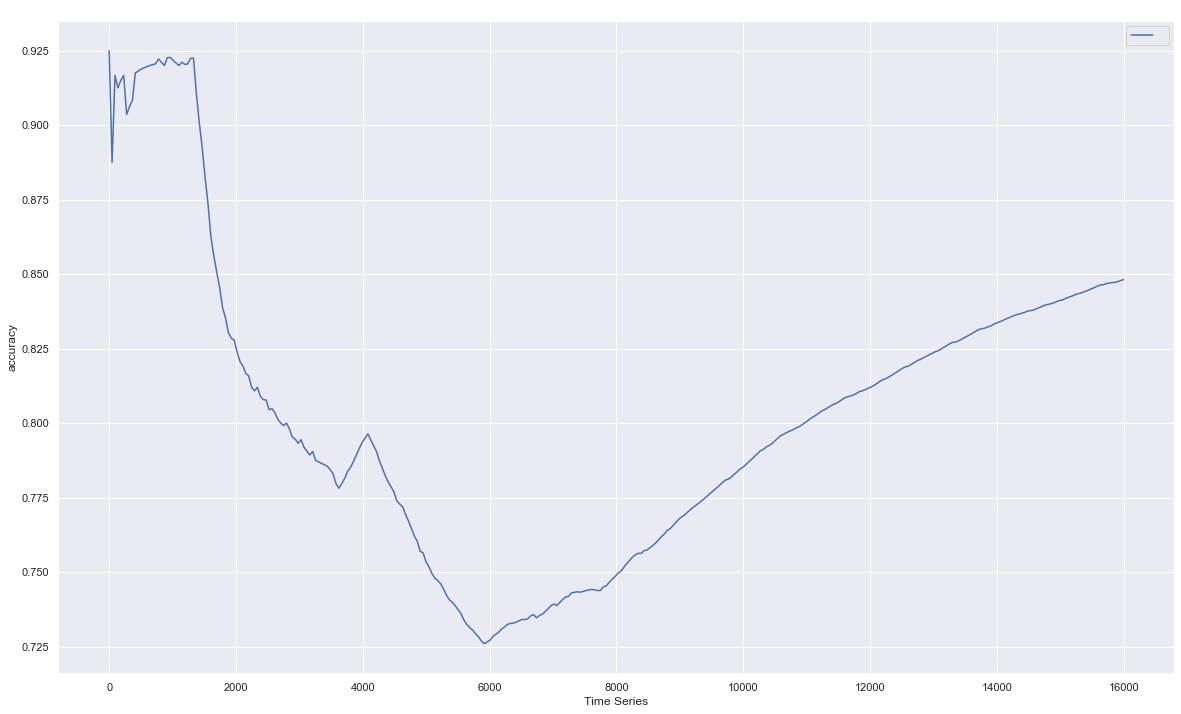

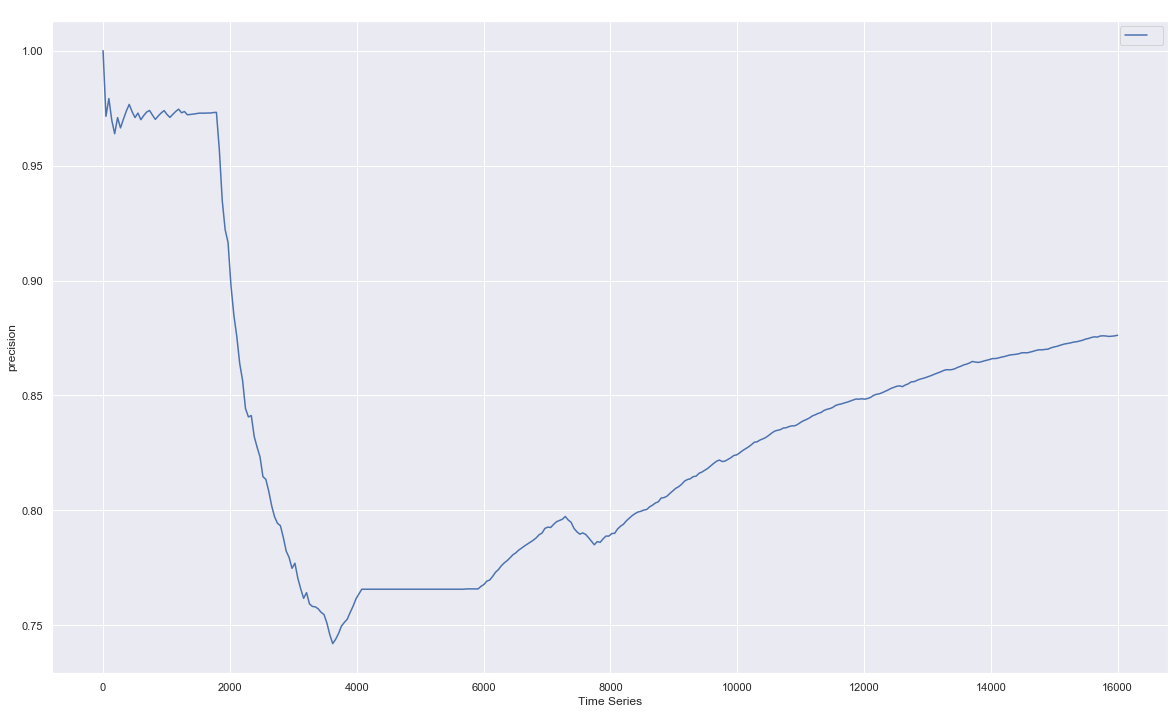

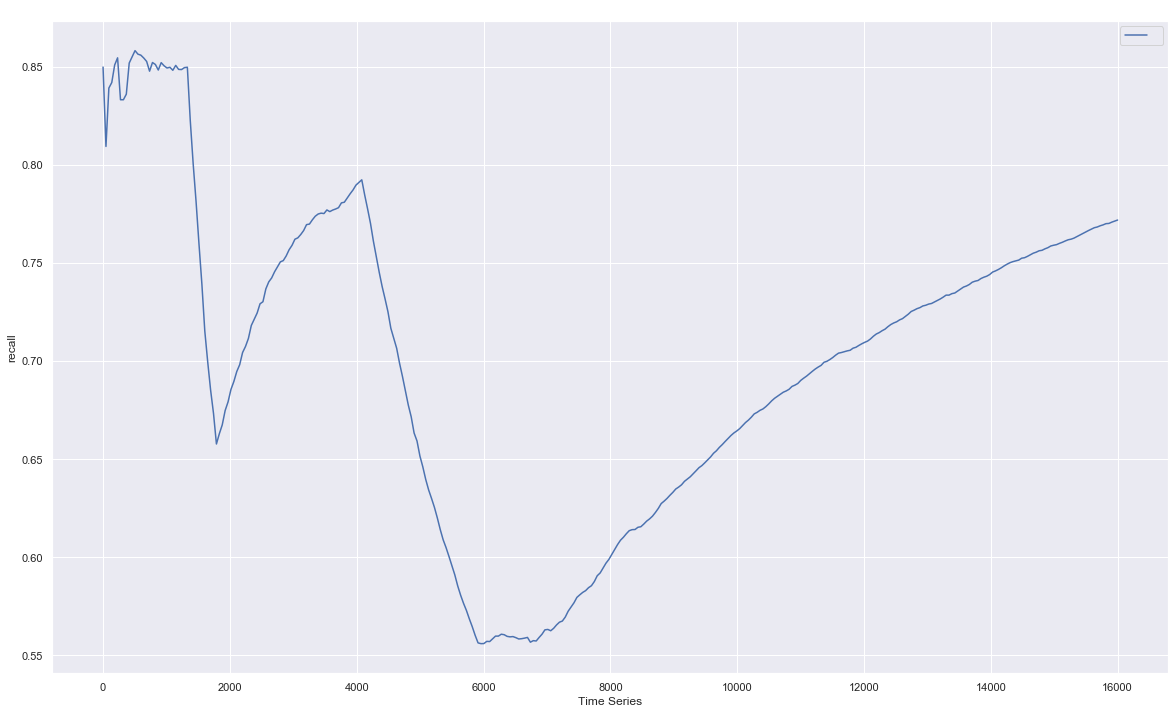

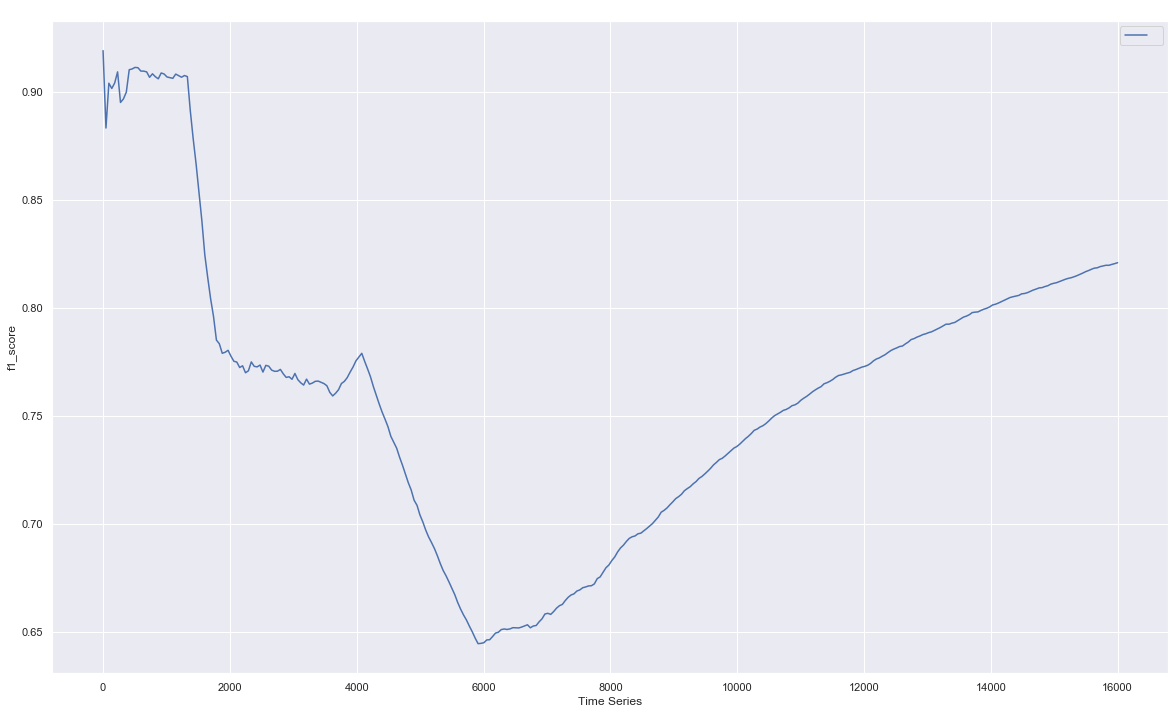

In [98]:
metrics = ['accuracy','precision','recall','f1_score']
for metric in metrics:
    time_series_plot(df,  metric)

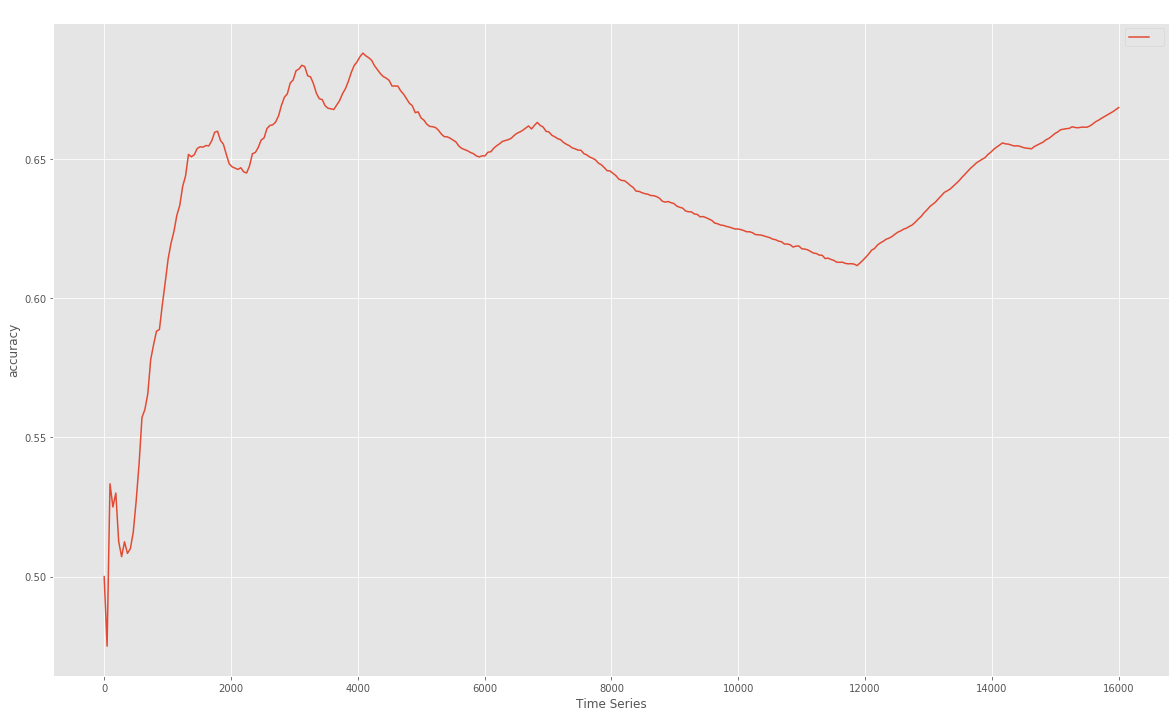

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


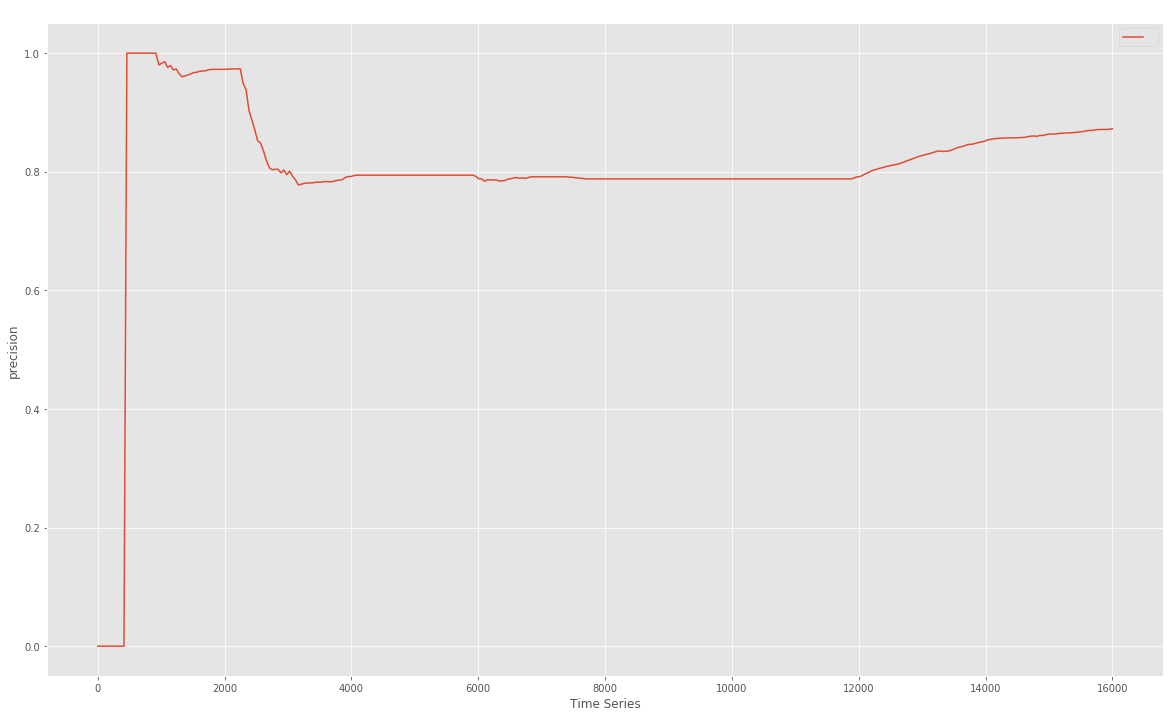

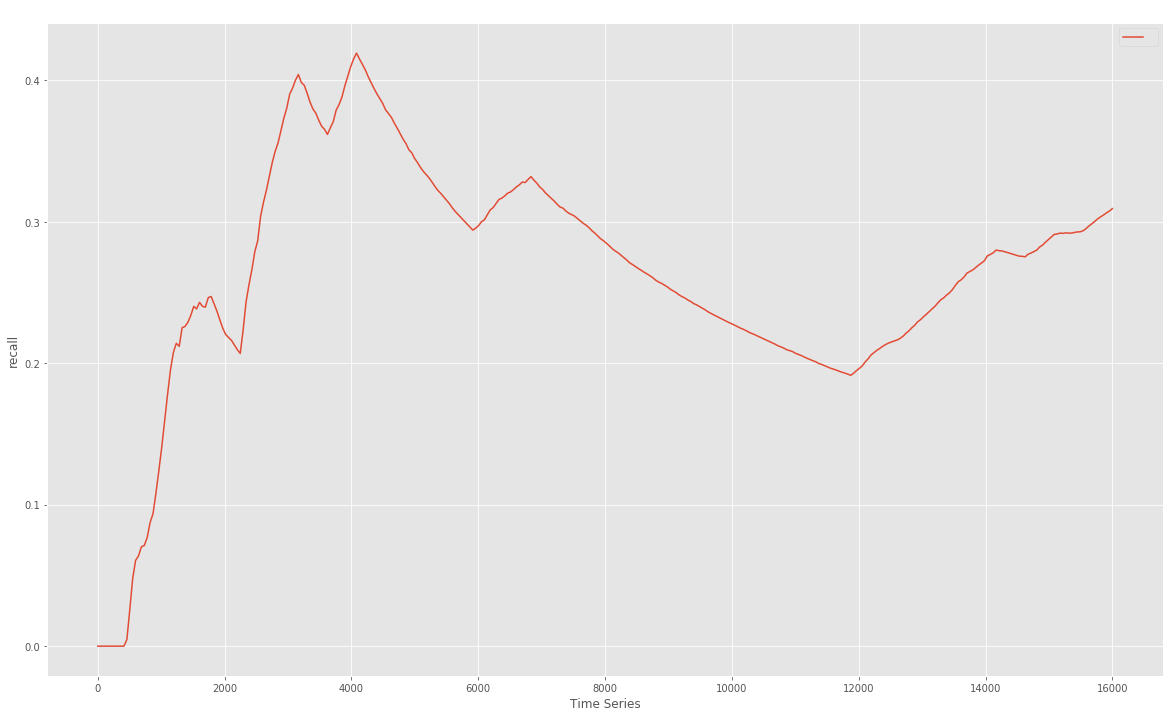

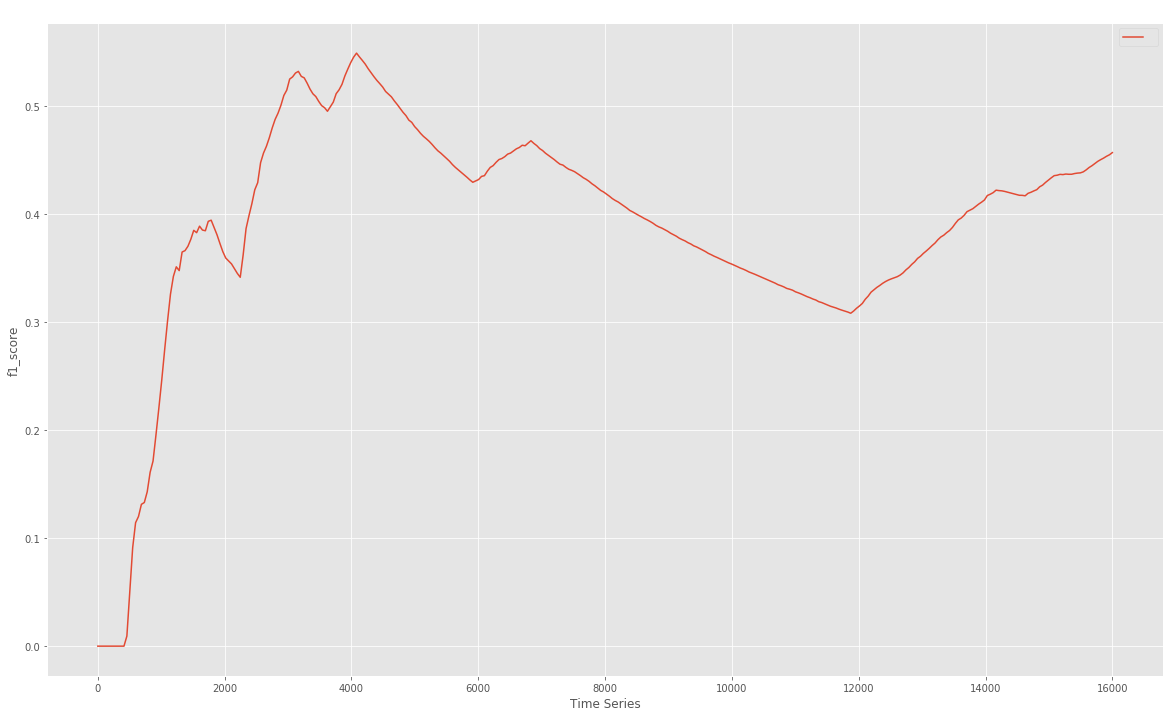

In [72]:
for metric in metrics:
    time_series_plot(df_,  metric)

In [100]:
df.shape[0]

36

In [101]:
df.head()

chunk_number                                             y_test  \
0  chunk_number 0  0      0
1      0
2      0
3      0
4      1
 ...   
1  chunk_number 1  2000    0
2001    0
2002    0
2003    1
2004  ...   
2  chunk_number 2  4000    0
4001    0
4002    1
4003    1
4004  ...   
3  chunk_number 3  6000    1
6001    1
6002    1
6003    0
6004  ...   
4  chunk_number 4  8000    1
8001    0
8002    1
8003    1
8004  ...   

                                           y_predict  
0  [[0.12726203], [0.12726203], [0.12726203], [0....  
1  [[0.07537931], [0.07537928], [0.07537931], [1....  
2  [[0.079919815], [0.079919815], [1.0], [1.0], [...  
3  [[0.4995088], [1.0], [0.3564337], [0.3564249],...  
4  [[1.0], [1.0], [1.0], [1.0], [0.0898335], [1.0...

In [75]:
df_.head()

chunk_number                                             y_test  \
0  chunk_number 0  0      0
1      0
2      0
3      0
4      1
 ...   
1  chunk_number 1  2000    0
2001    0
2002    0
2003    1
2004  ...   
2  chunk_number 2  4000    0
4001    0
4002    1
4003    1
4004  ...   
3  chunk_number 3  6000    1
6001    1
6002    1
6003    0
6004  ...   
4  chunk_number 4  8000    1
8001    0
8002    1
8003    1
8004  ...   

                                           y_predict  
0  [[0.46650675], [0.46650675], [0.46650675], [0....  
1  [[0.48118377], [0.48118377], [0.48118377], [0....  
2  [[0.4477736], [0.4477736], [0.4477736], [0.447...  
3  [[0.47324866], [1.0], [1.0], [0.12249559], [0....  
4  [[0.47811016], [0.47811016], [0.47811016], [0....

In [102]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
import seaborn as sns 
sns.set(rc={'figure.figsize':(25,15)})

def print_result(y_pred, y_test , title ,color):

    if len(y_test) < len(y_pred):
        y_pred = y_pred[: len(y_test)]
    elif len(y_test) > len(y_pred):
        y_test = y_test[: len(y_pred)]


    accuracy = accuracy_score(y_pred, y_test)
    classification_rep = classification_report(y_test, y_pred)
    con_matrix = confusion_matrix(y_test, y_pred)
    

    if len(con_matrix)==1:
        if len(con_matrix[0])==1:
            con_matrix = list(con_matrix)
            con_matrix[0] = list(con_matrix[0])
            con_matrix[0].append(0)
            con_matrix = np.array([con_matrix[0],[0,0]])
#     print(con_matrix)

    # ploting confustion matrix
    plt.figure(figsize=(25,15))
    plt.subplot(2,1,1)
    # categories = [‘Zero’, ‘One’]
    # make_confusion_matrix(cf_matrix, 
    #                   group_names=labels,
    #                   categories=categories, 
    #                   cmap=’binary’)

    # sns.heatmap(con_matrix, annot=True, annot_kws={"size": 16},fmt='g', cmap='Blues')
    
    # for i in range(2):
    #   a=con_matrix.tolist()
#     print('y_true class: 0   ',y_test.count(0))
#     print('y_true class: 1   ',y_test.count(1))
    group_names =['without B_M']
    
    T1 = y_test.count(0) if y_test.count(0)!=0 else 1
    T2 = y_test.count(1) if y_test.count(1)!=0 else 1
    
    group_counts = con_matrix
    group_percentages = np.round(con_matrix / np.array([[T1 , T1],[T2 , T2]]),3)
    
#     labels = [[v1,v2] for v1, v2 in zip(group_counts,group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
    
    t = 0.5
    plt.text(x=0.0 , y = 2.6, s =  "confusion_matrix :",fontsize=15)
    plt.text(x=0.0 , y = 3.3-t, s =  "without B_M",fontsize=15)
    plt.text(x=0.0 , y = 3.4-t, s =  "with B_M ",fontsize=15)
    plt.text(x=0.3 , y = 3.2-t, s =  "without B_M",fontsize=15)
    plt.text(x=0.6 , y = 3.2-t, s =  "with B_M",fontsize=15)
    plt.text(x=0.3 , y = 3.3-t, s =  "{}".format(con_matrix[0][0]),fontsize=15)
    plt.text(x=0.6 , y = 3.3-t, s =  "{}".format(con_matrix[0][1]),fontsize=15)
    plt.text(x=0.3 , y = 3.4-t, s =  "{}".format(con_matrix[1][0]),fontsize=15)
    plt.text(x=0.6 , y = 3.4-t, s =  "{}".format(con_matrix[1][1]),fontsize=15)
  
    sns.heatmap(group_percentages,xticklabels= ['without B_M' , 'with B_M'], yticklabels=['without B_M' , 'with B_M']  , annot=True, annot_kws={"size": 16},fmt='g', cmap=color)
#     print_cm(con_matrix,['without H_M' , 'with H_M'])
    plt.title(title ,  fontsize = 18)
    plt.text(x =0,y = 2.3 , s = "accuracy  score on test : {}".format(accuracy),fontsize=15)    
    plt.text(x=0 , y = 3.9, s =  "classification_report :\n {}".format(classification_rep),fontsize=15)
    
    plt.xlabel("Predicted value")
    plt.ylabel("Real value")
    plt.savefig("{} .png".format(title))

#     plt.savefig(title)
    plt.show()

    # print scores
    # print ("accuracy  score on test : {}".format(accuracy))
    # print(classification_rep)

In [103]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def prints(df):
    y_test , y_predict = None,None
    for i in range(df.shape[0]):
        if y_test is None:
            y_test = df['y_test'][i].tolist()
            y_predict = np.concatenate(df['y_predict'][i].tolist())
            print(i,len(y_test))
        else:
            
            y_test = y_test + df['y_test'][i].tolist()
            y_predict = y_predict + np.concatenate(df['y_predict'][i].tolist())
            print(i,len(y_test))
#         accuracy_score(y_test,y_predict) 
        print()
        y_test = list(map(_replaceitem, y_test))
        y_predict = list(map(_replaceitem, y_predict))
        confusion = confusion_matrix(y_test, y_predict)
        print_cm(confusion, ['One','Zero'])
        print()
        print(classification_report(y_test, y_predict, target_names=['One','Zero'])) 
        print("=================================================")

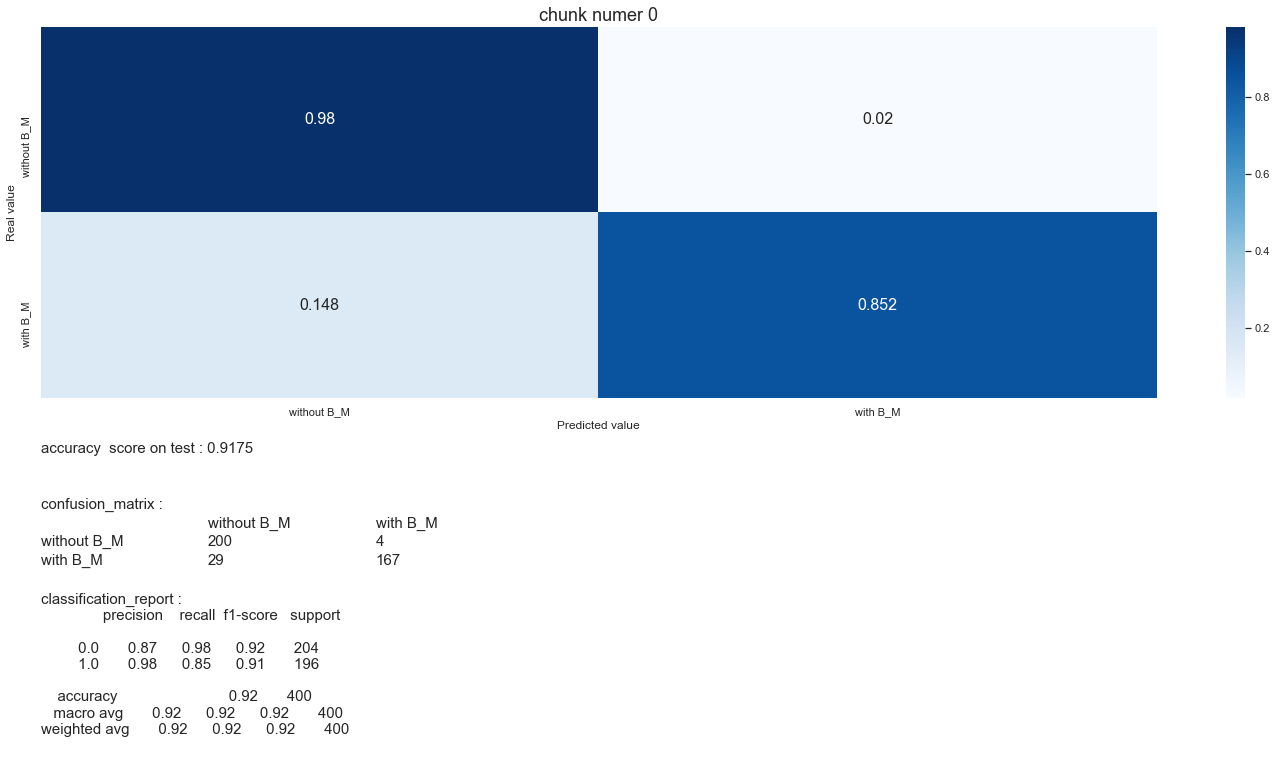

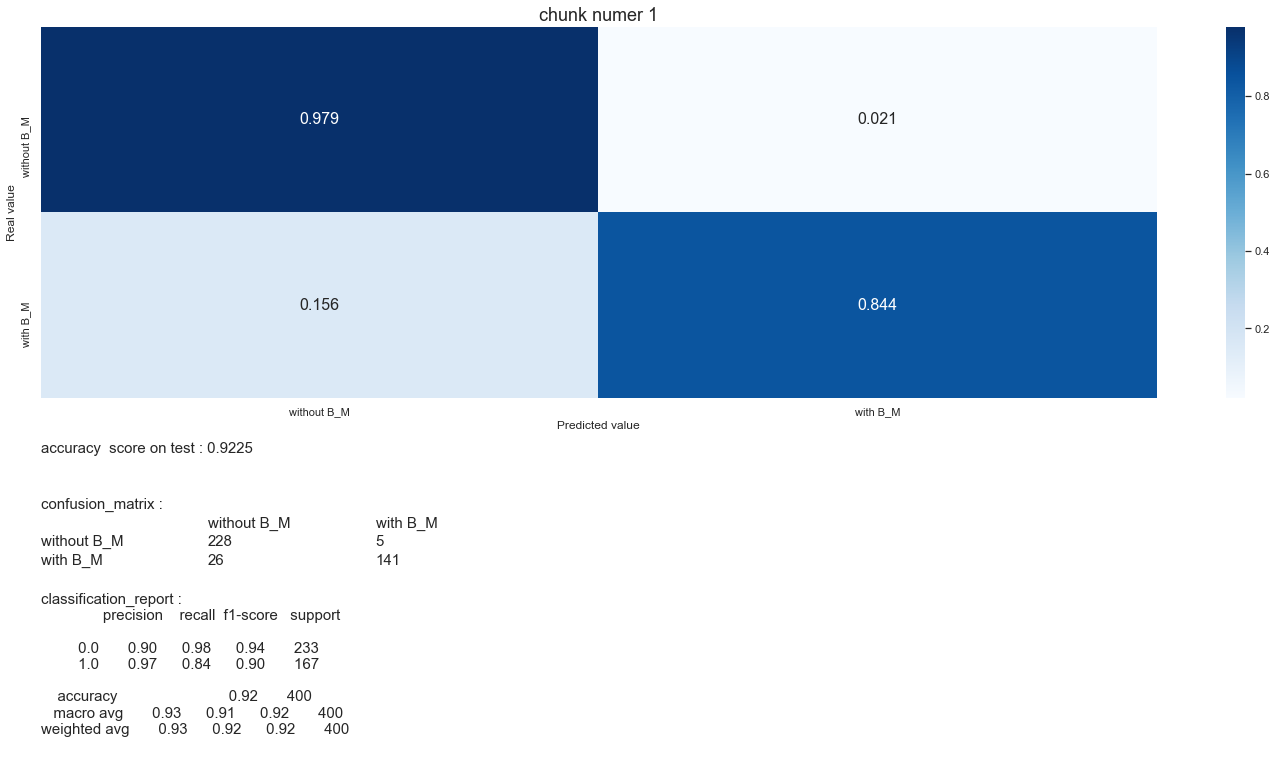

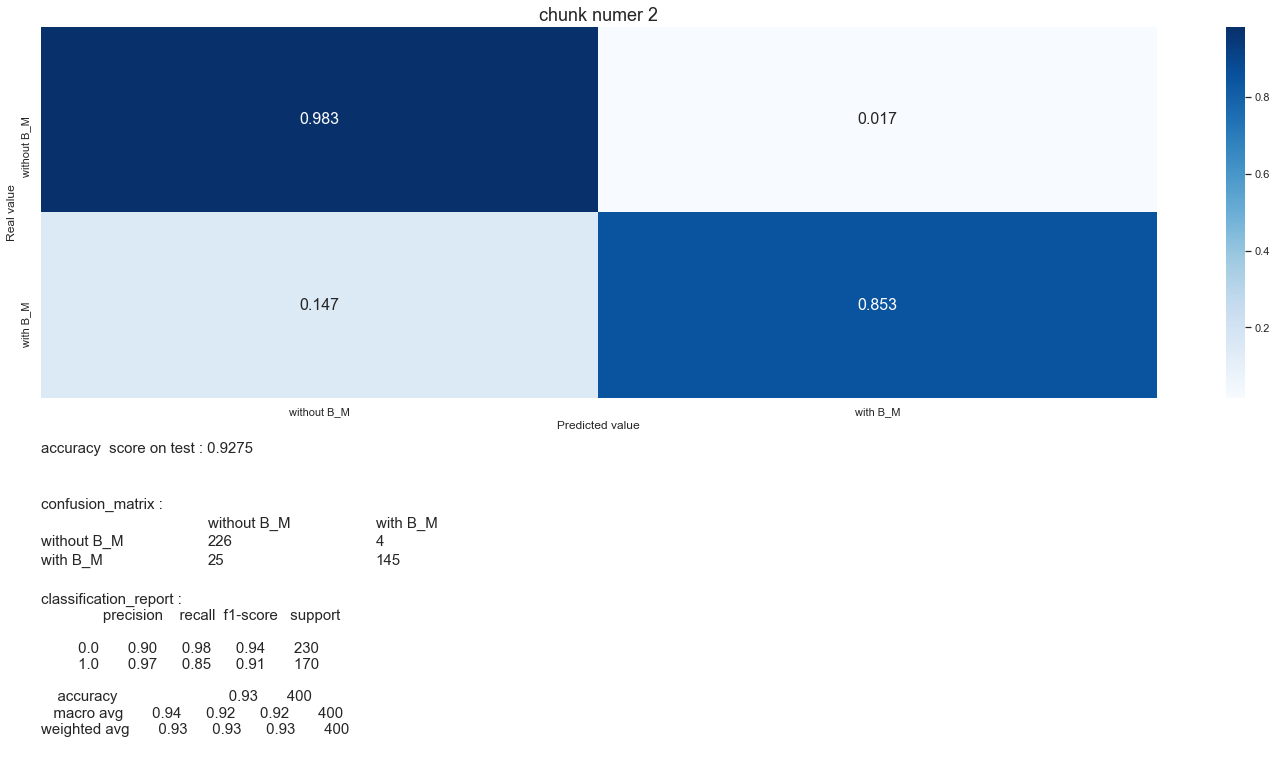

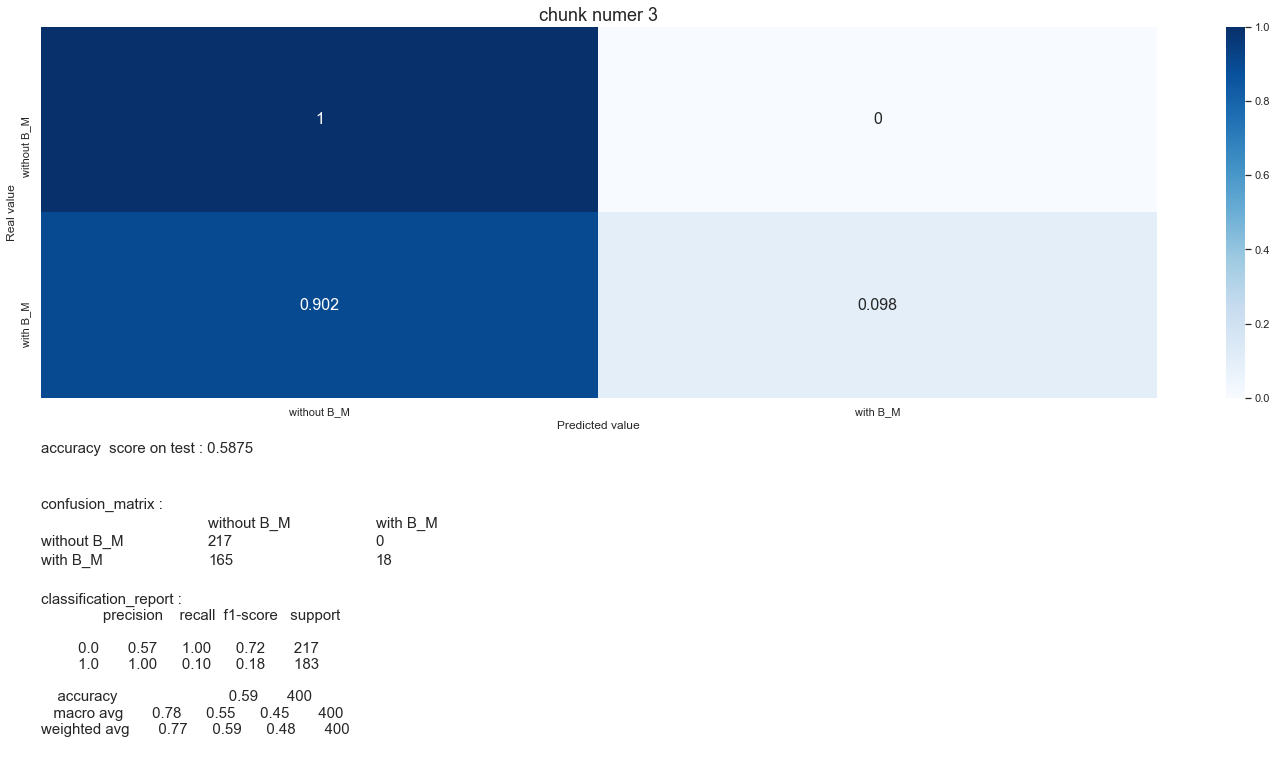

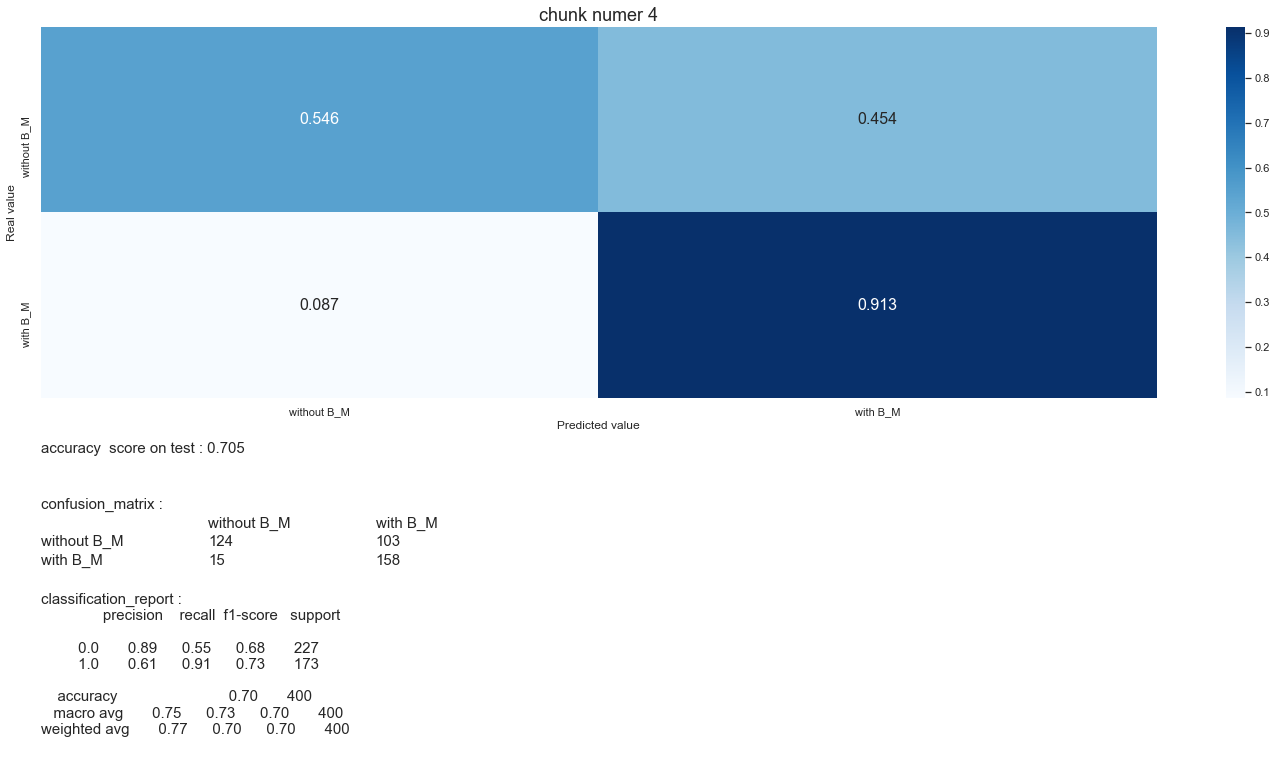

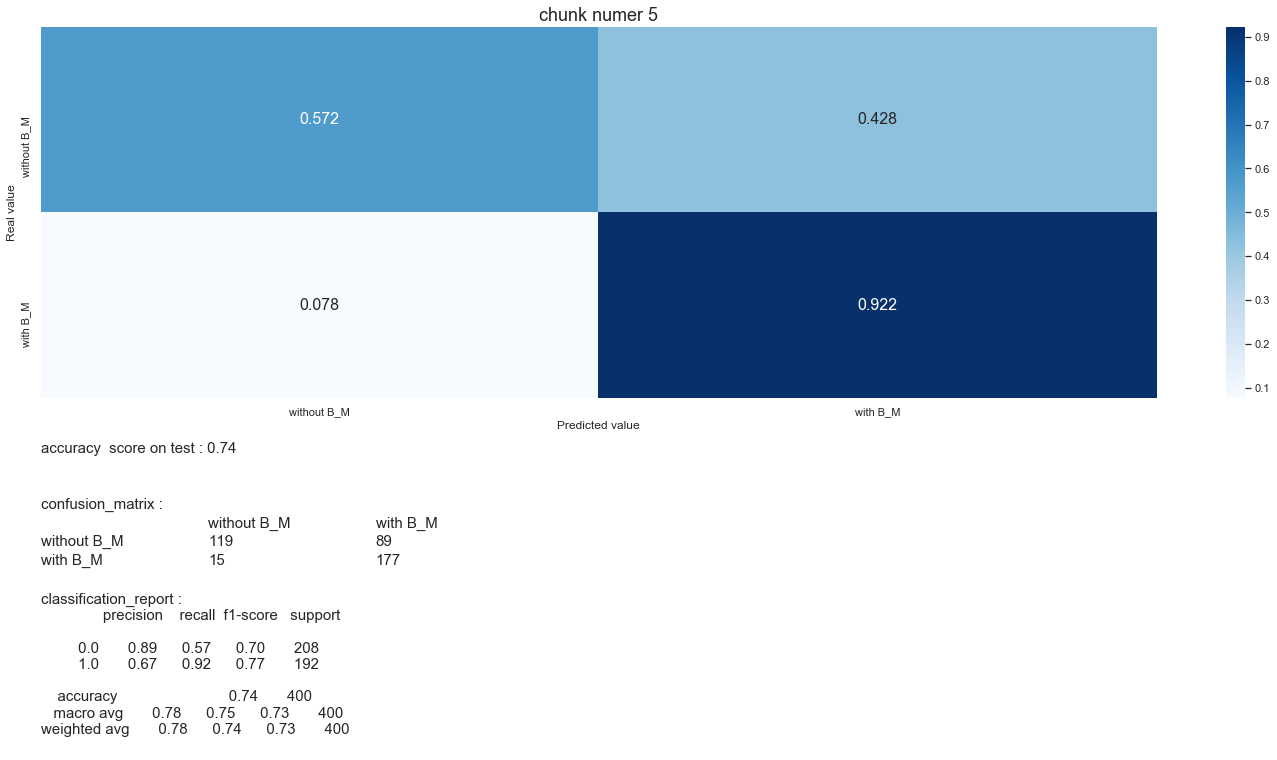

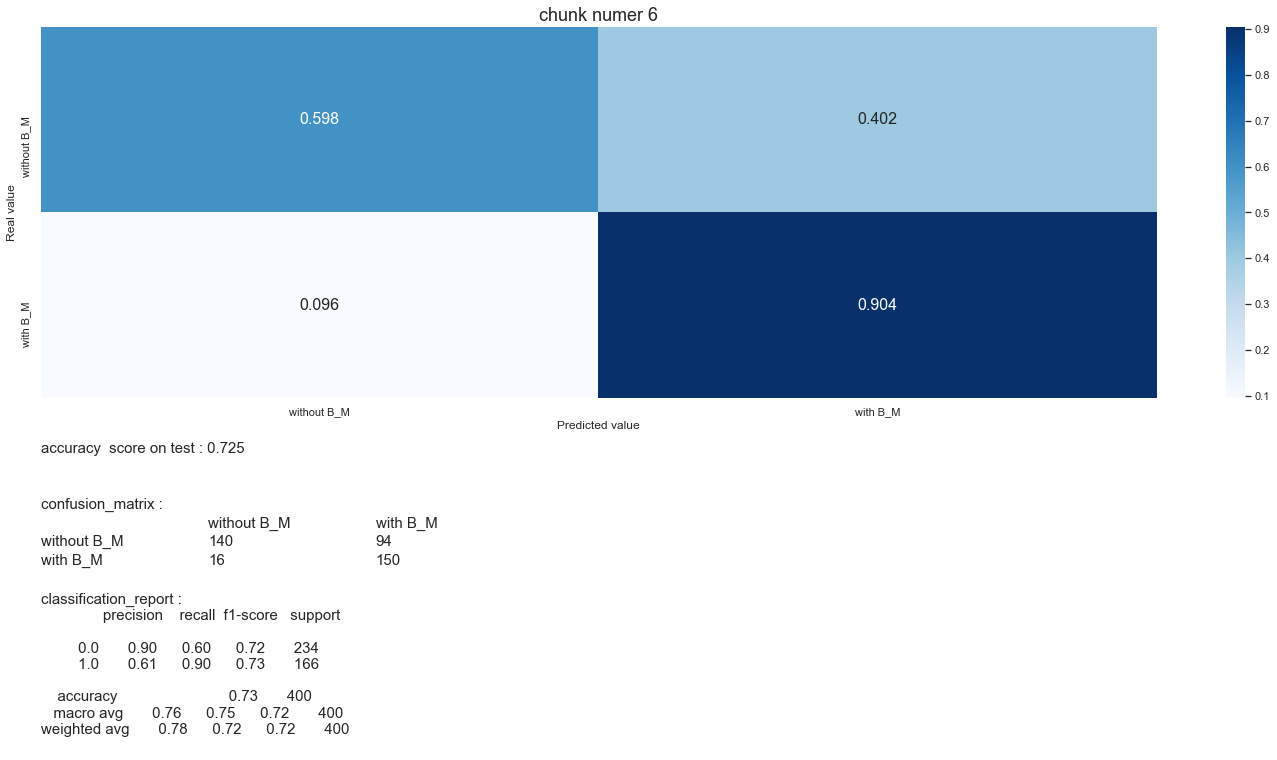

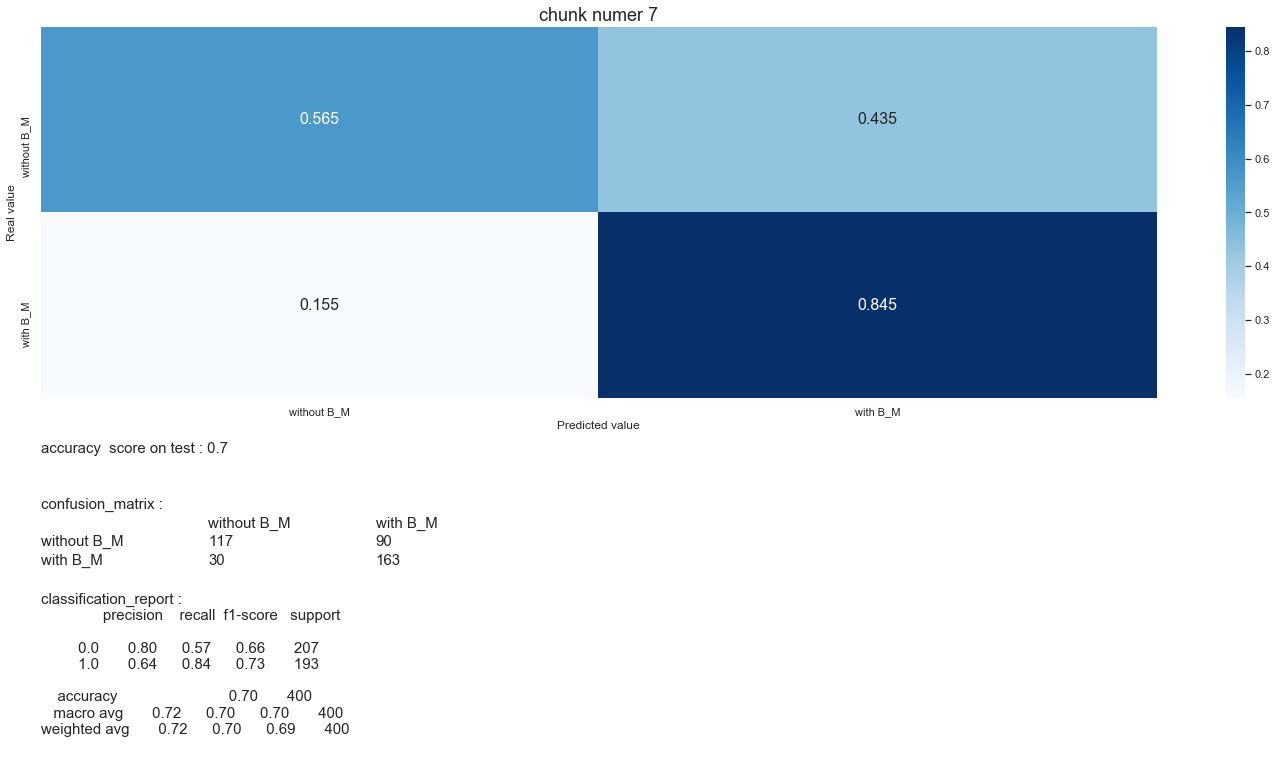

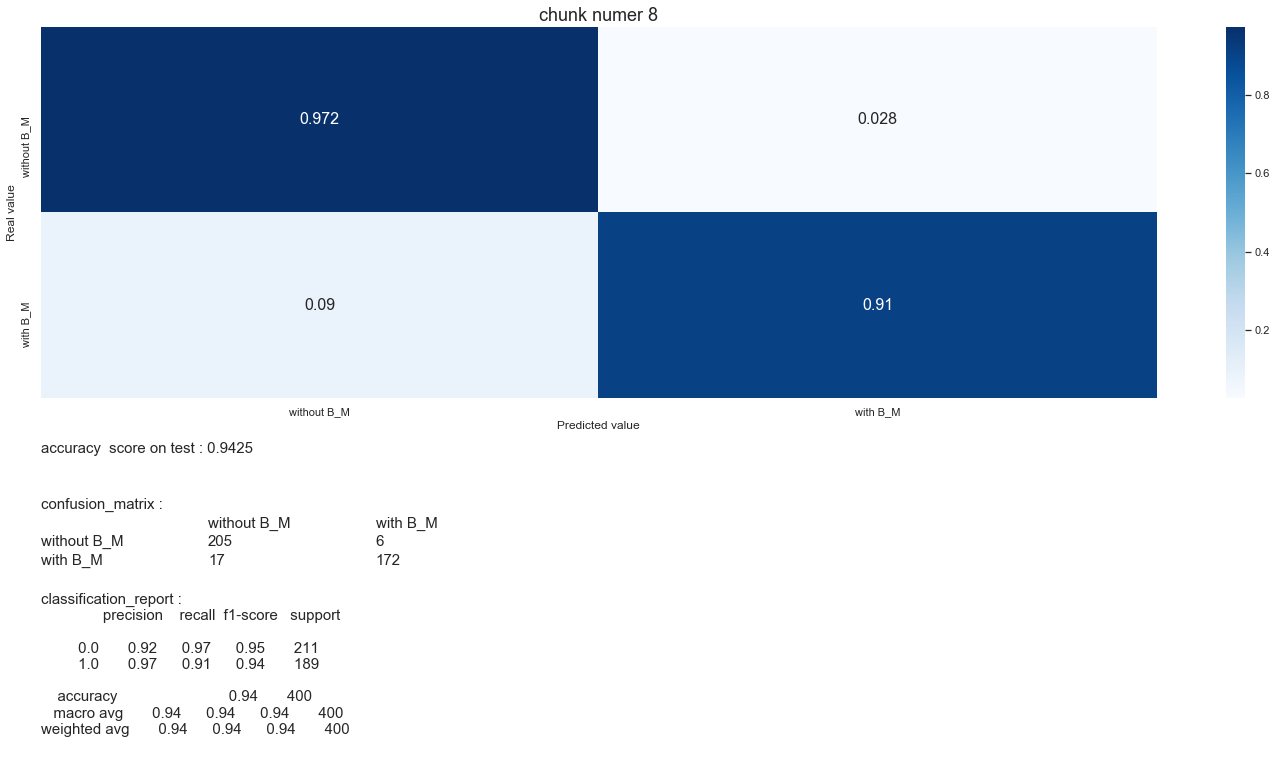

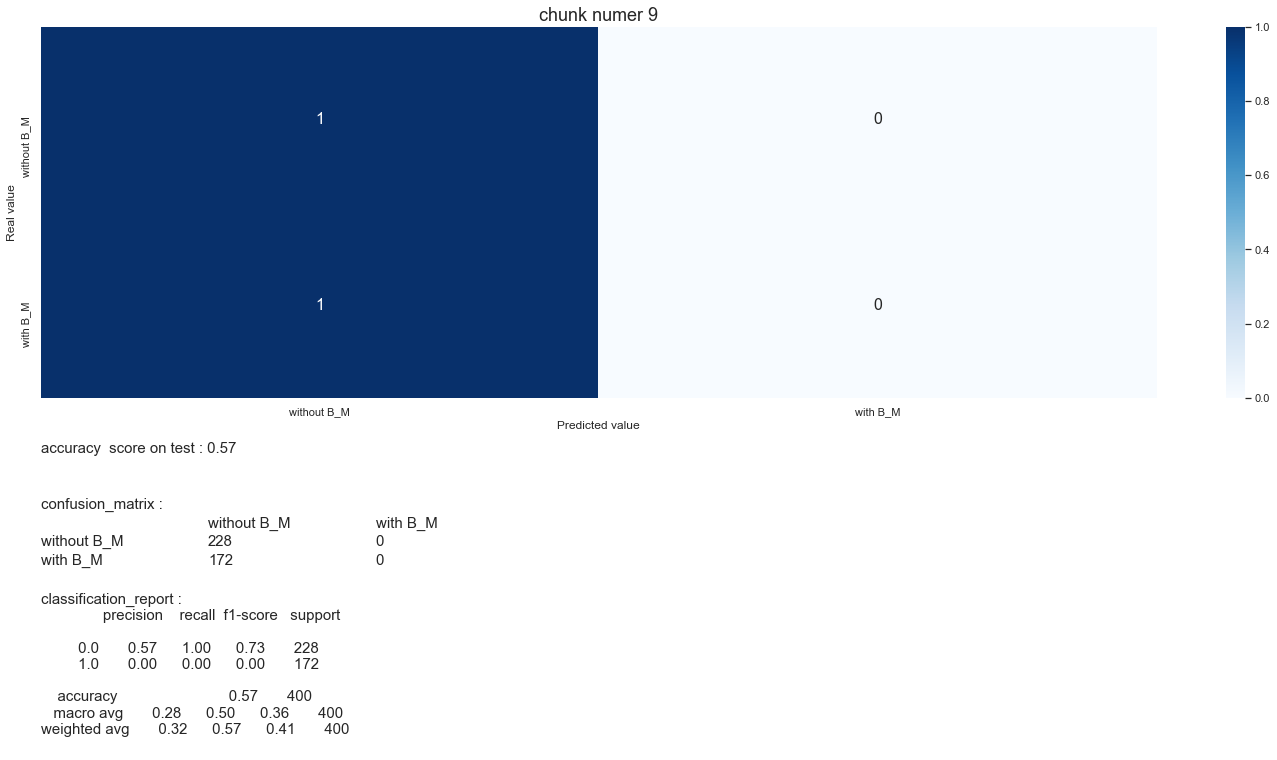

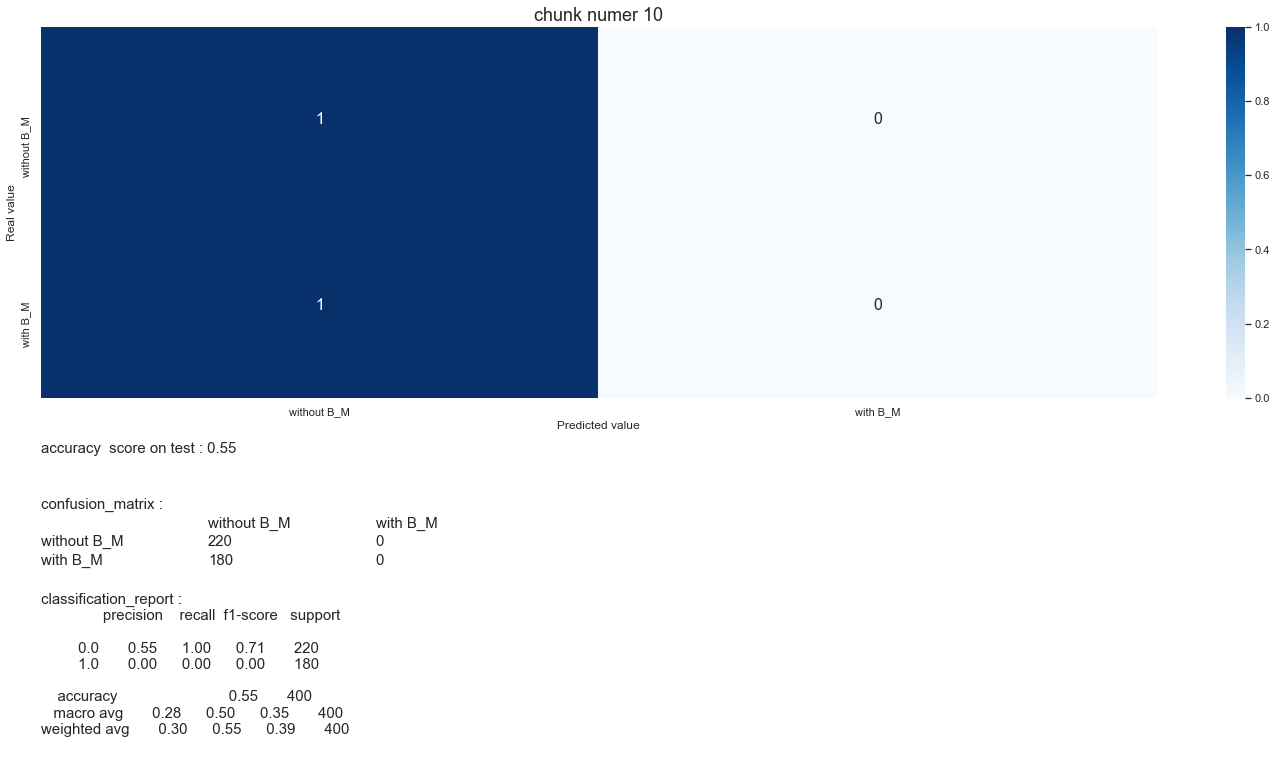

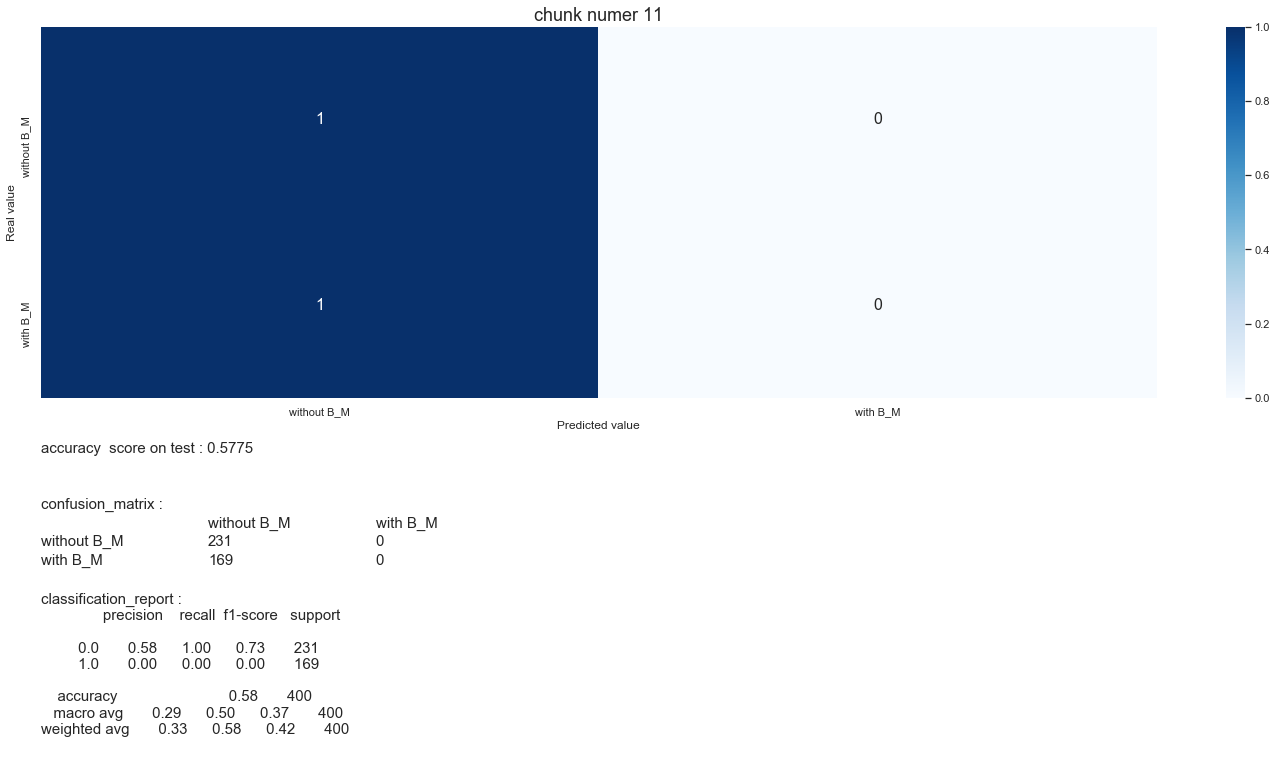

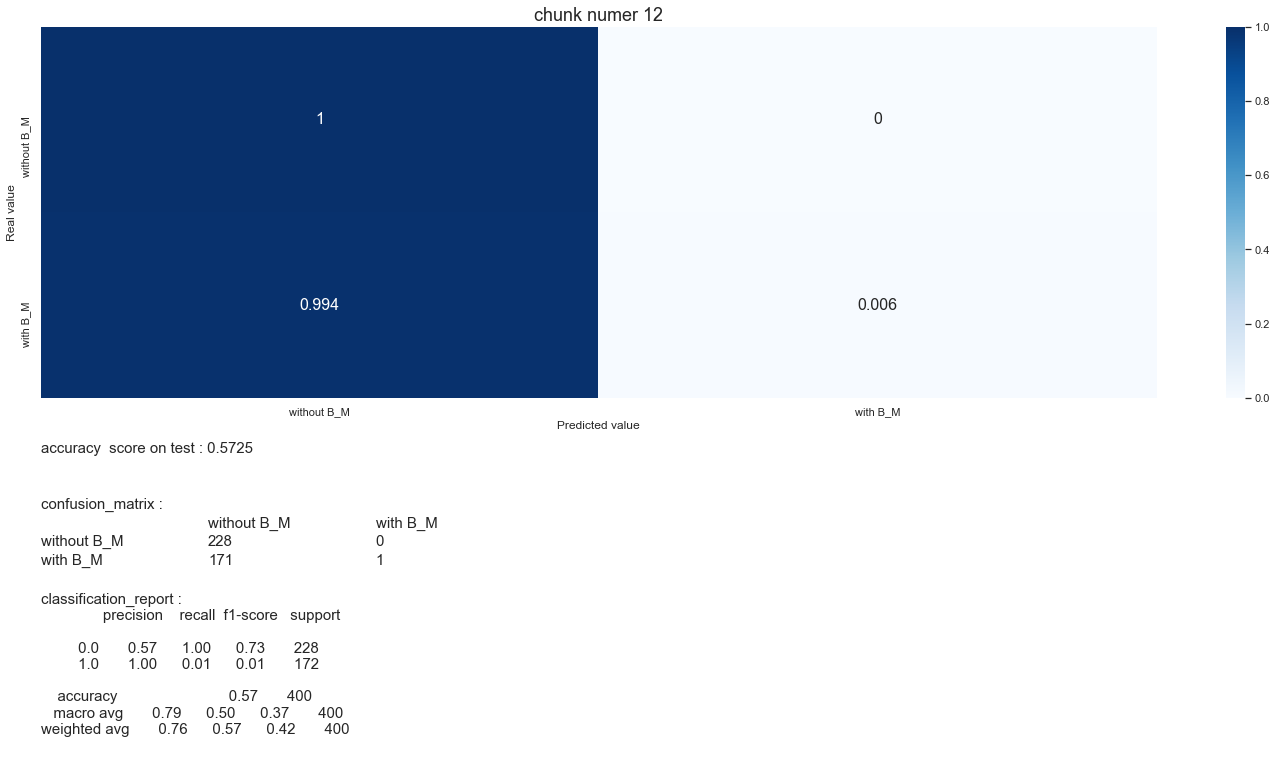

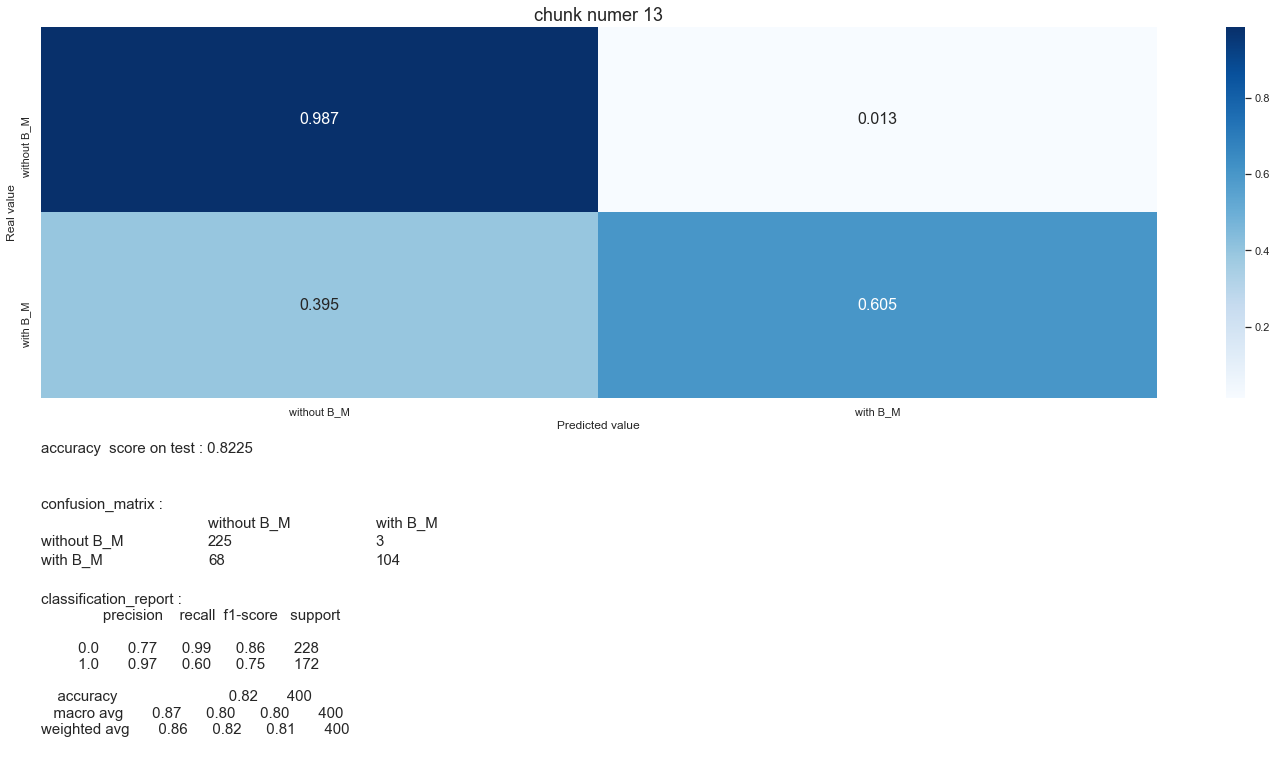

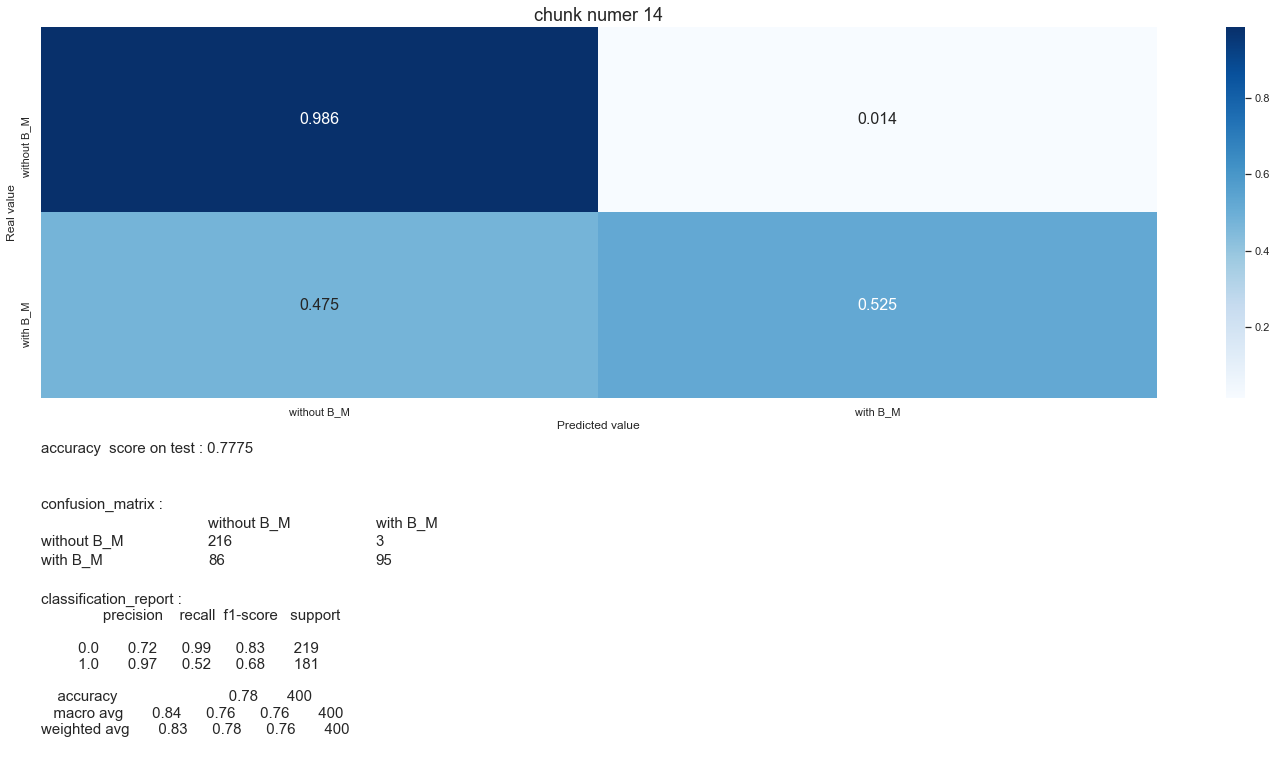

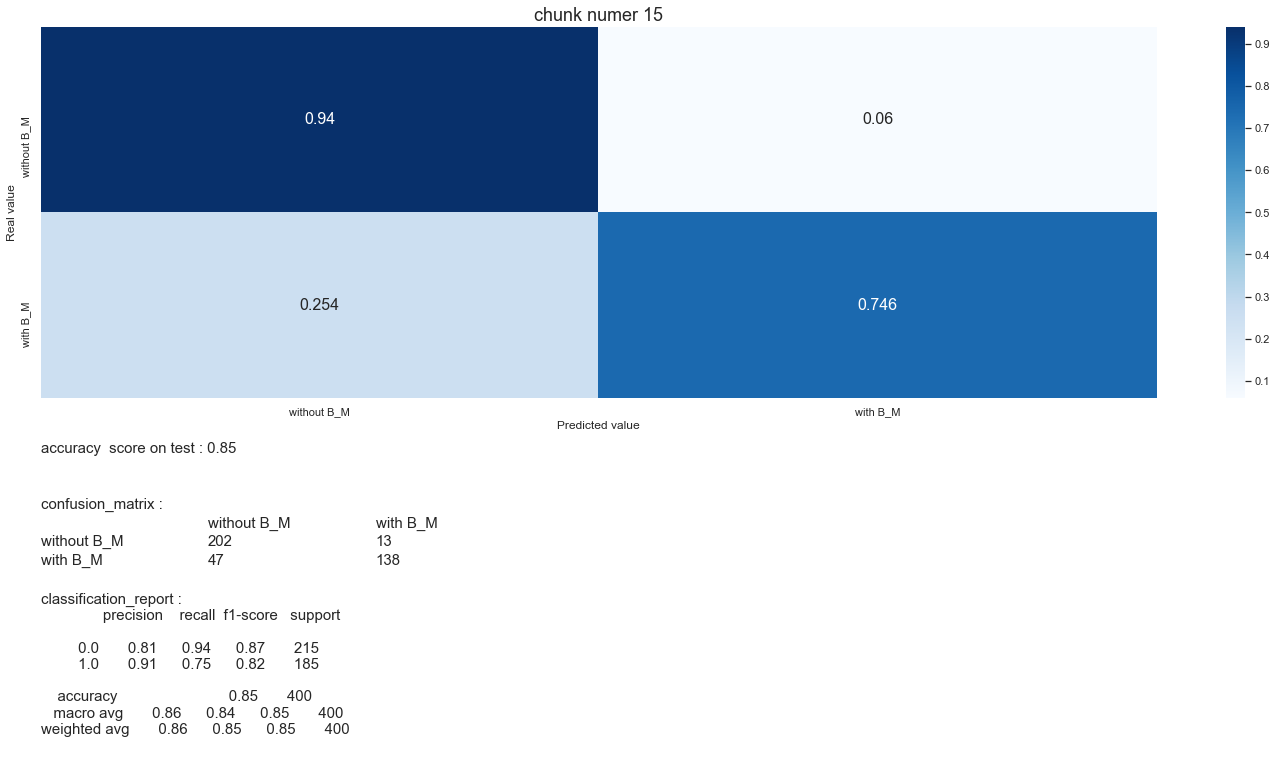

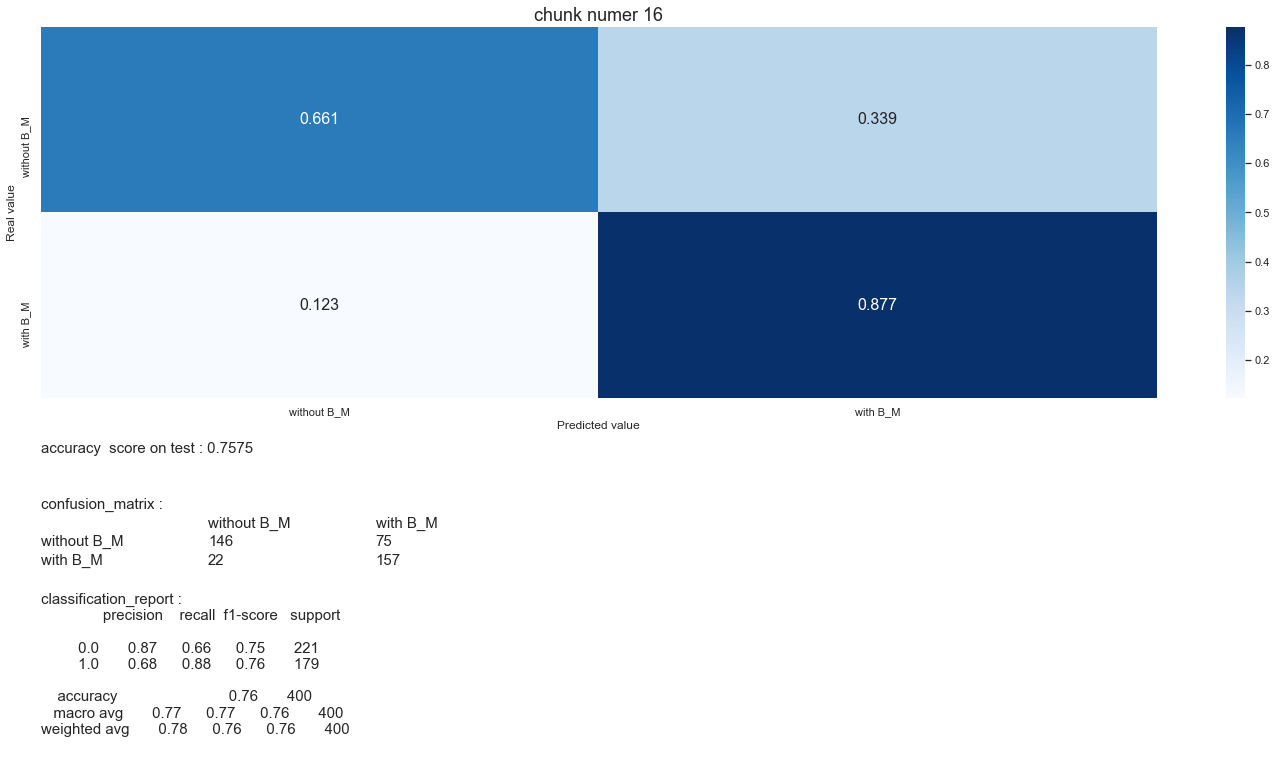

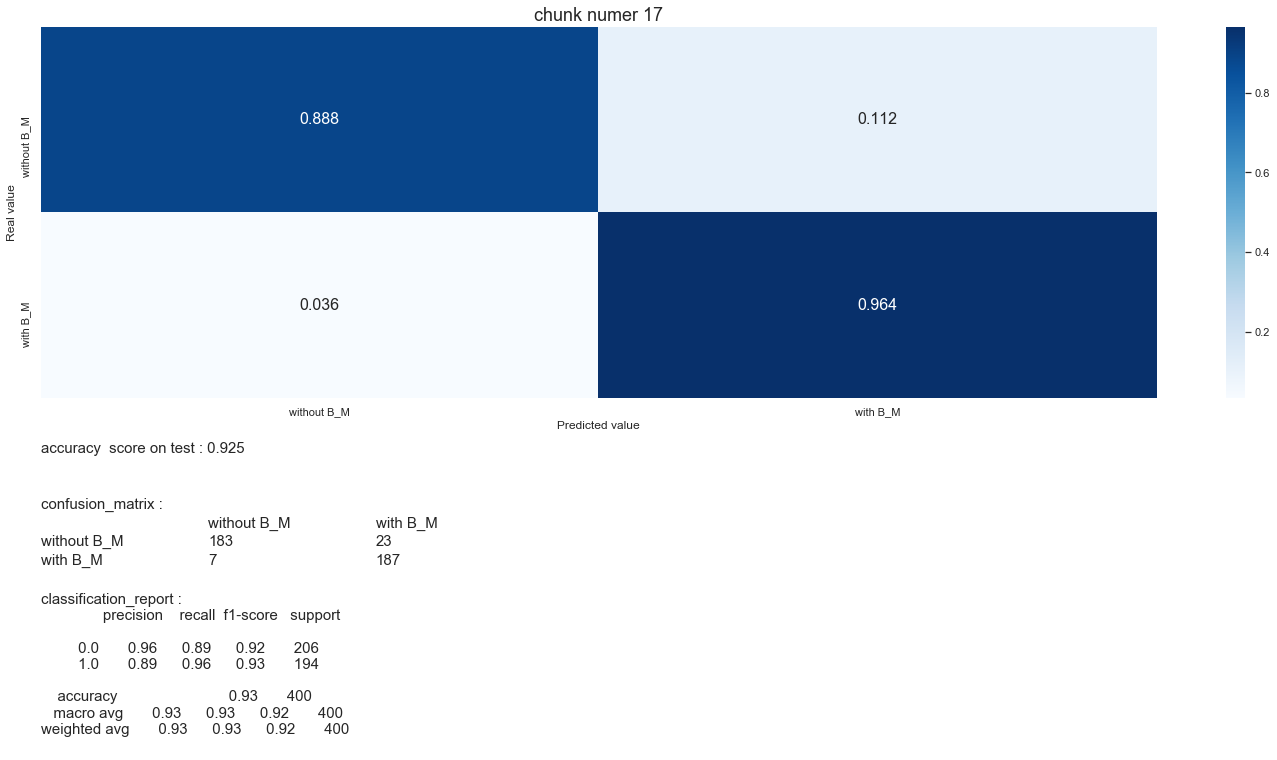

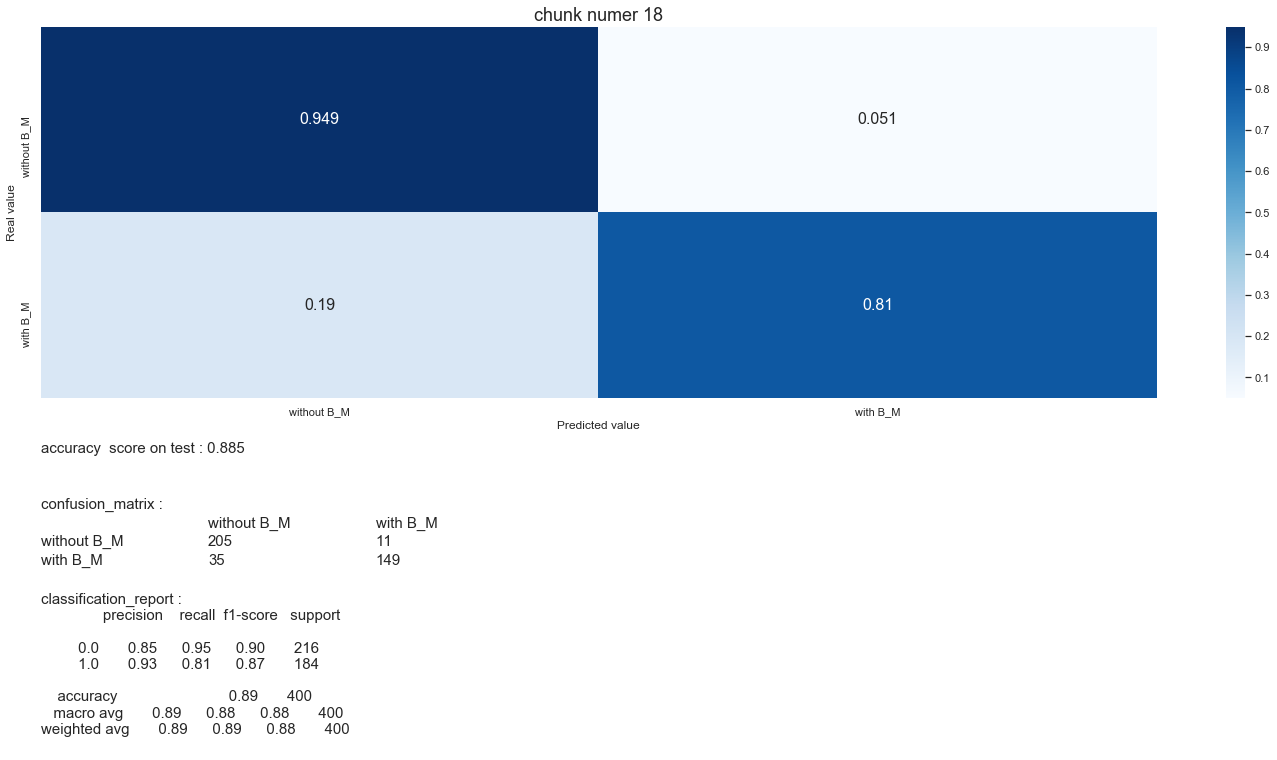

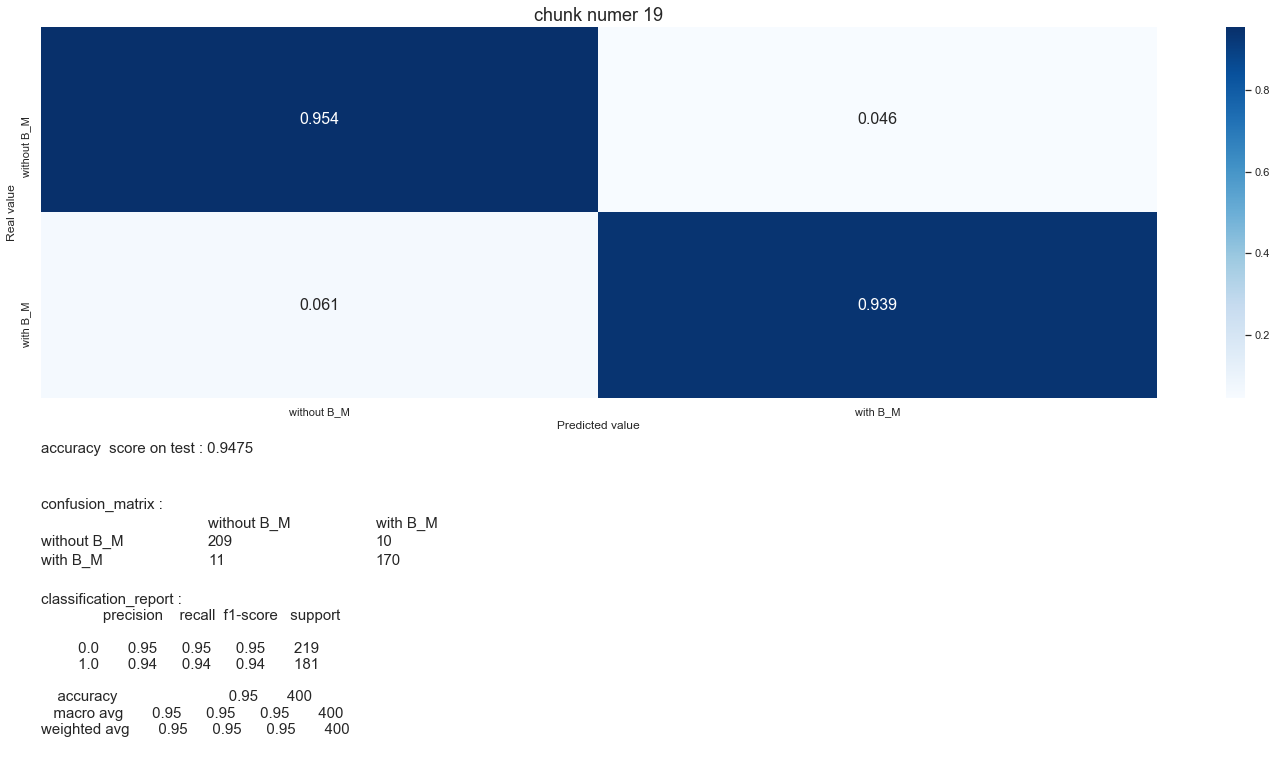

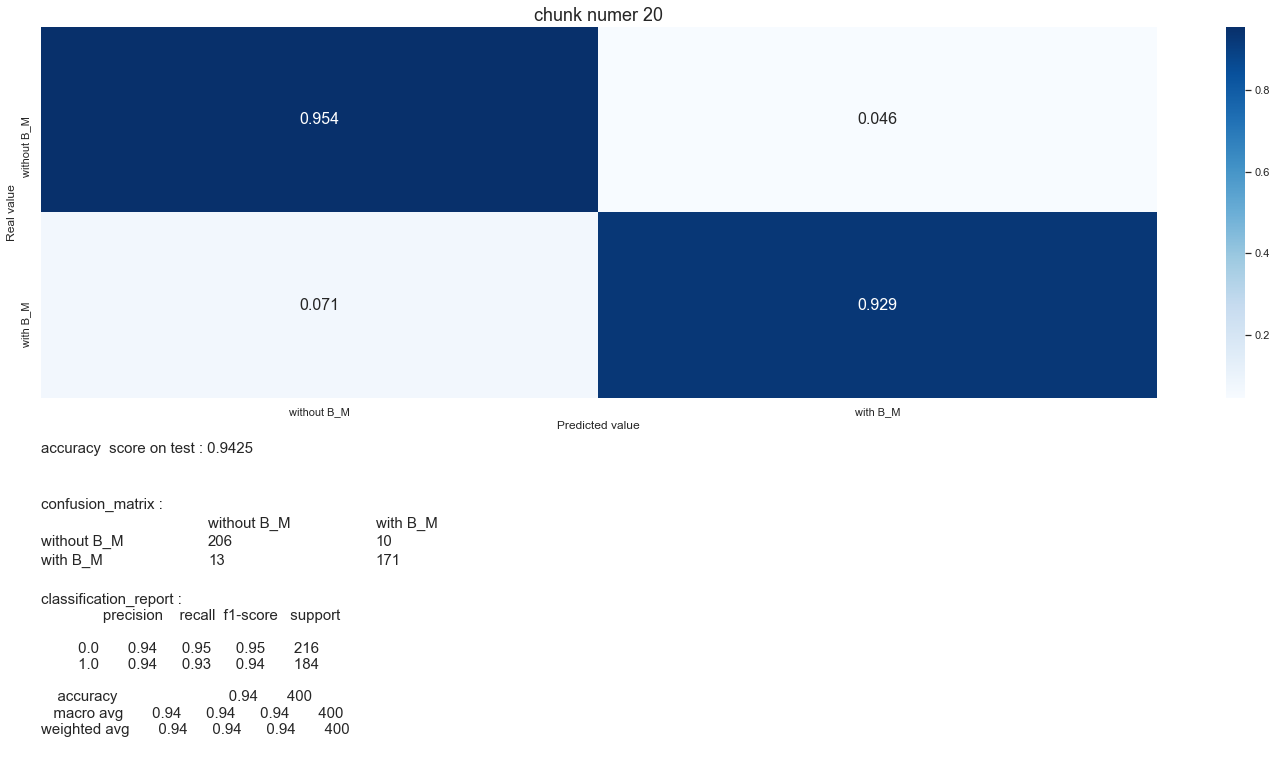

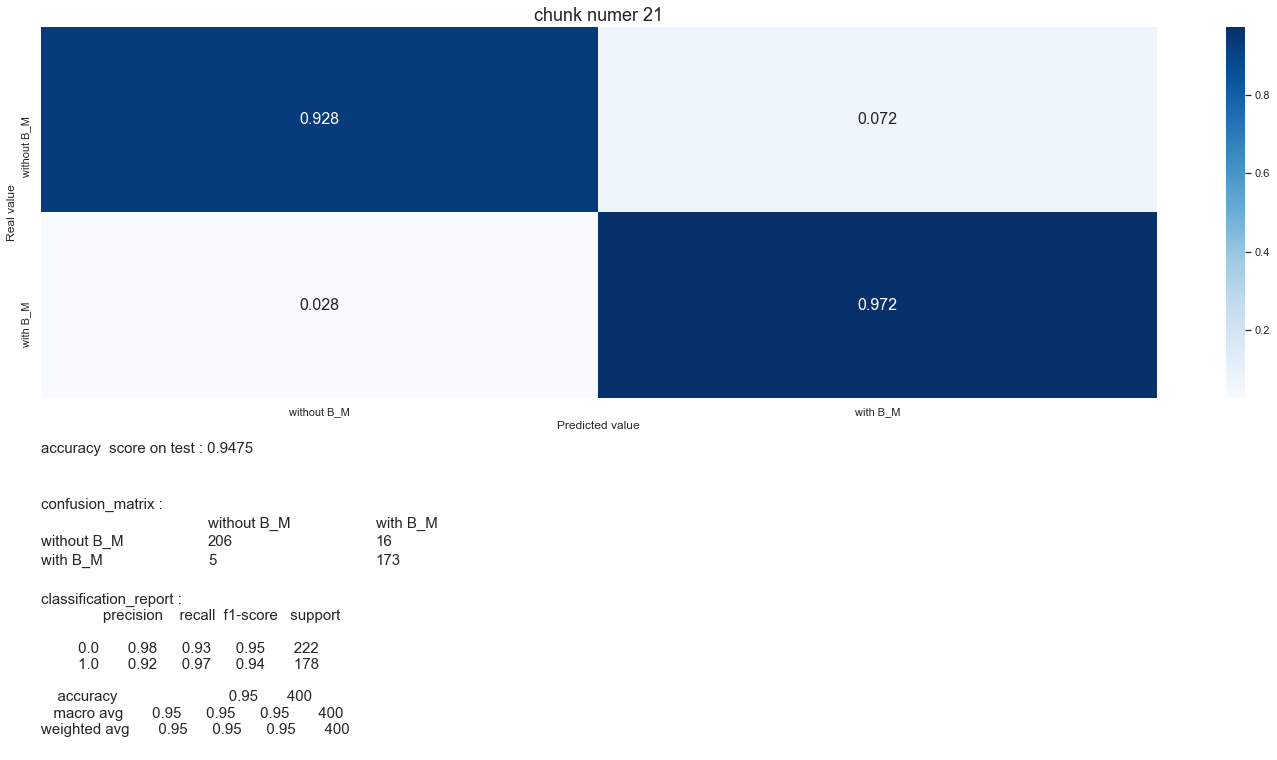

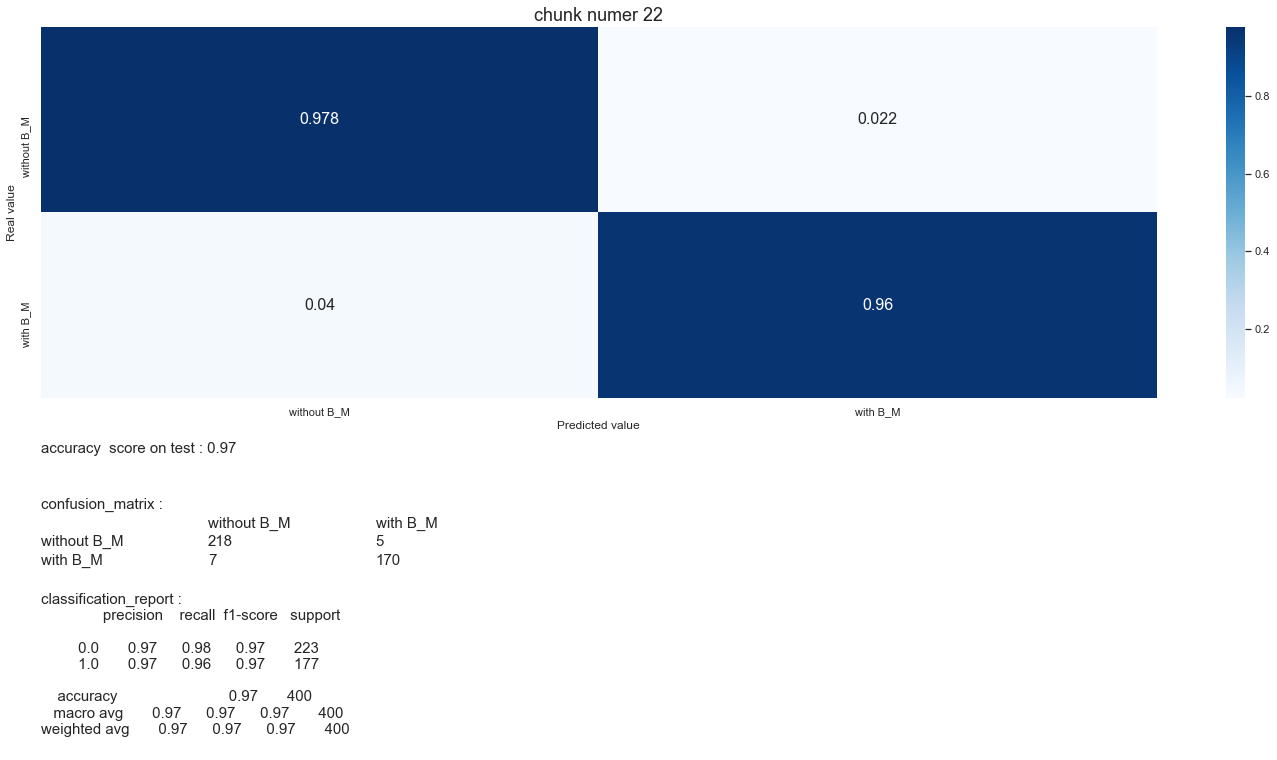

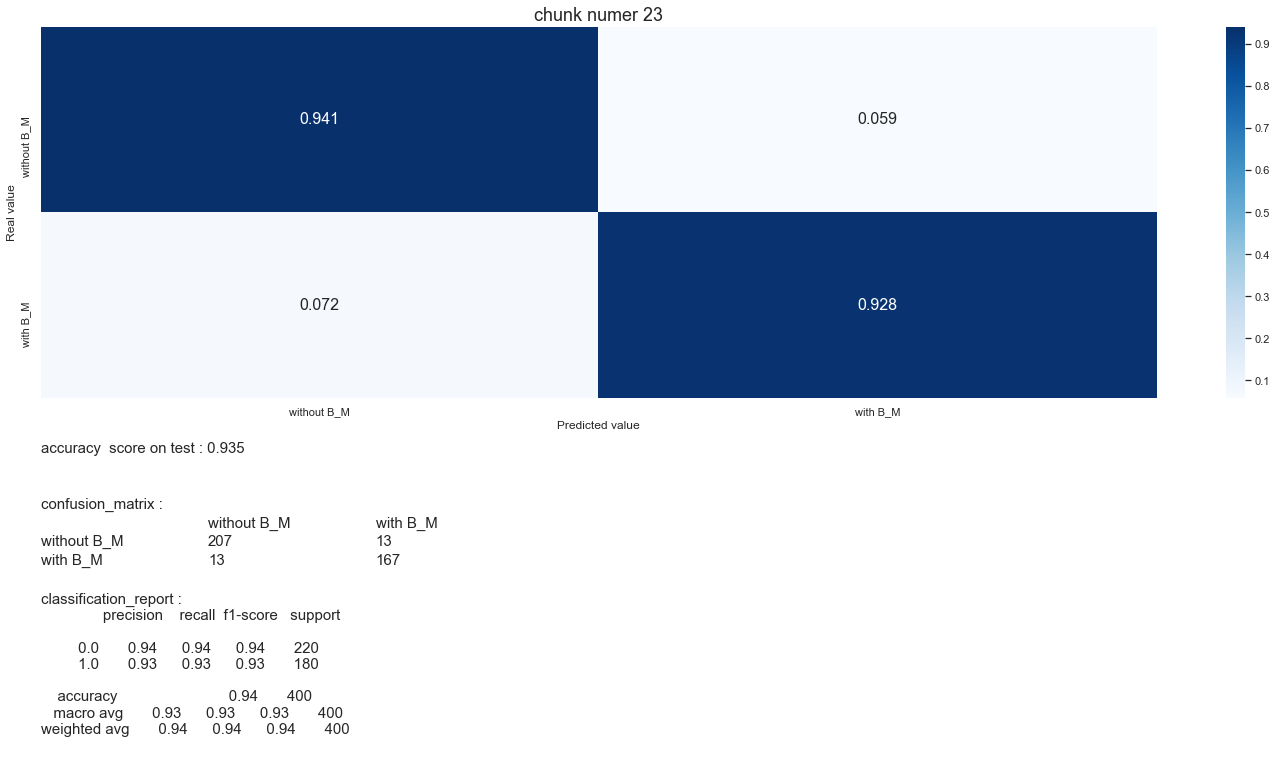

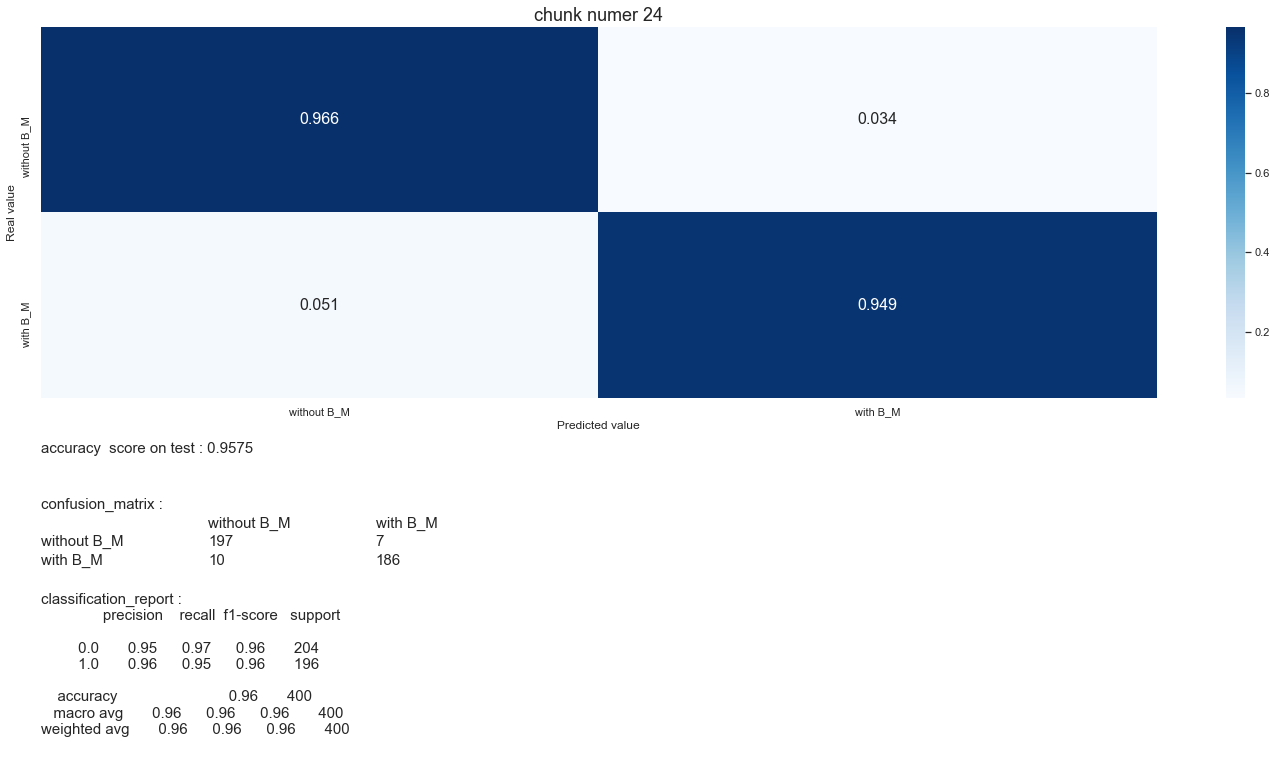

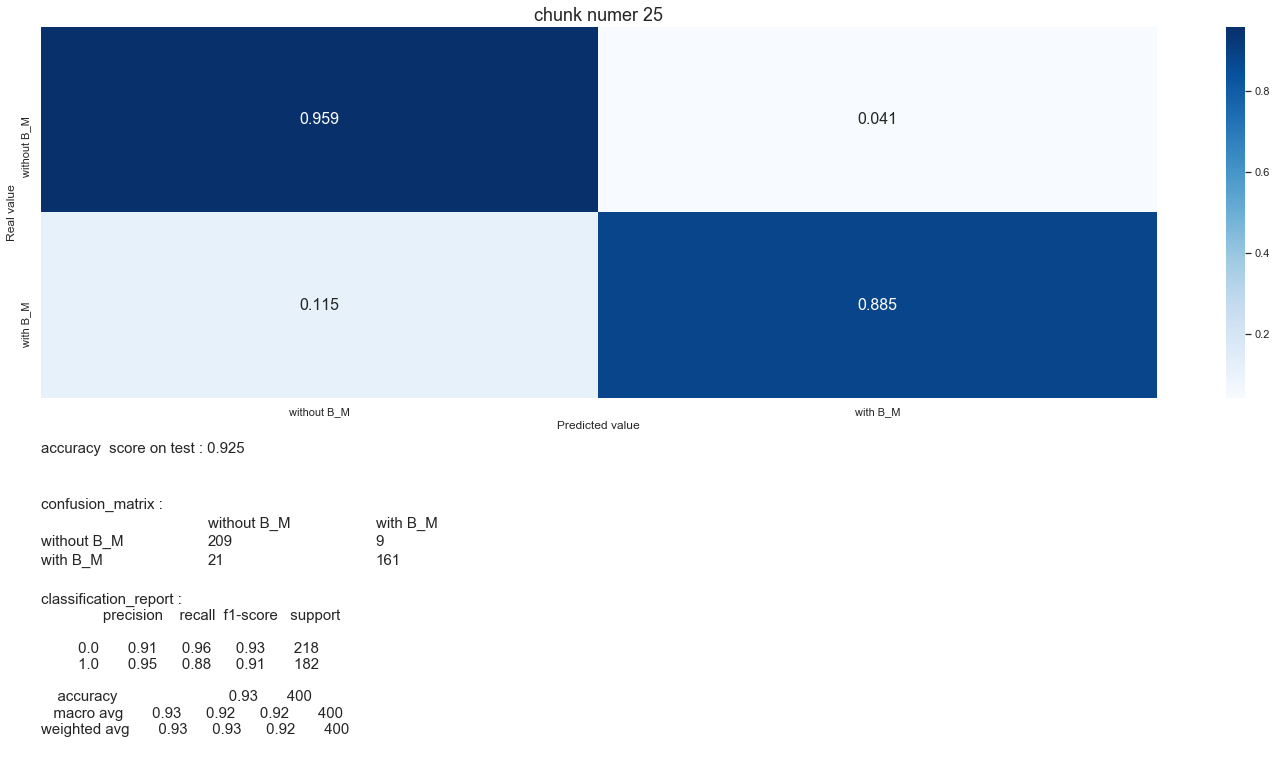

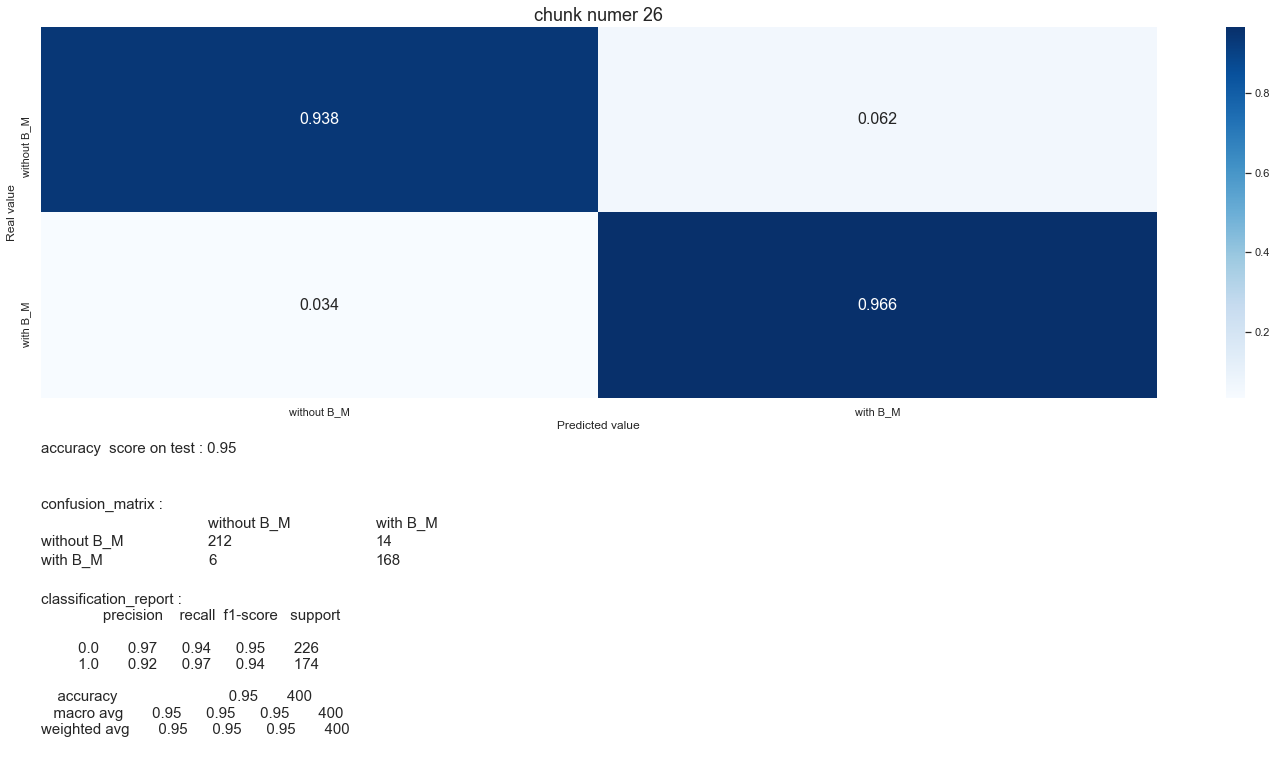

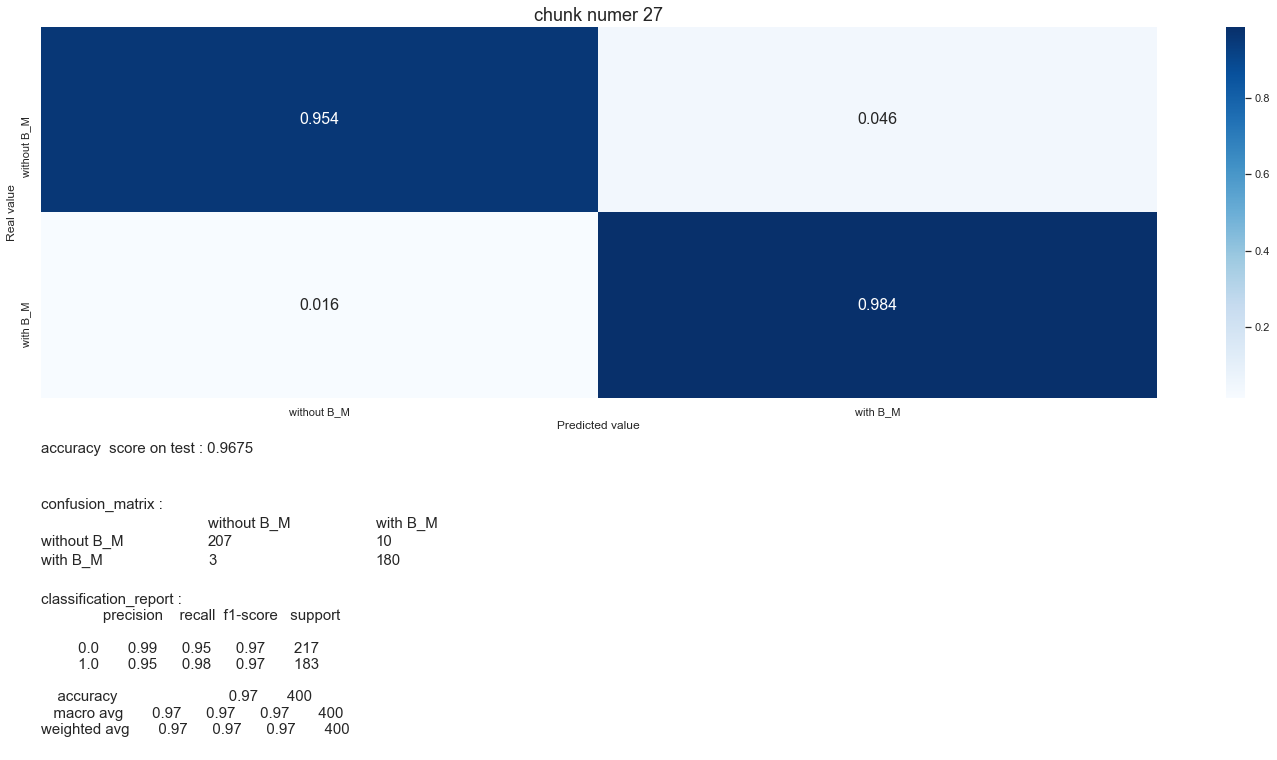

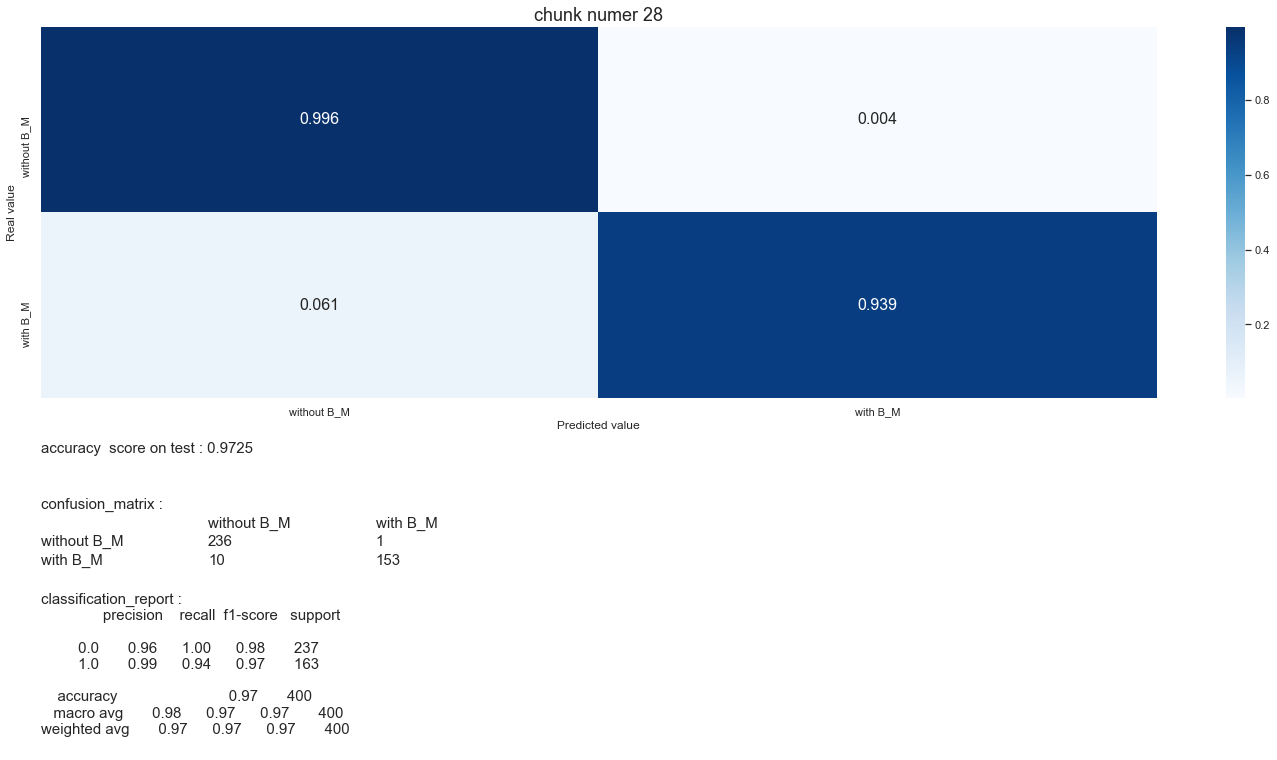

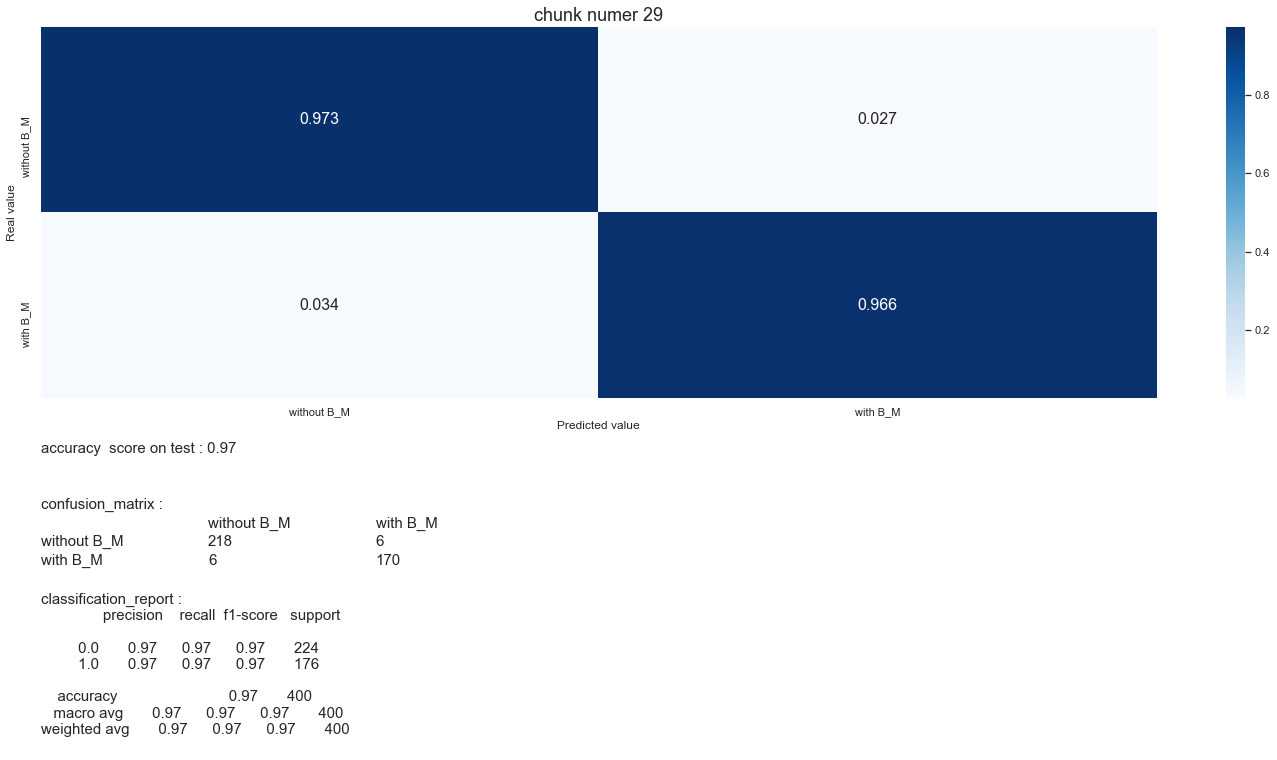

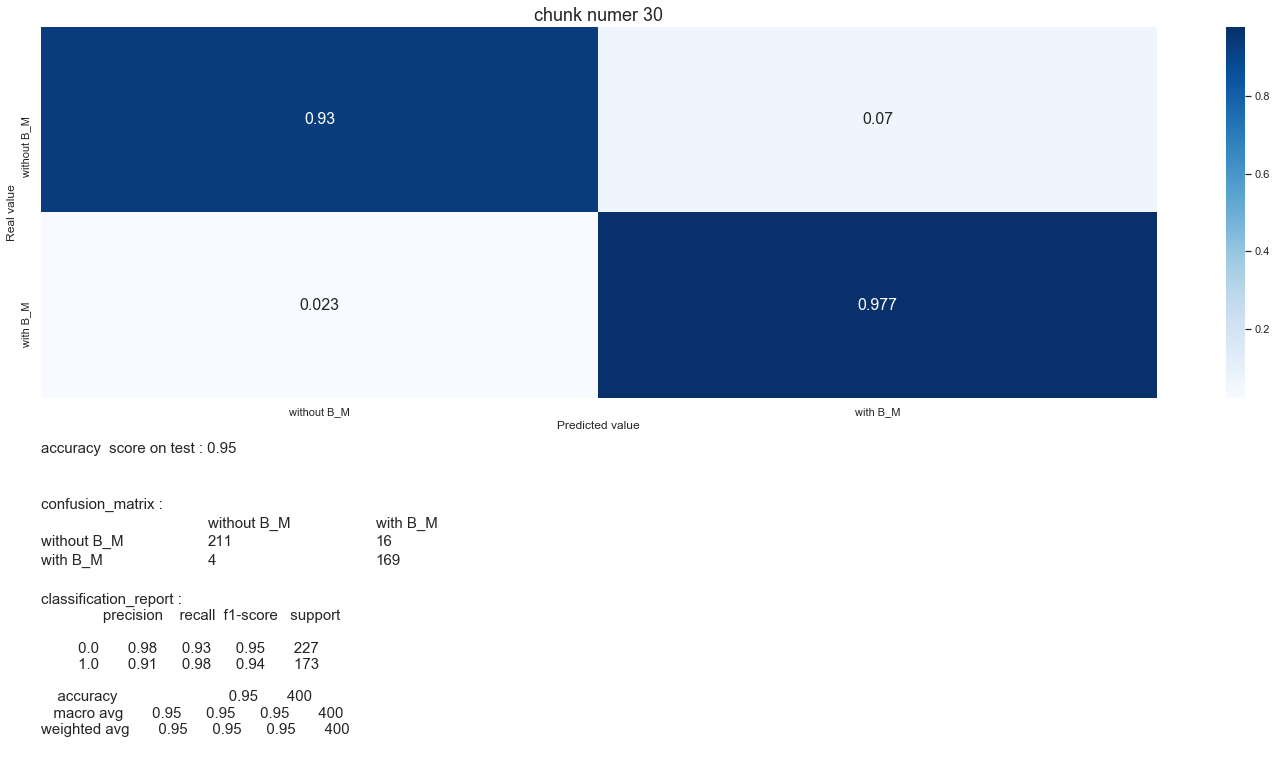

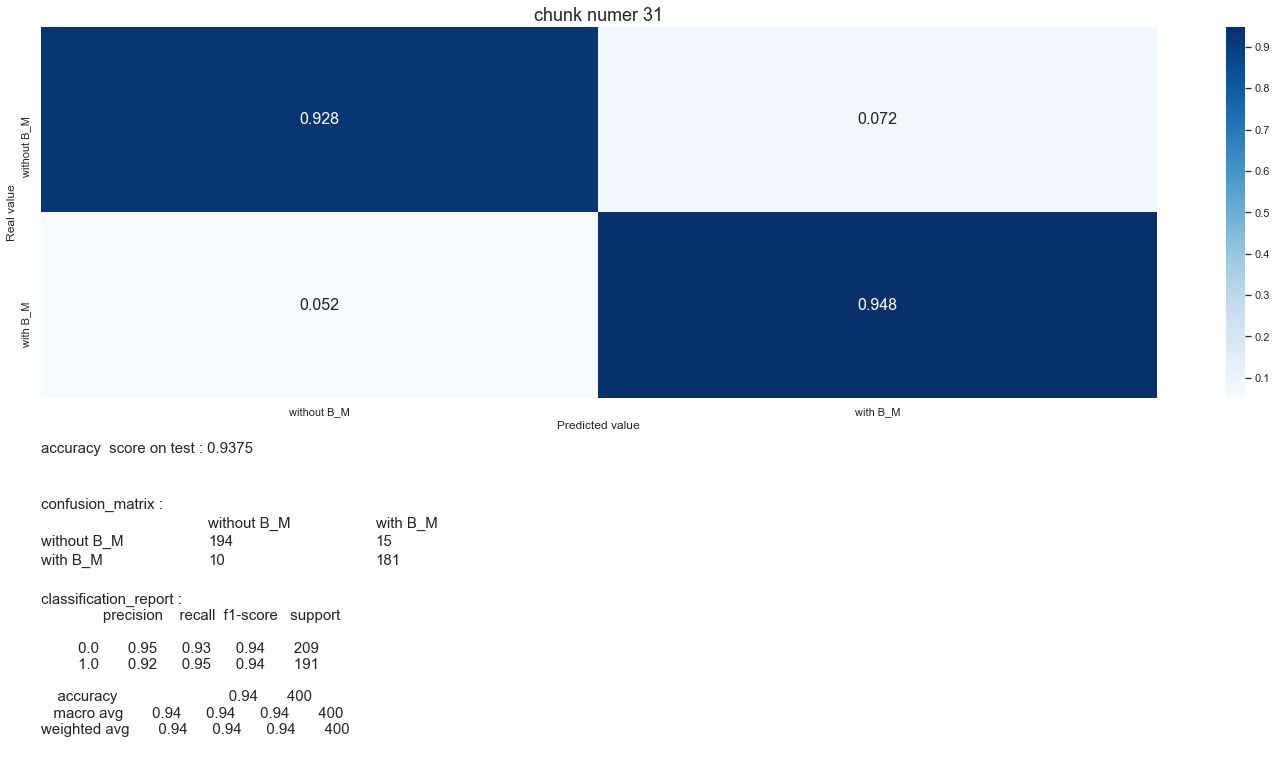

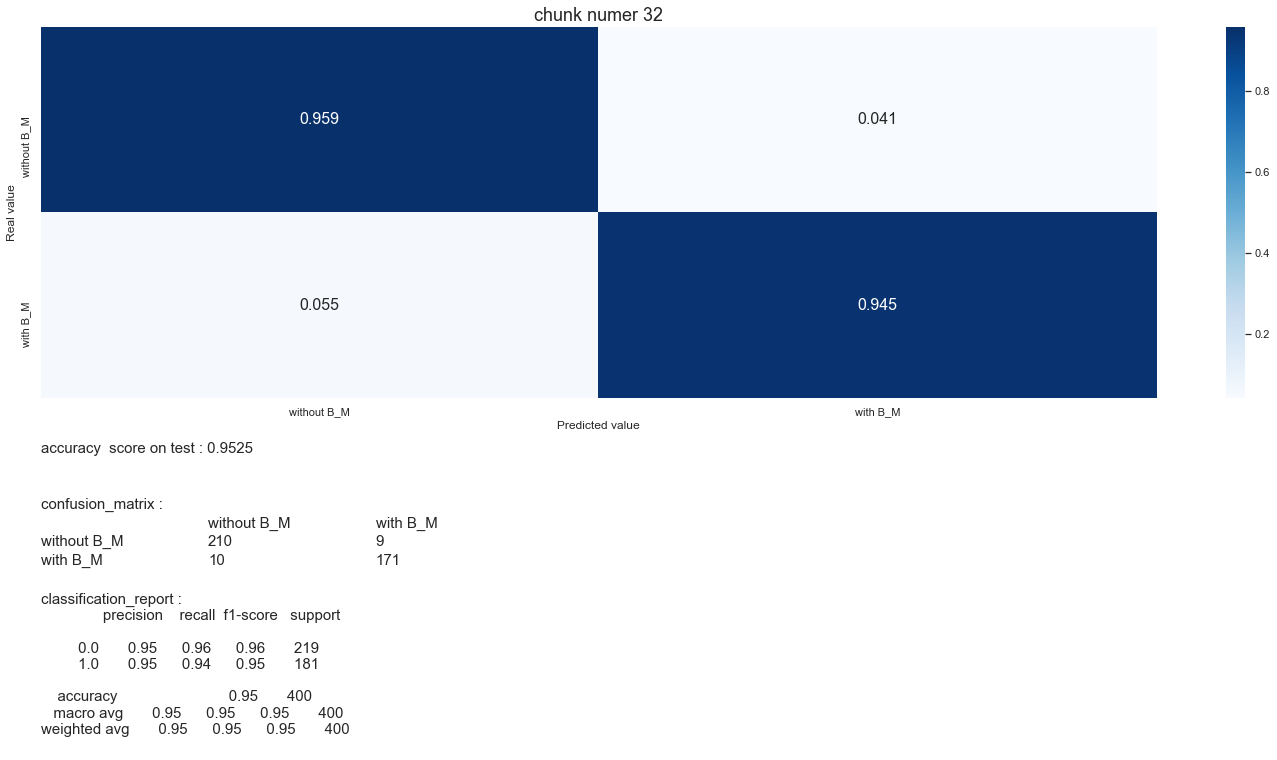

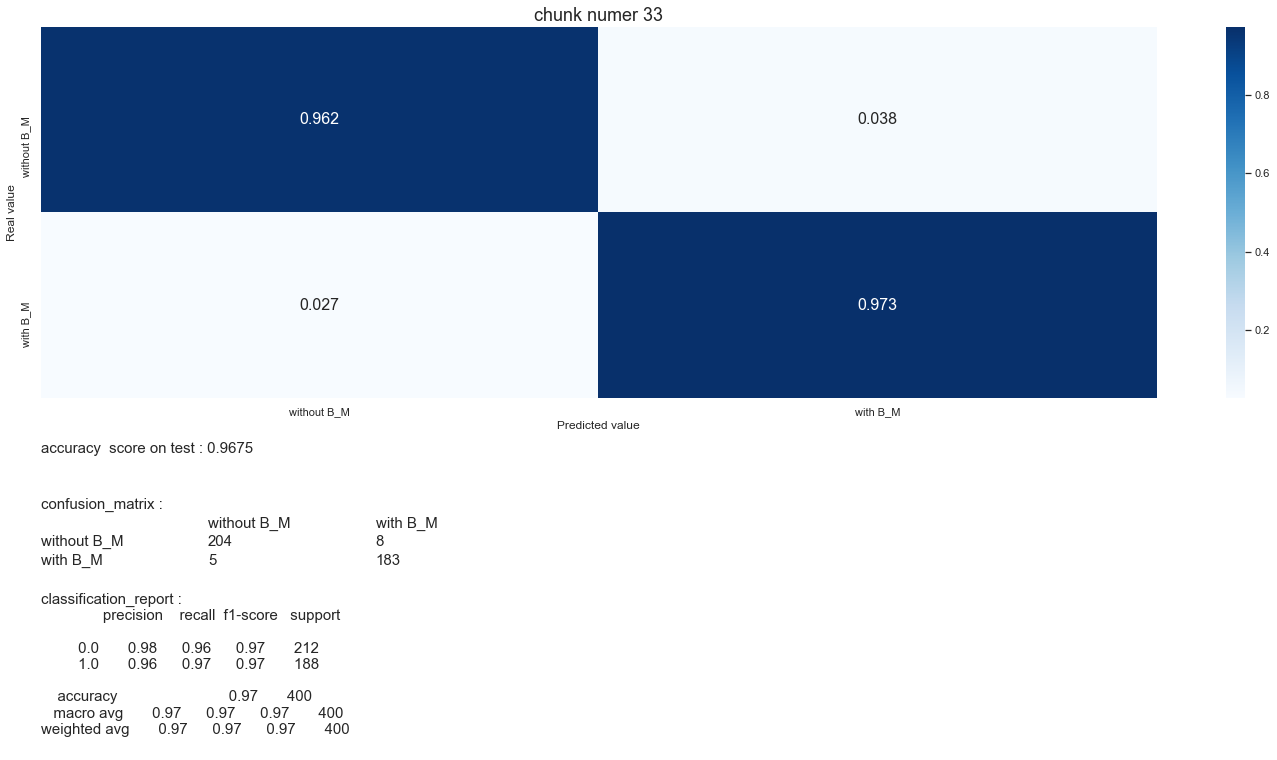

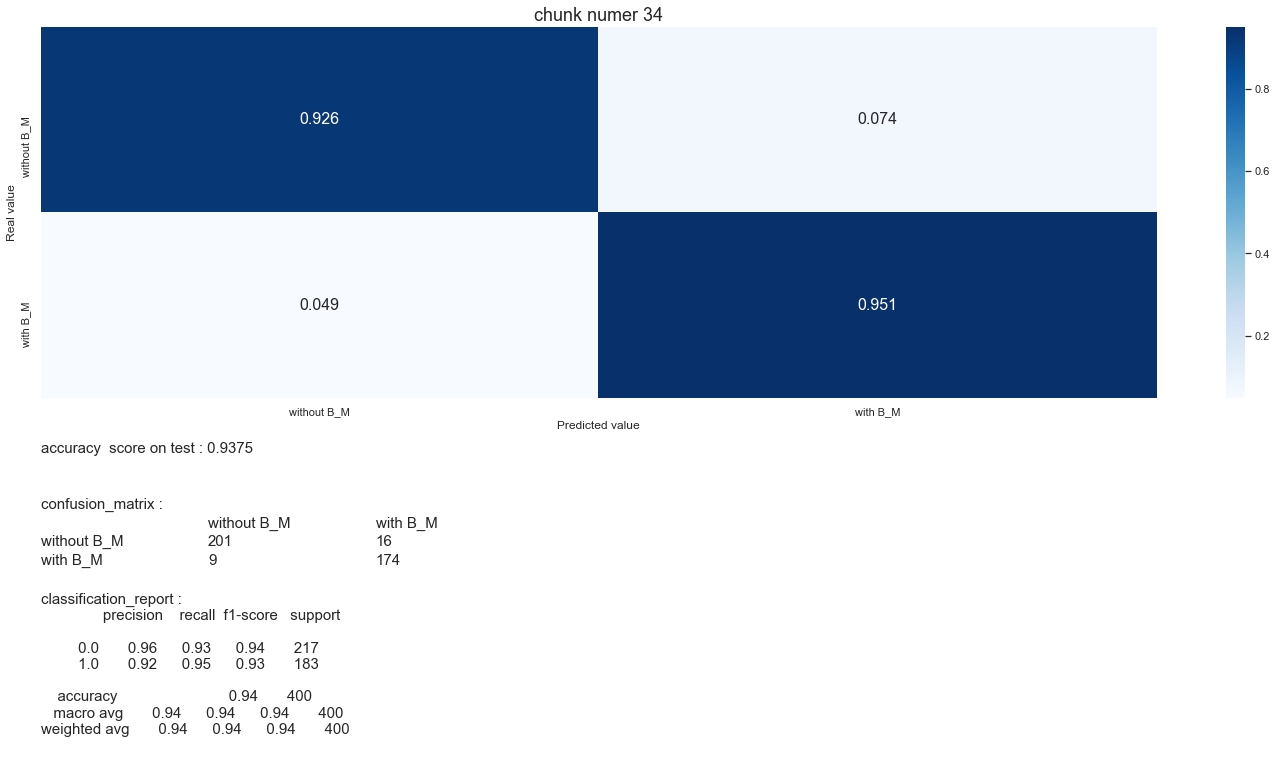

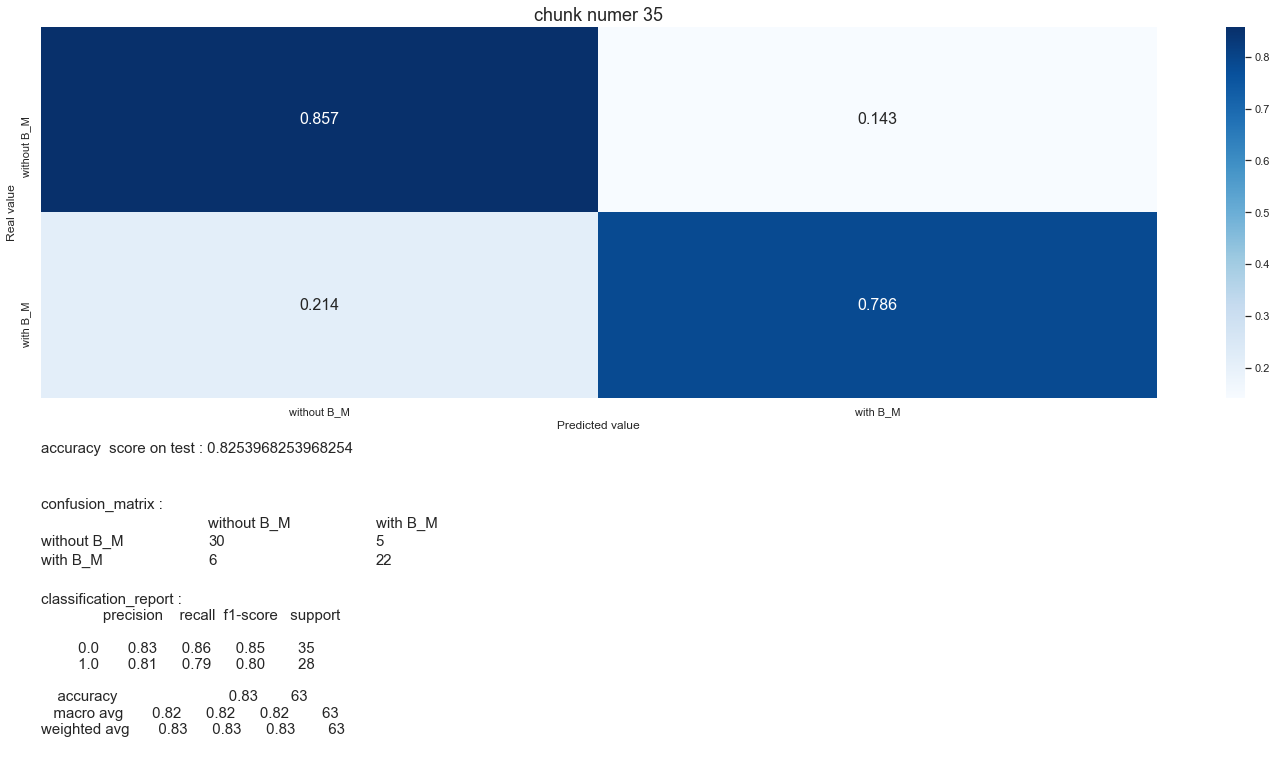

In [105]:
# prints(df)
for i,y_test in enumerate(df['y_test'].tolist()):
    y_test = list(map(_replaceitem, y_test))
    y_predict = list(map(_replaceitem, df['y_predict'][i].tolist()))
    print_result(y_predict, y_test , "chunk numer "+str(i) ,'Blues')

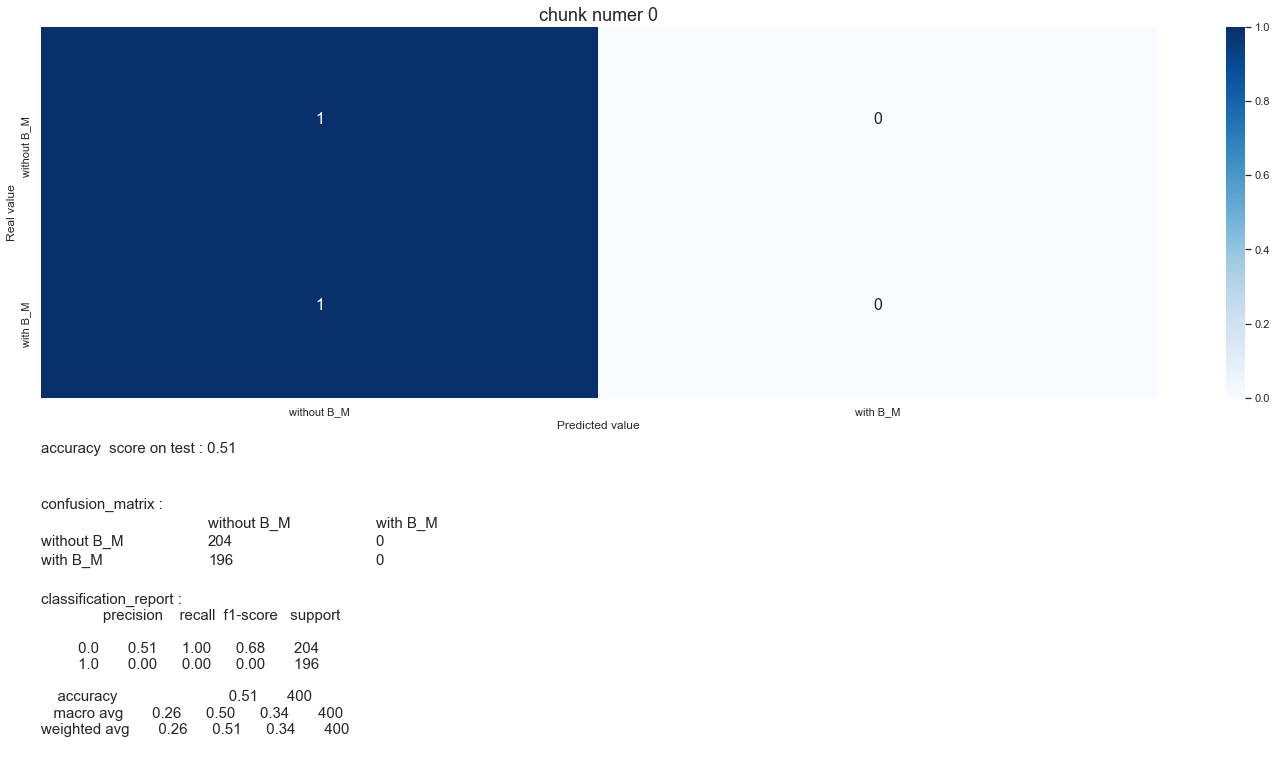

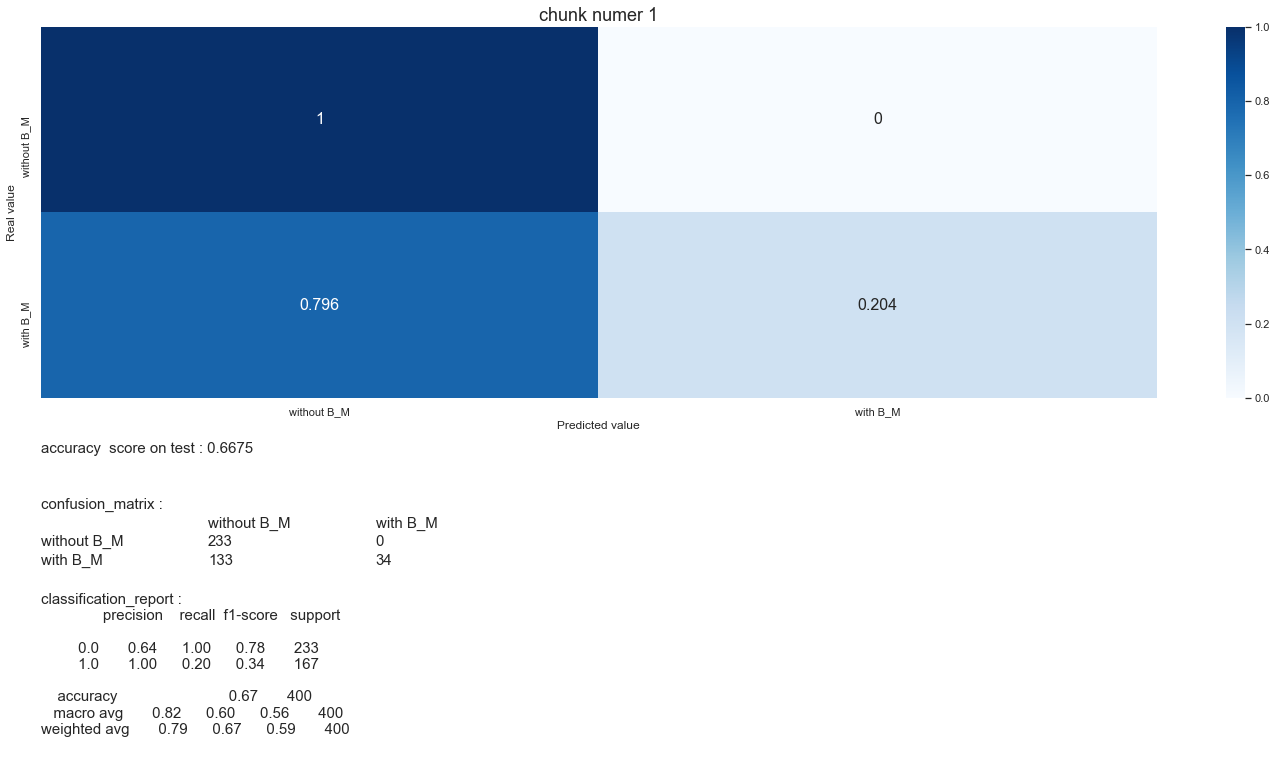

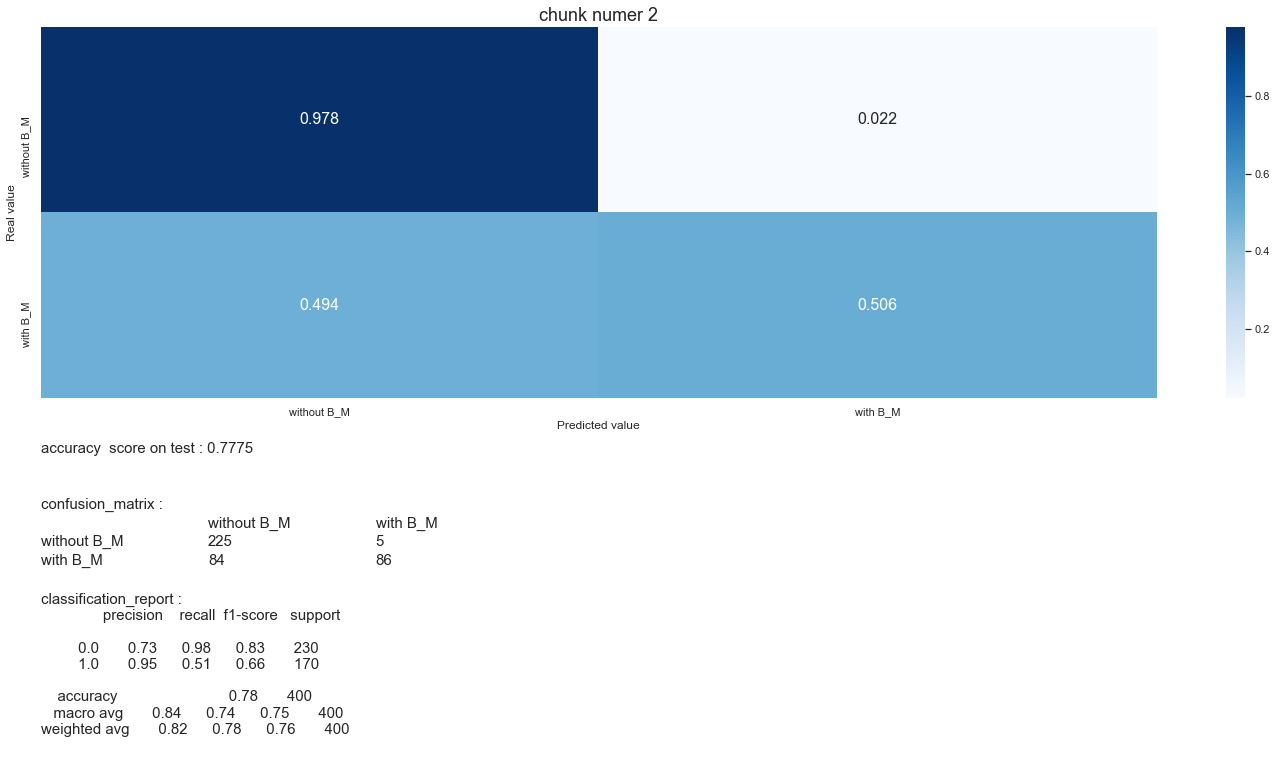

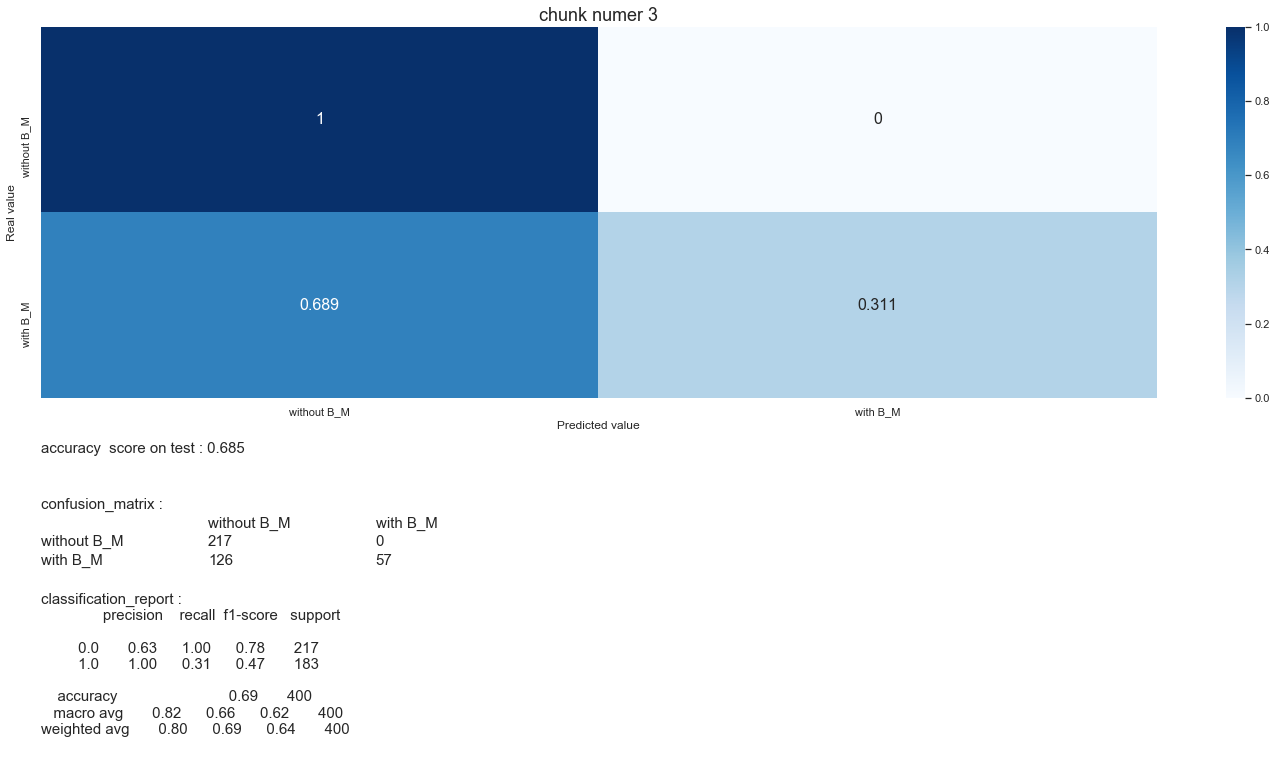

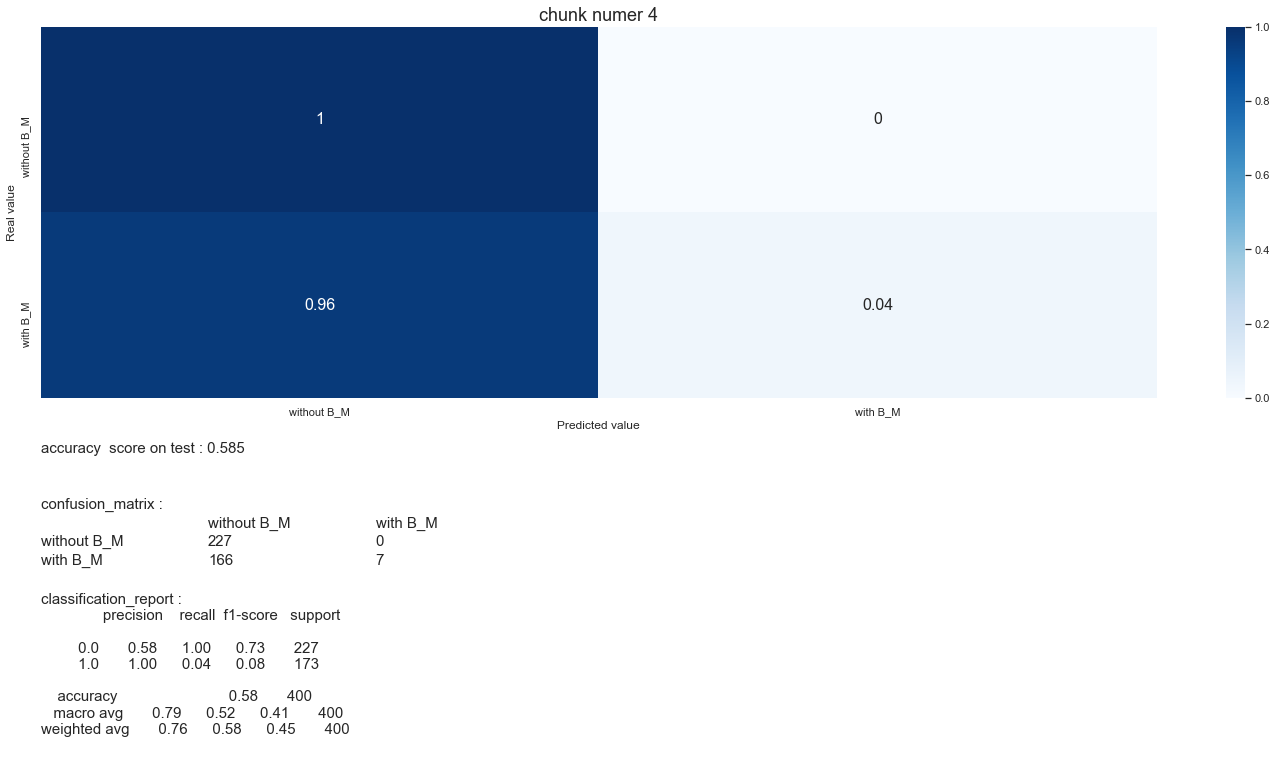

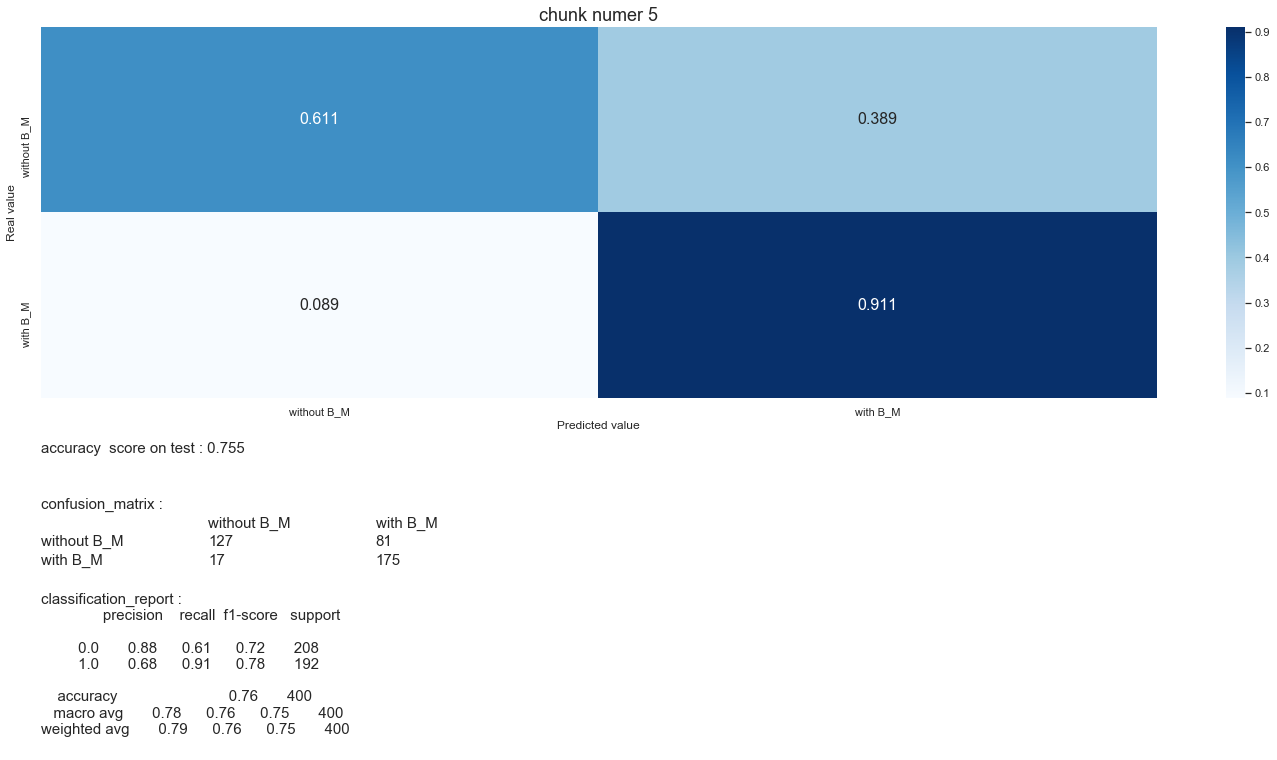

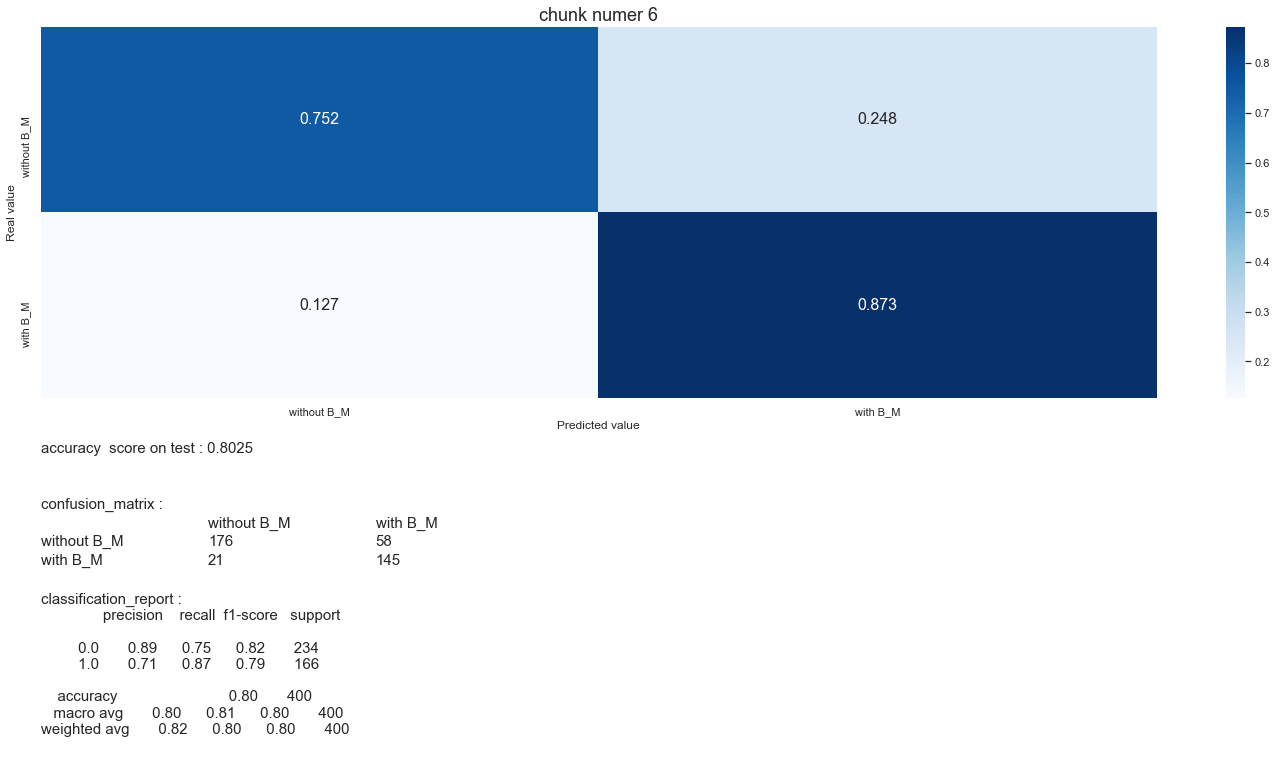

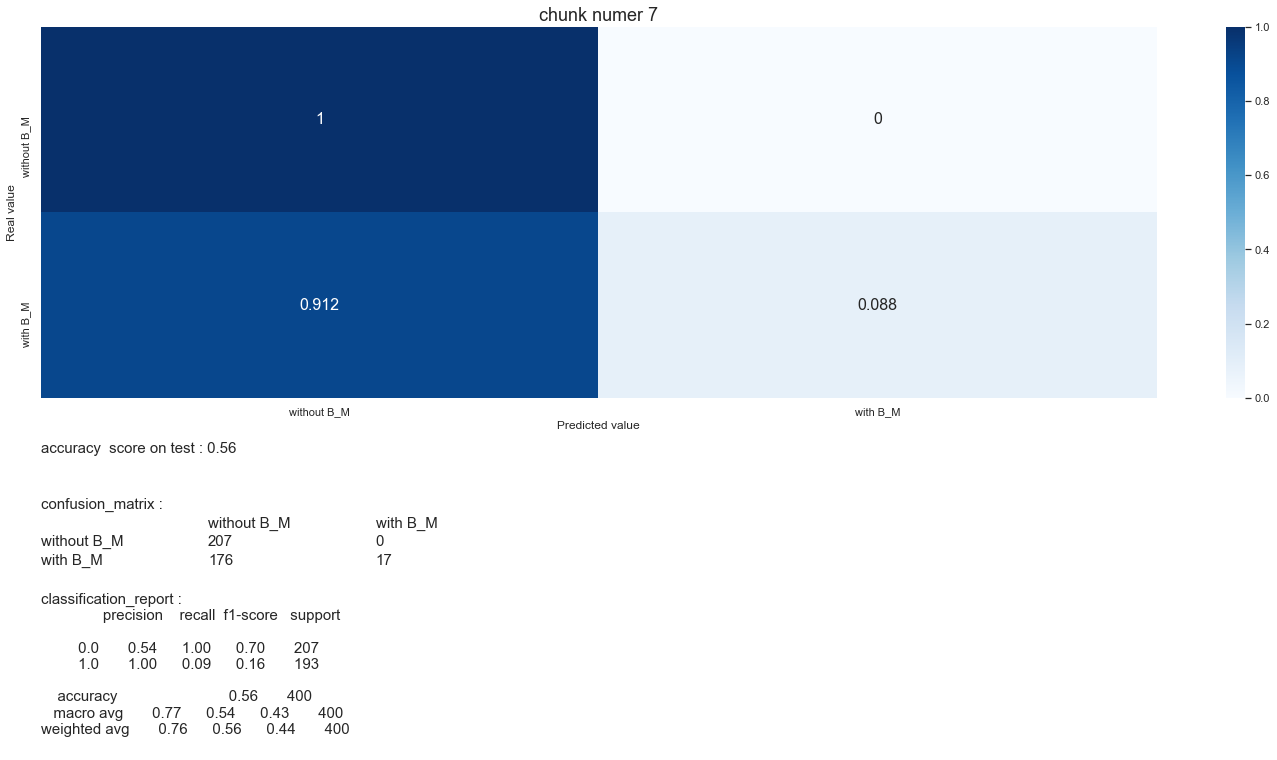

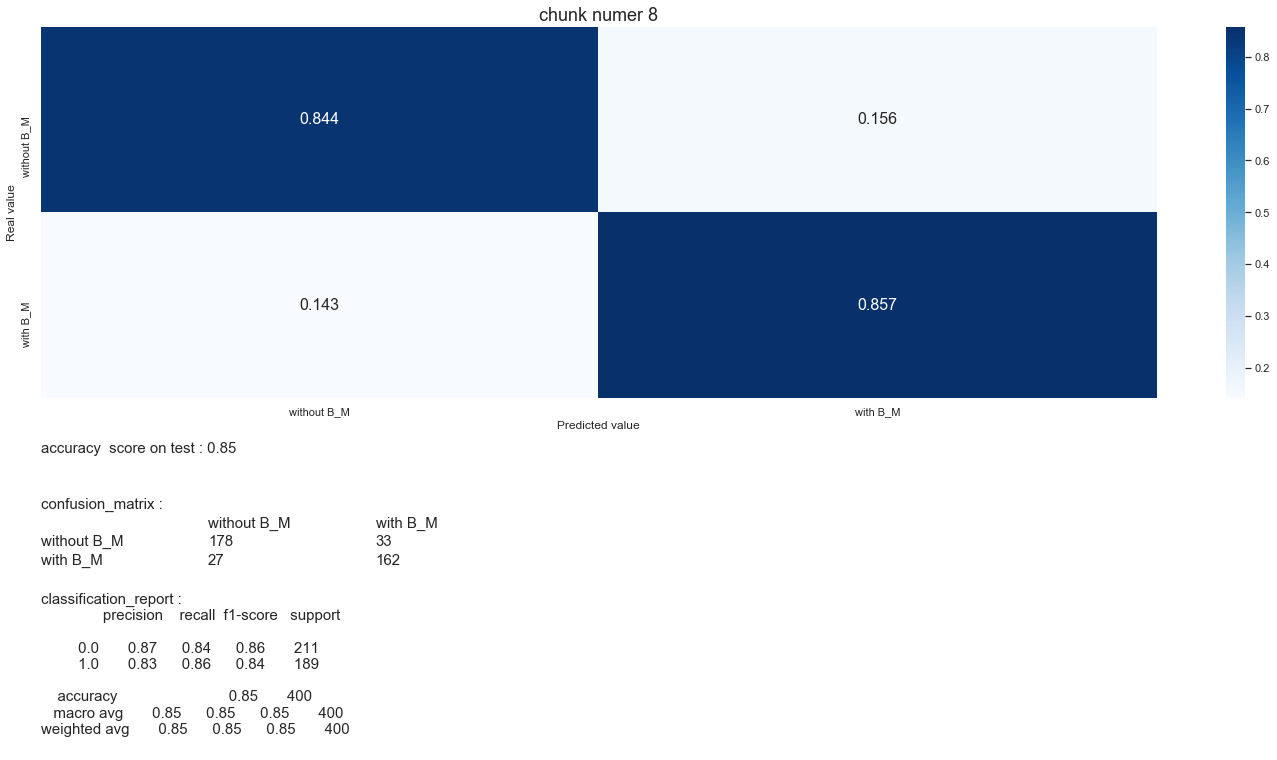

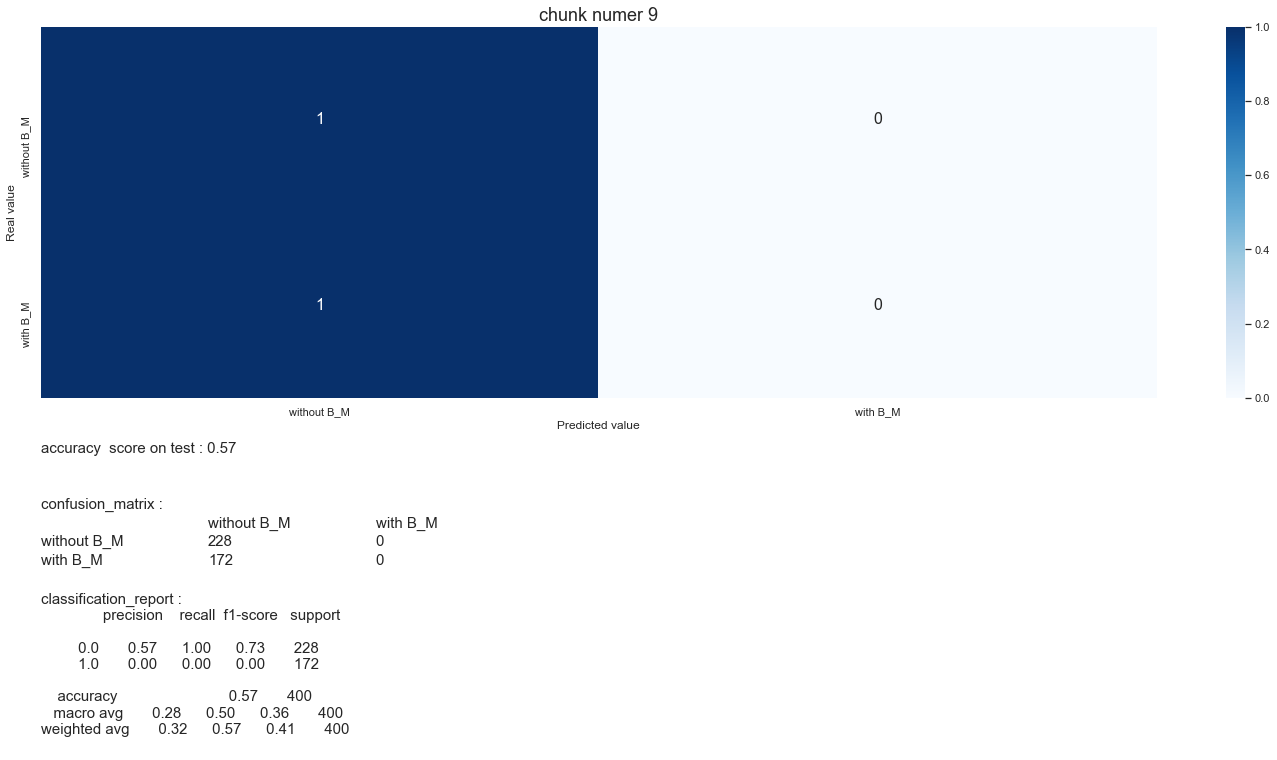

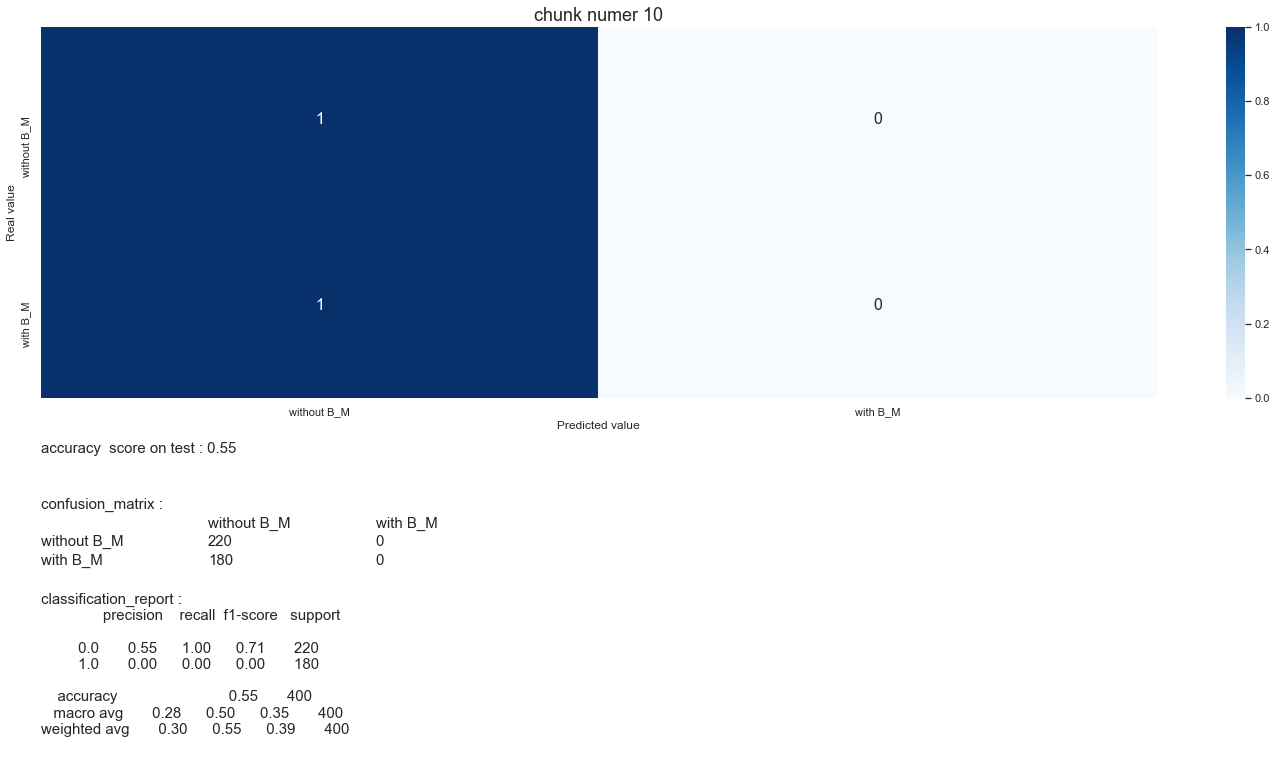

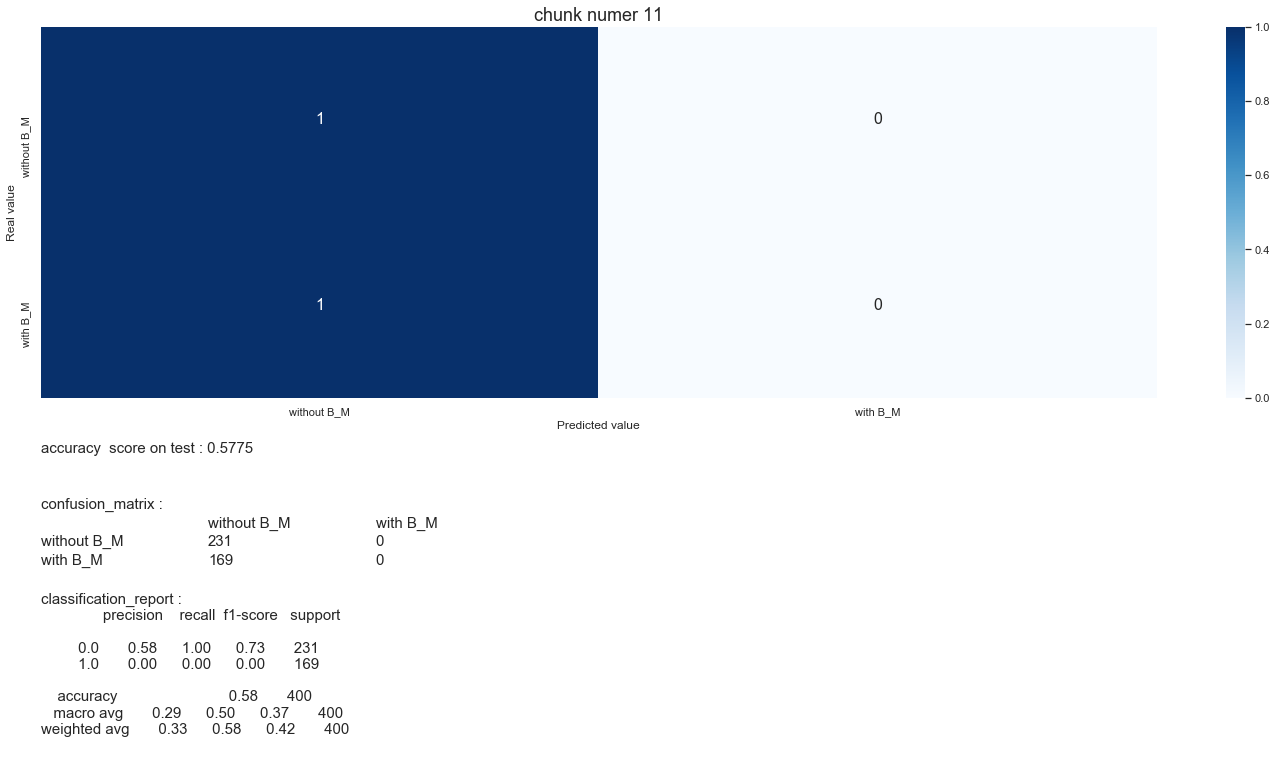

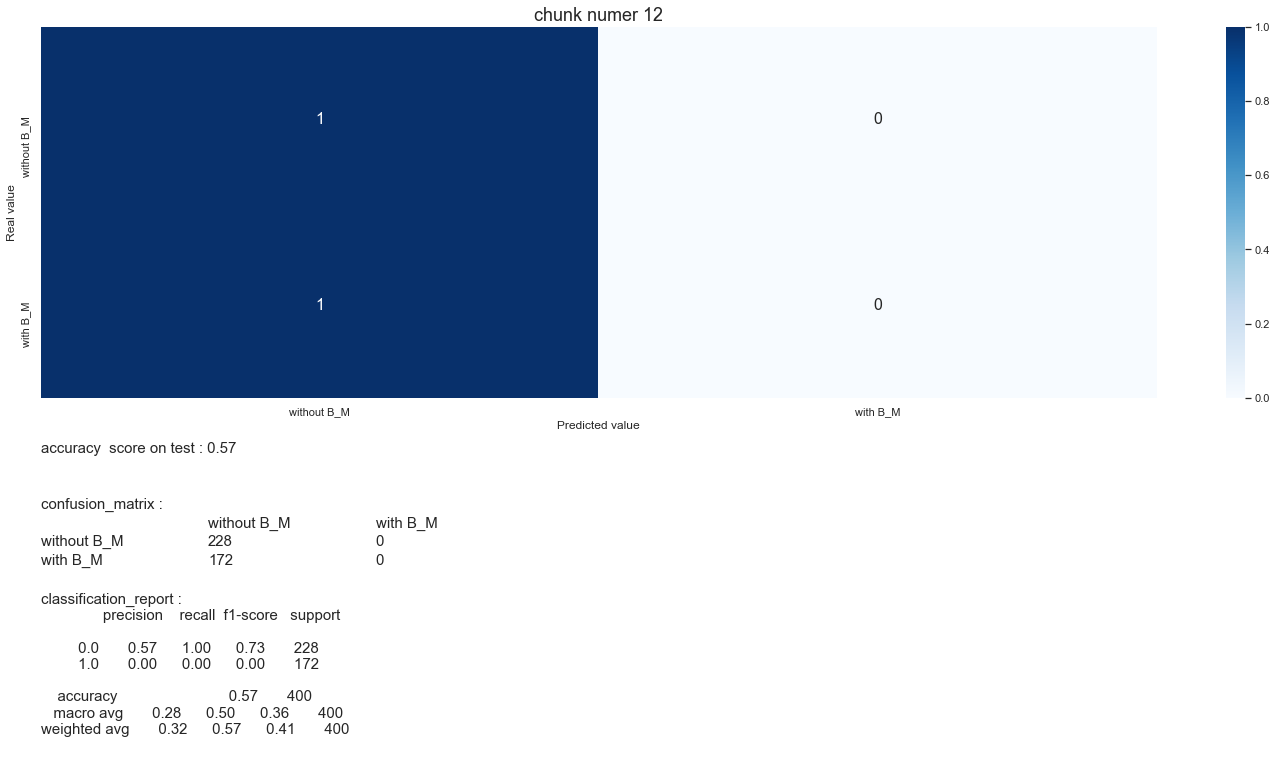

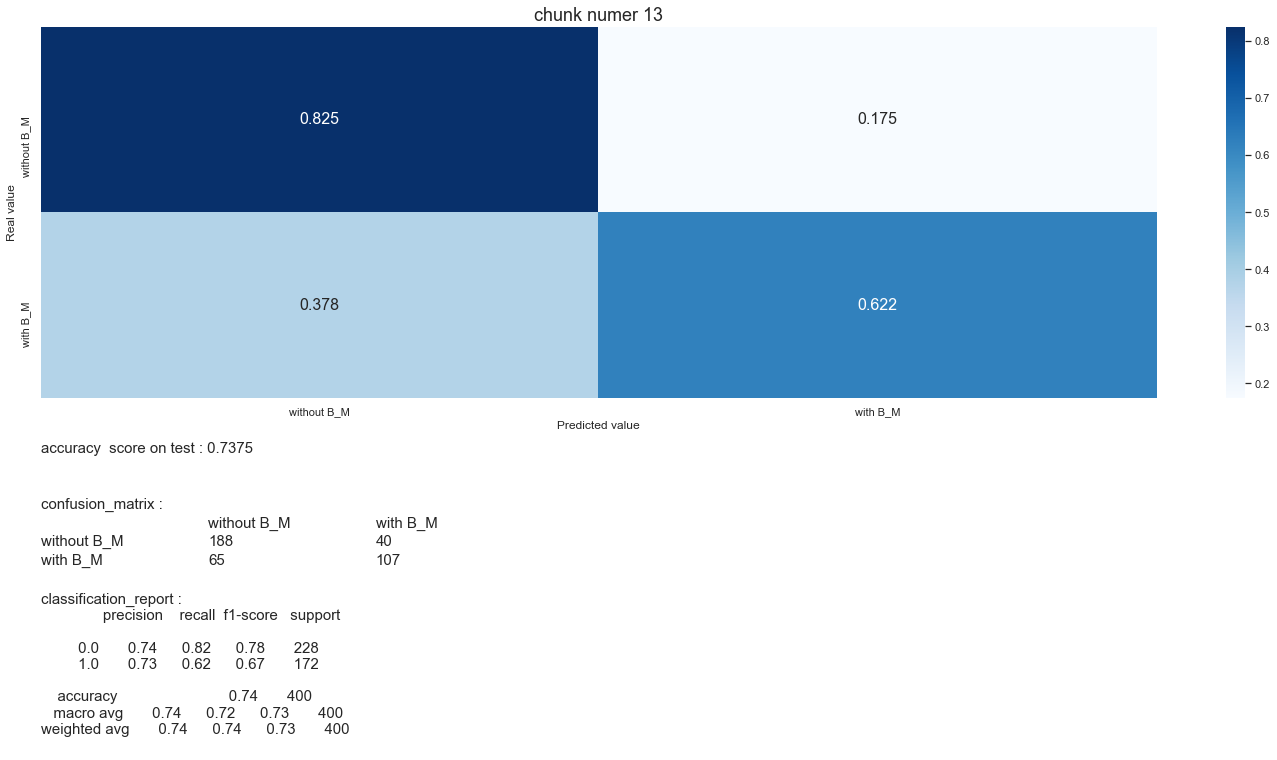

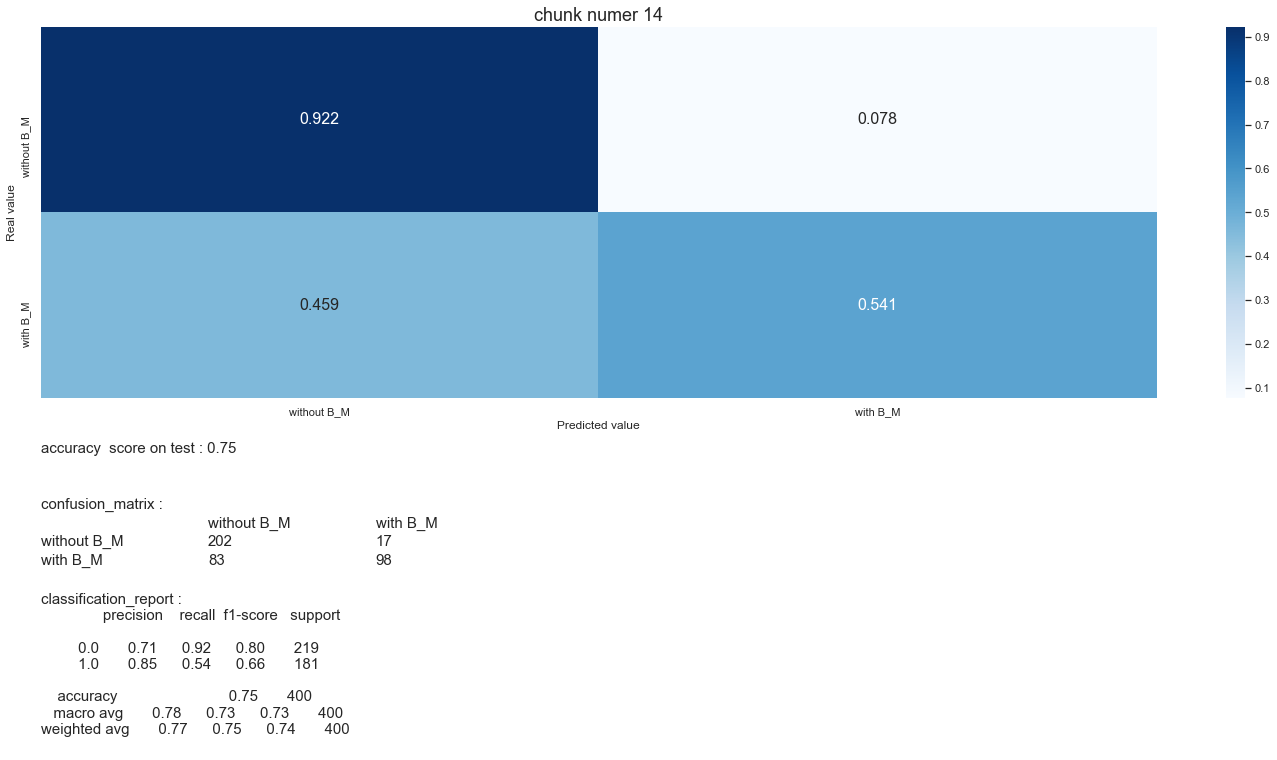

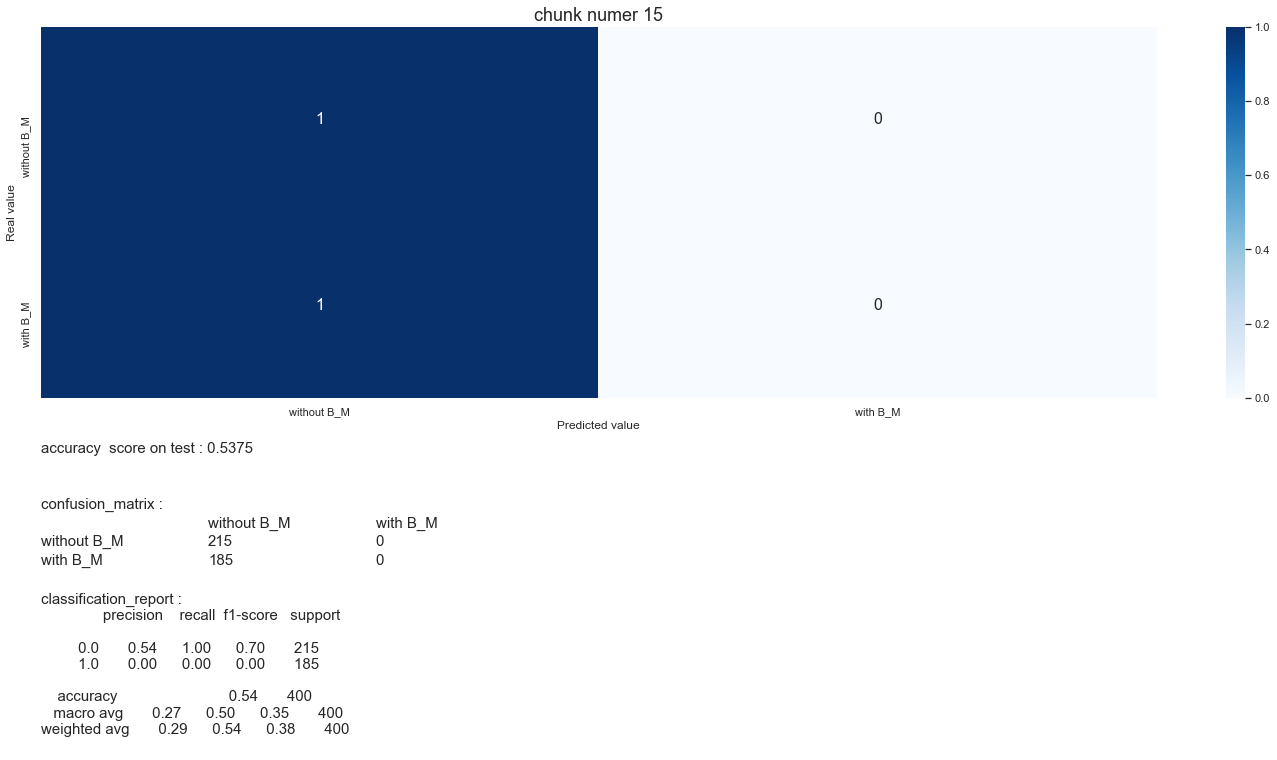

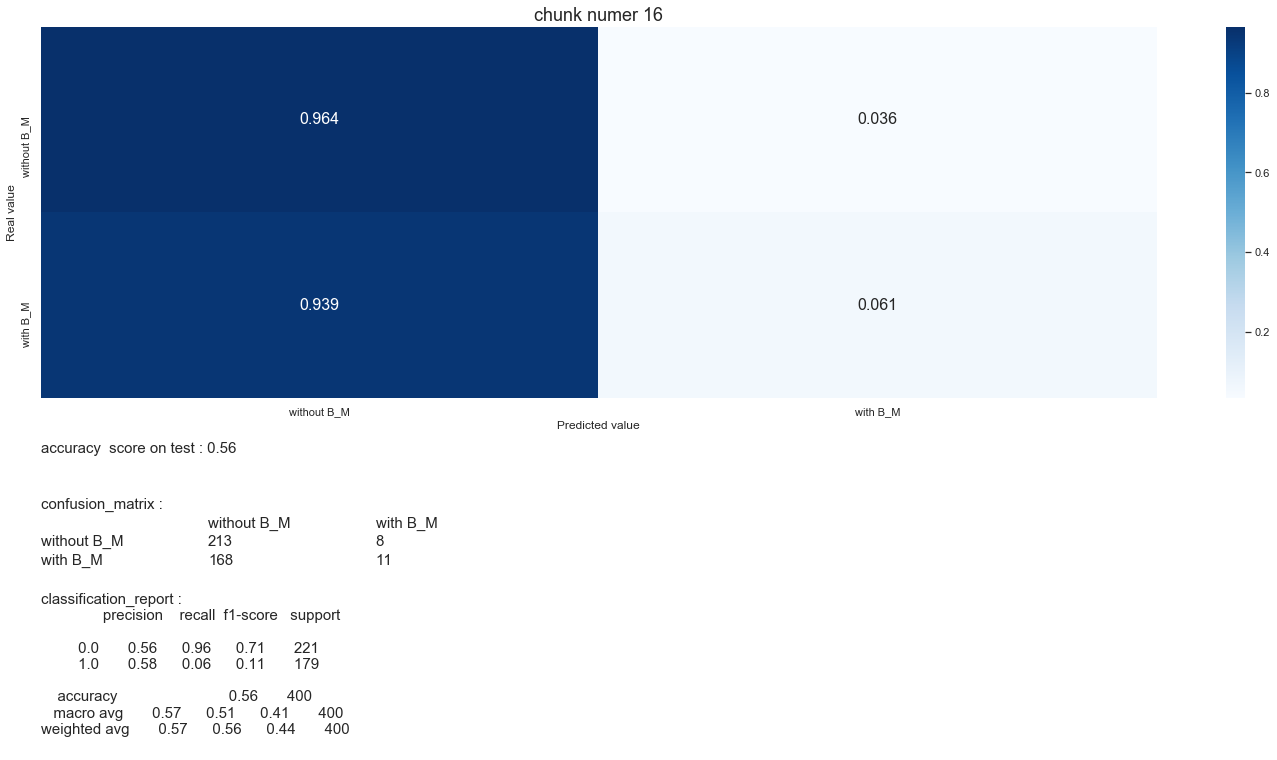

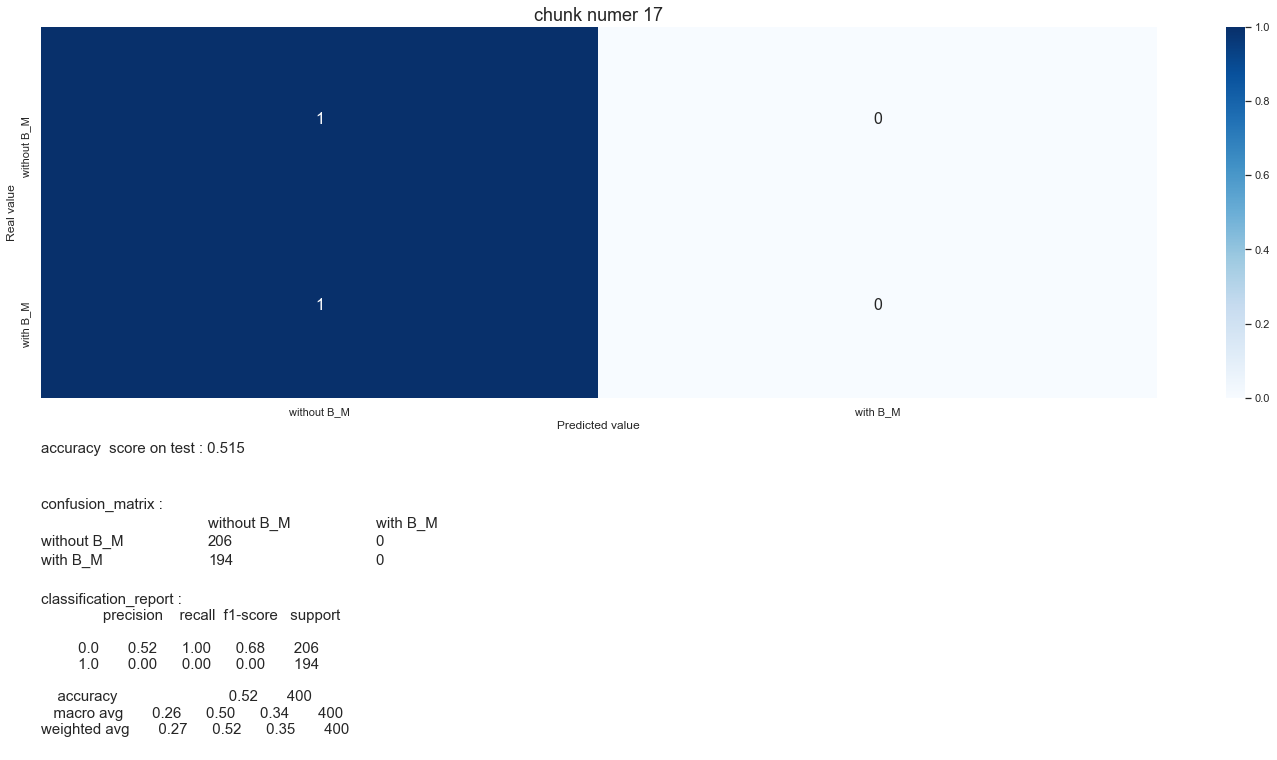

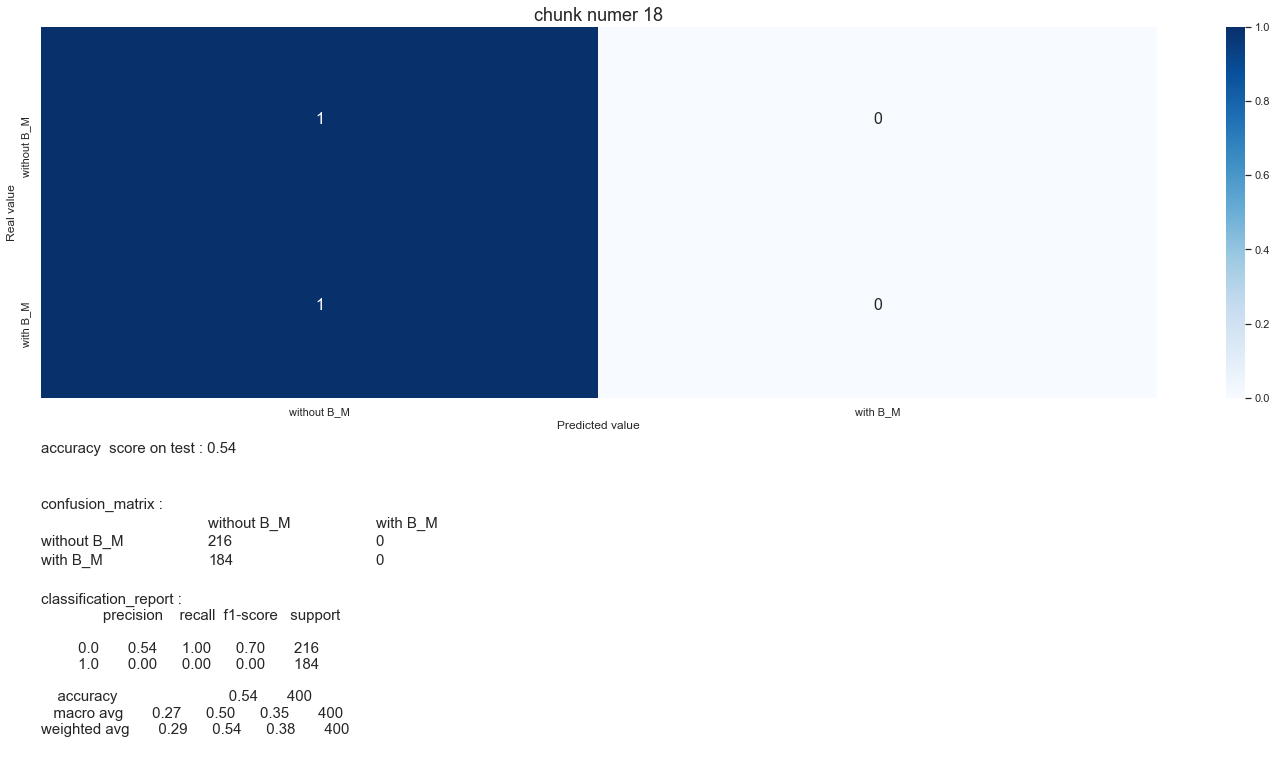

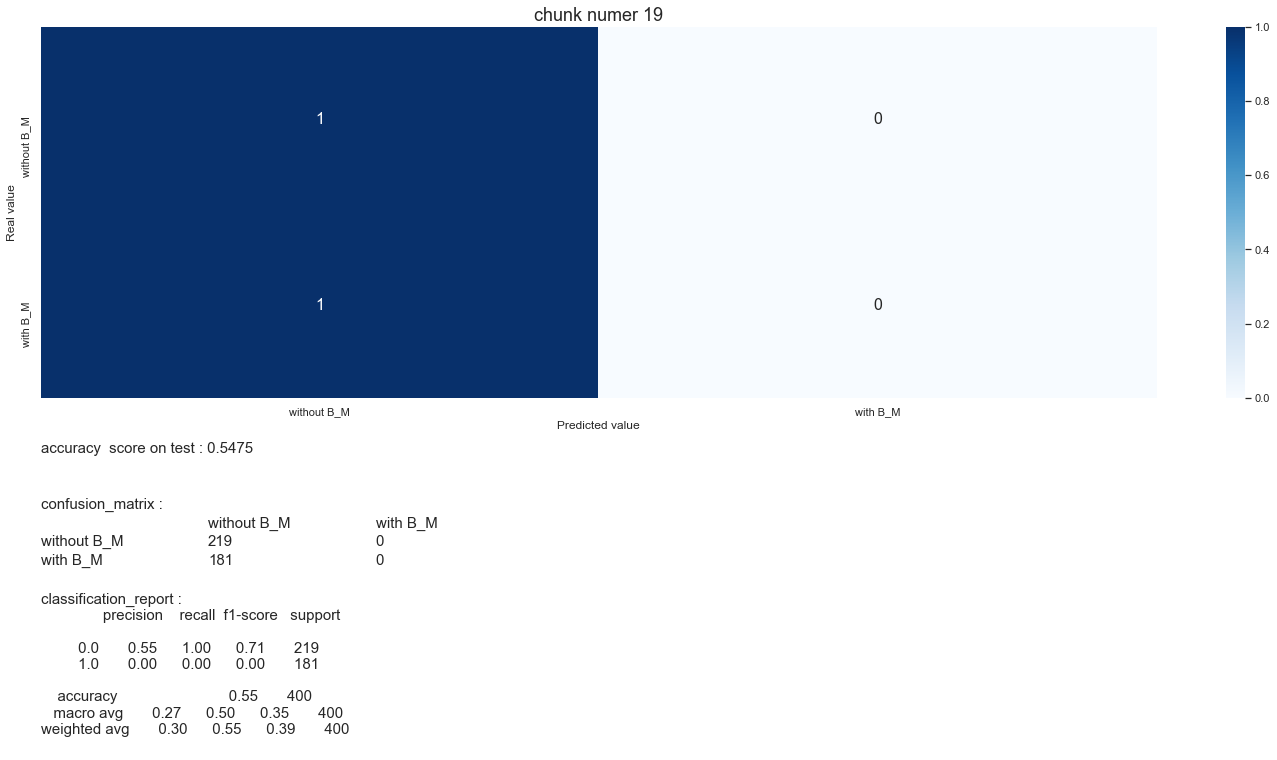

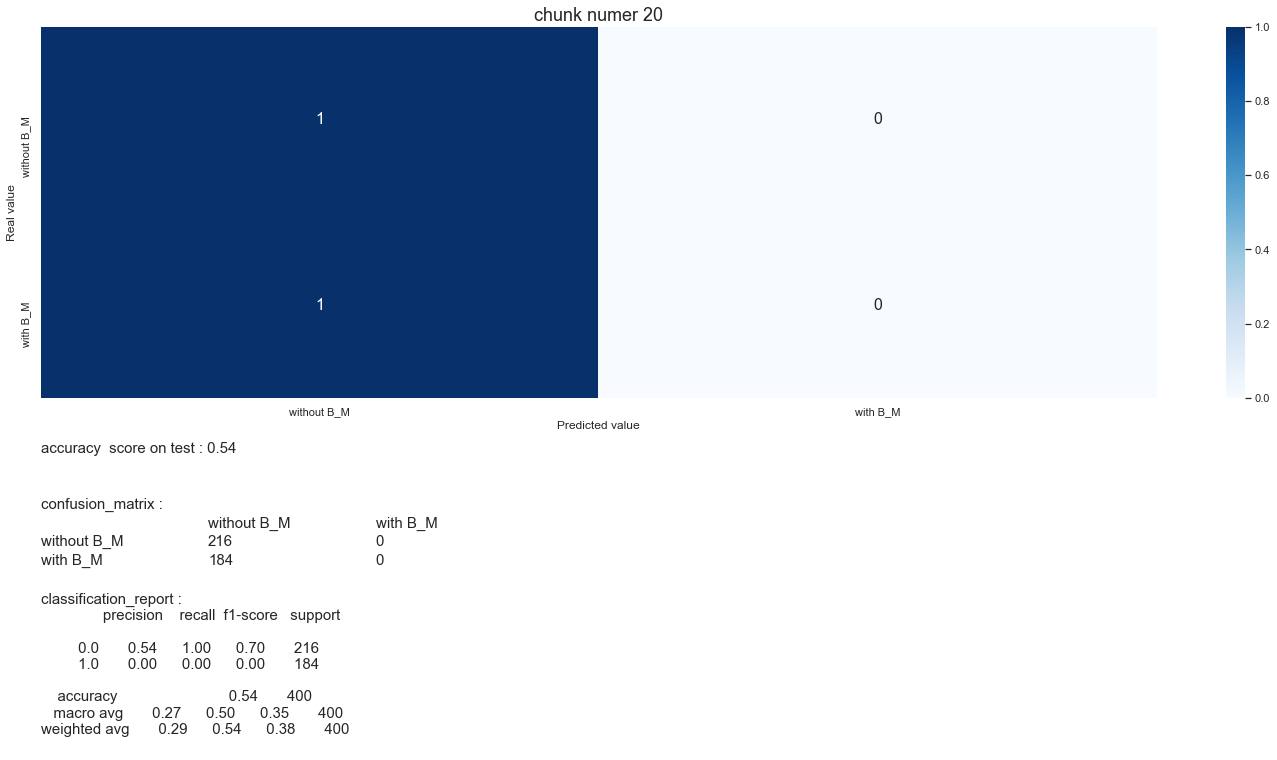

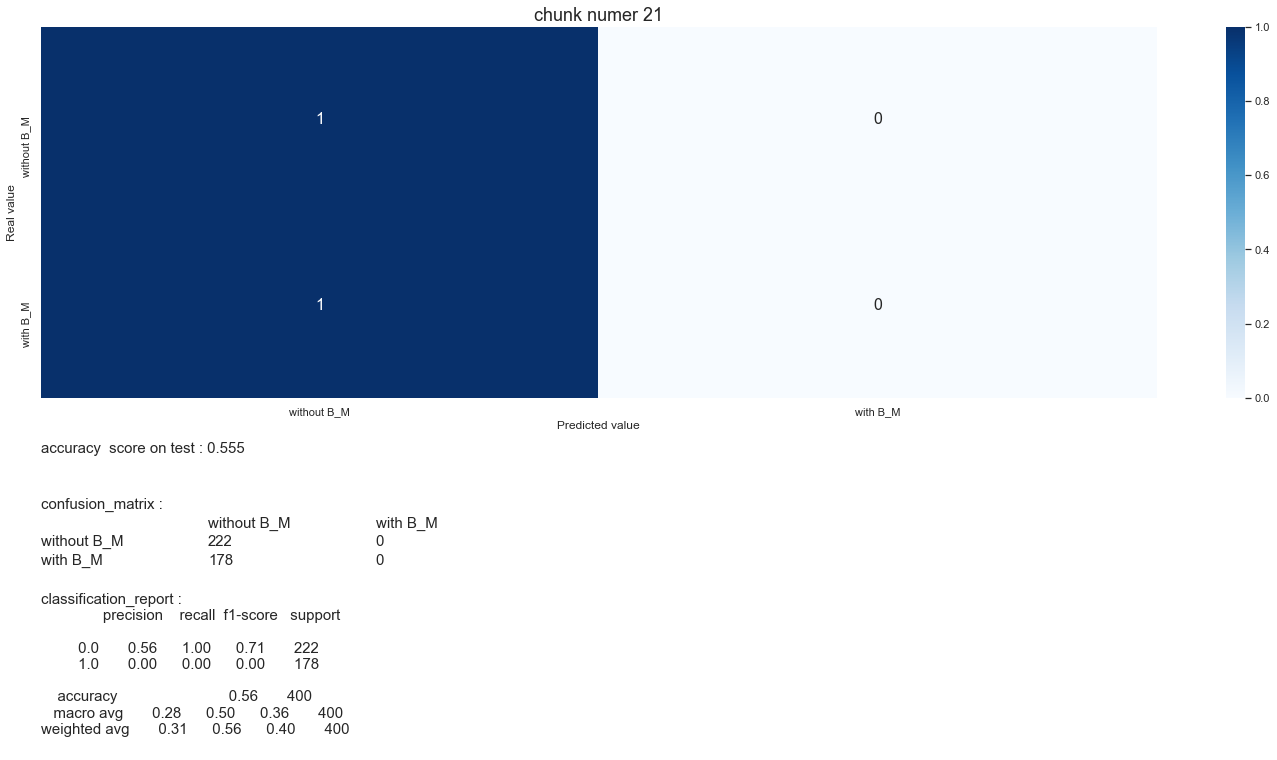

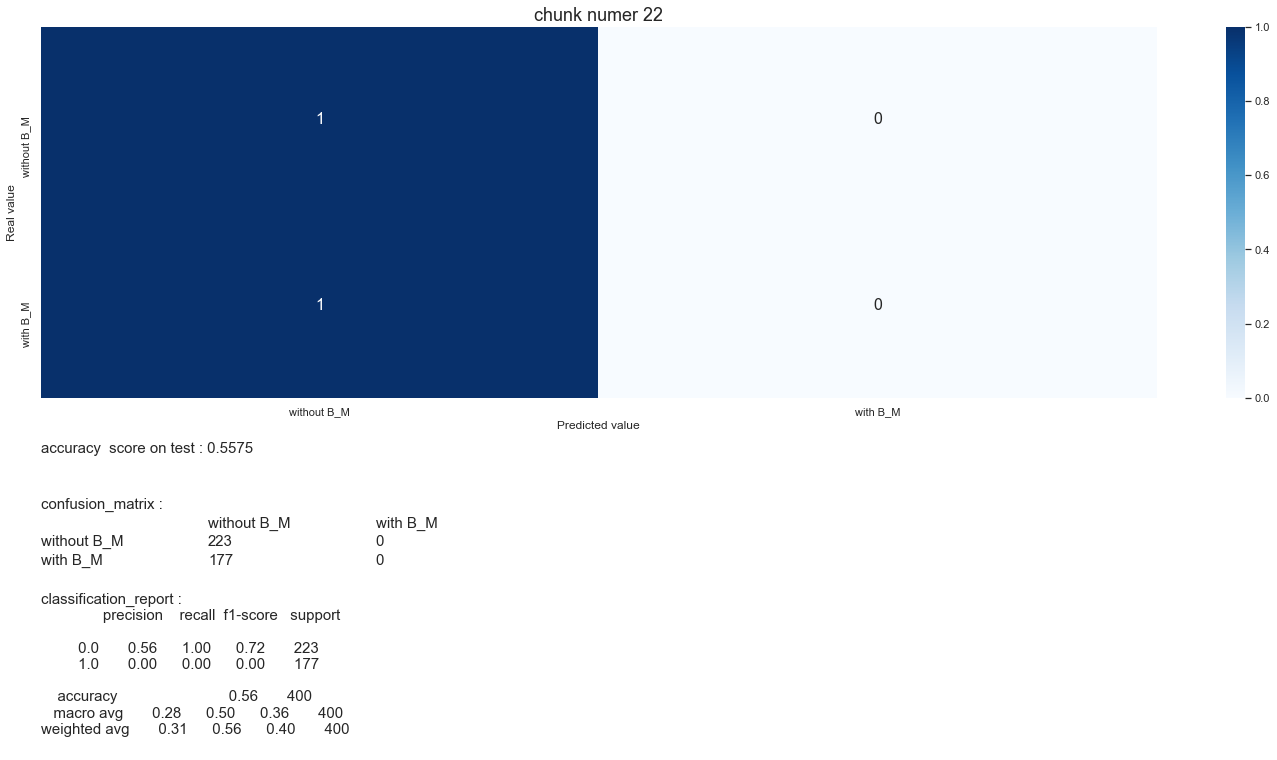

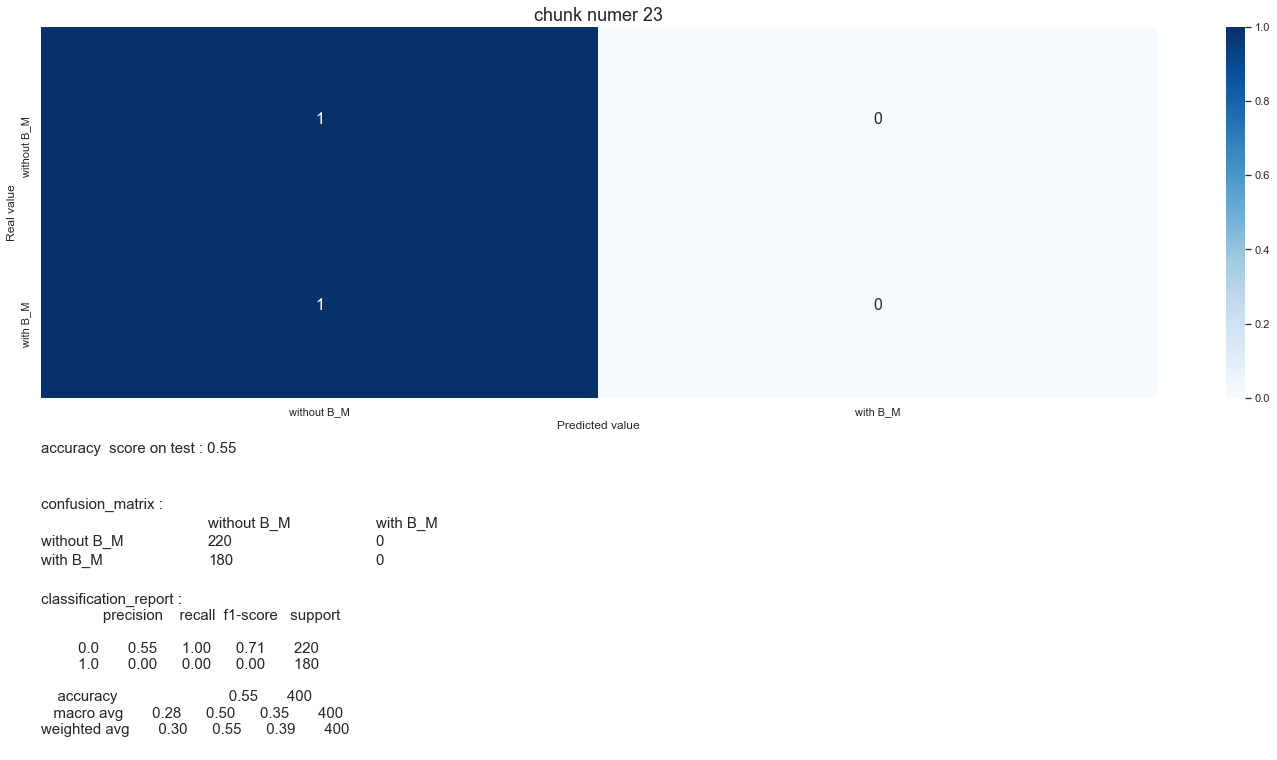

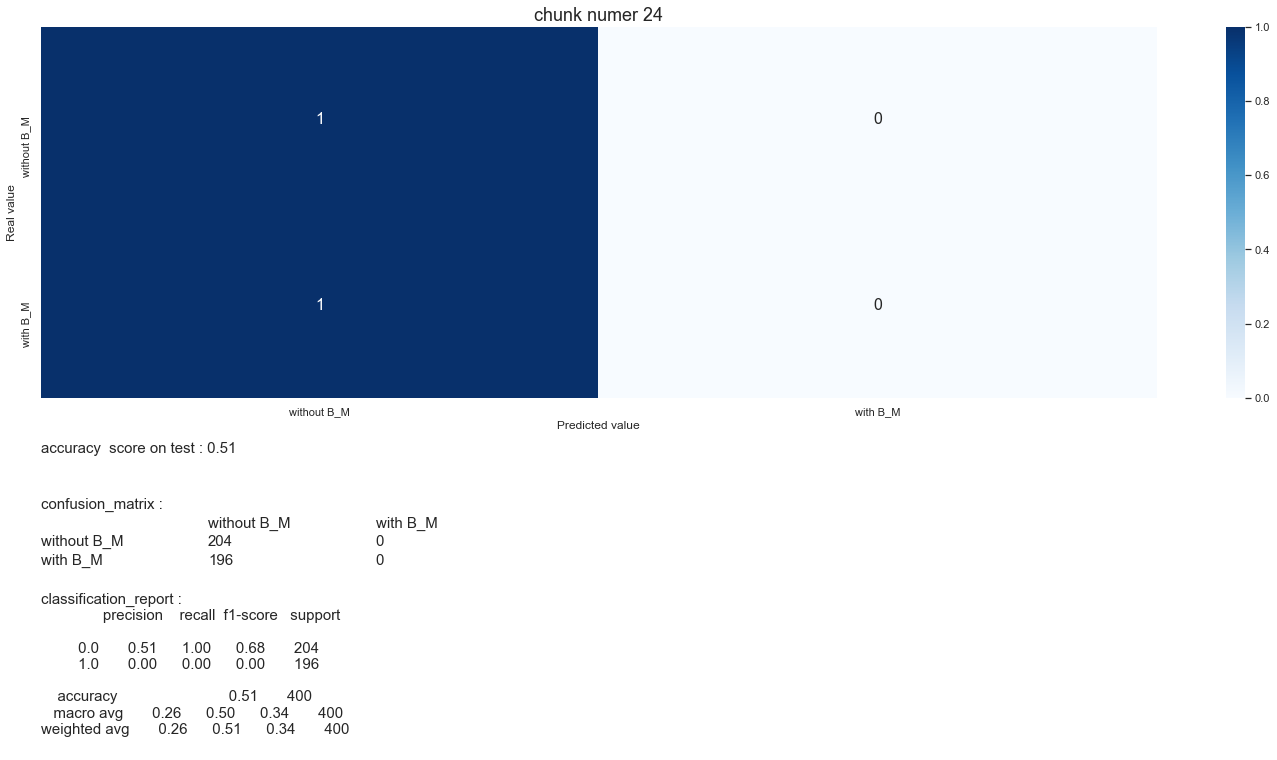

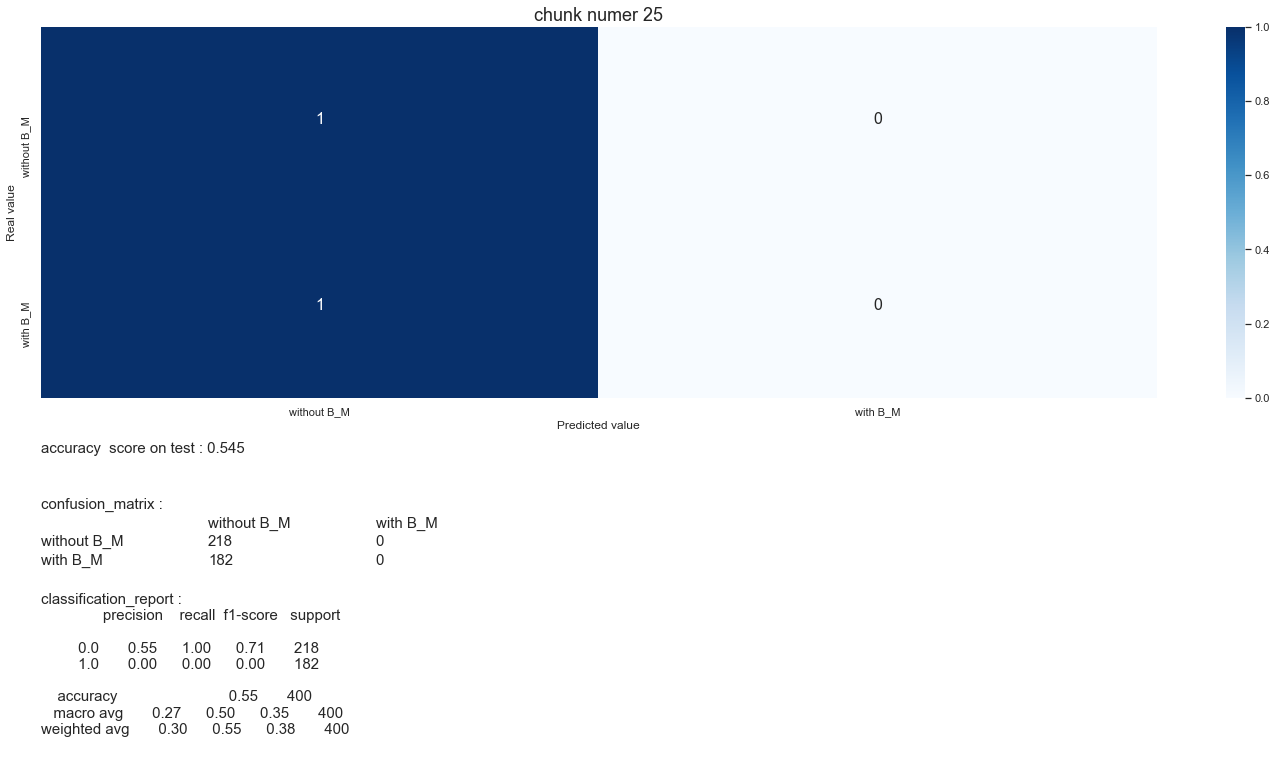

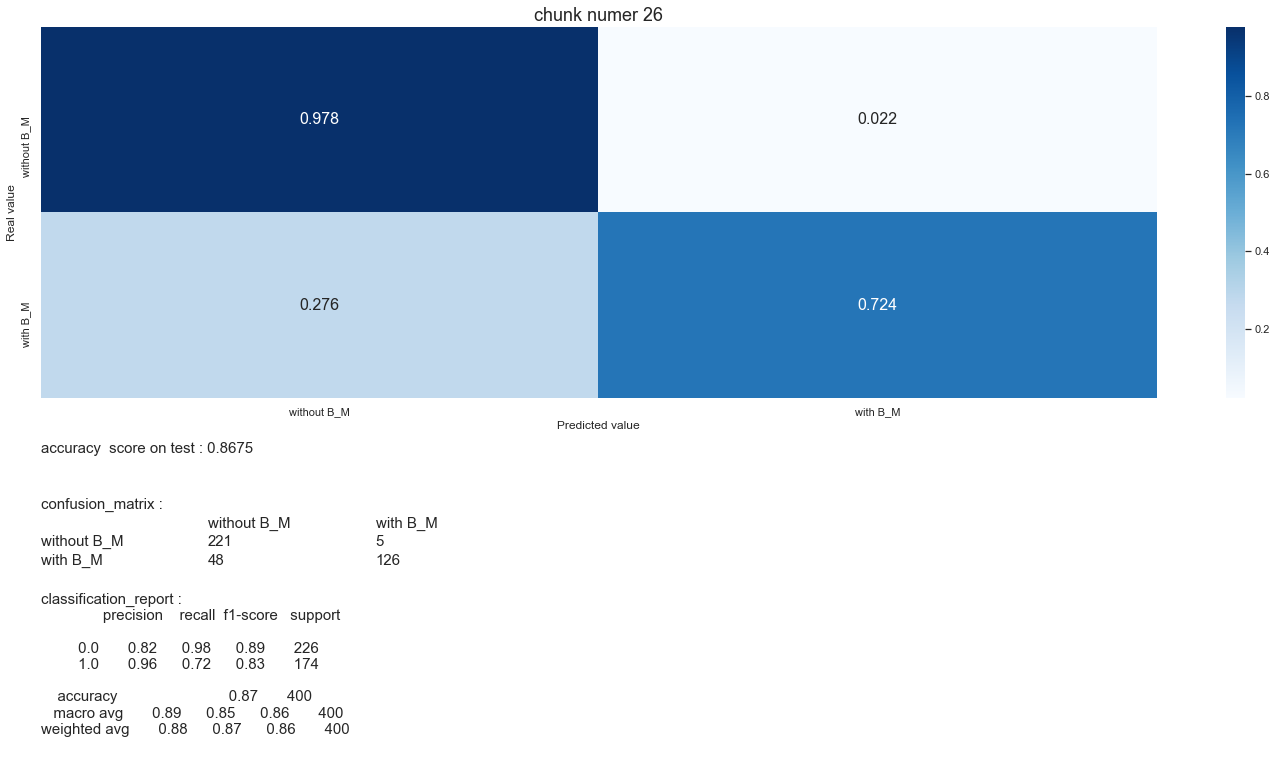

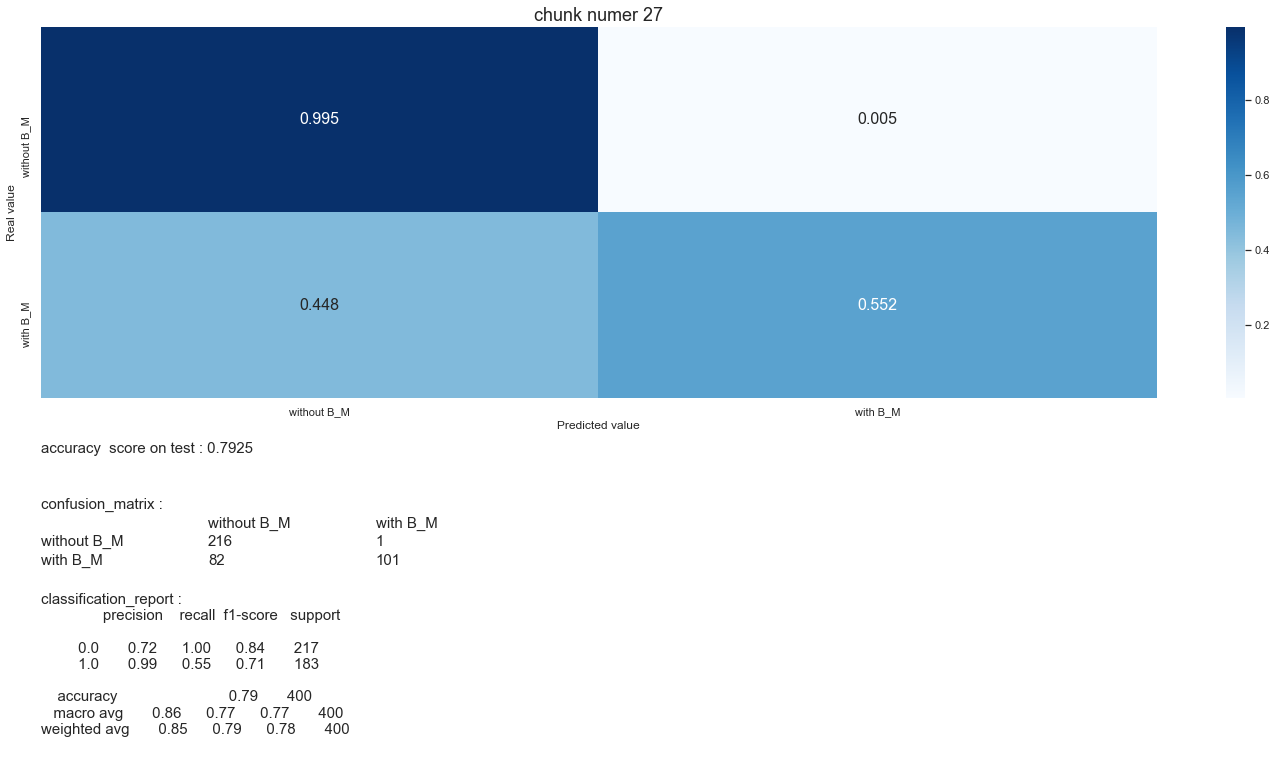

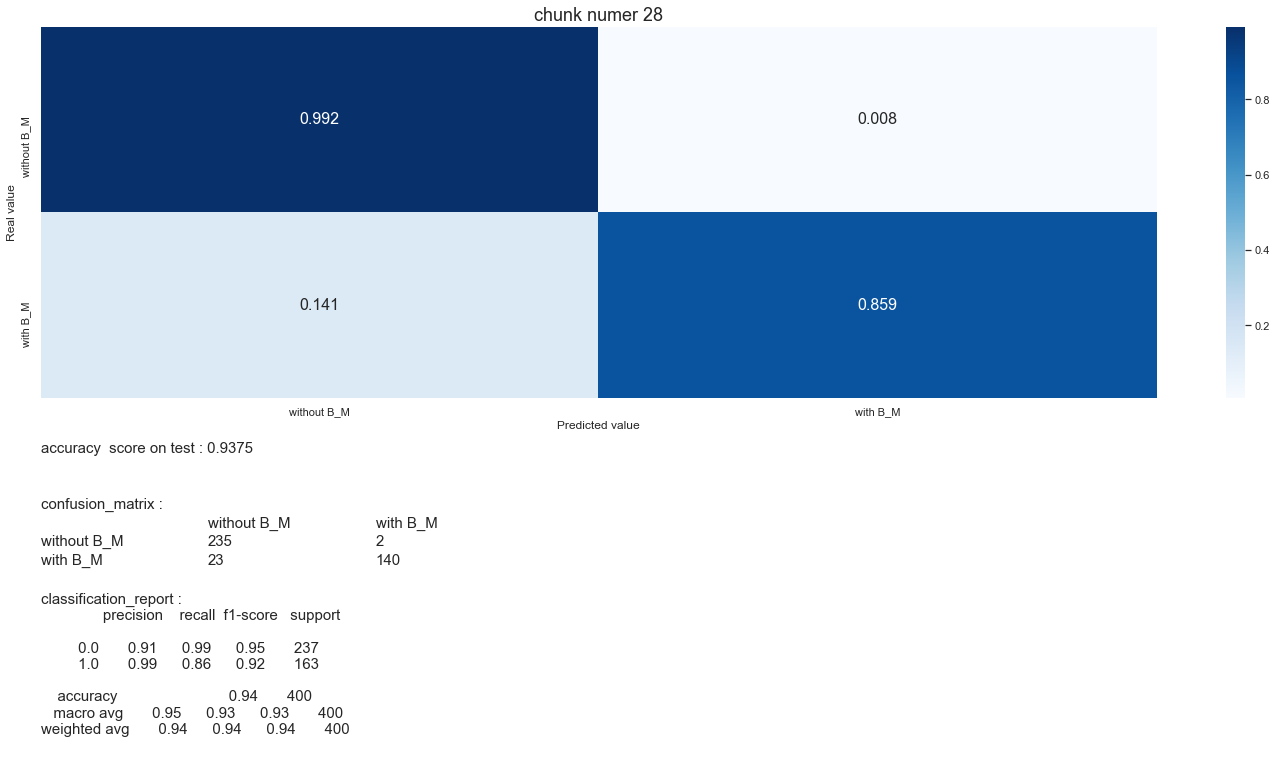

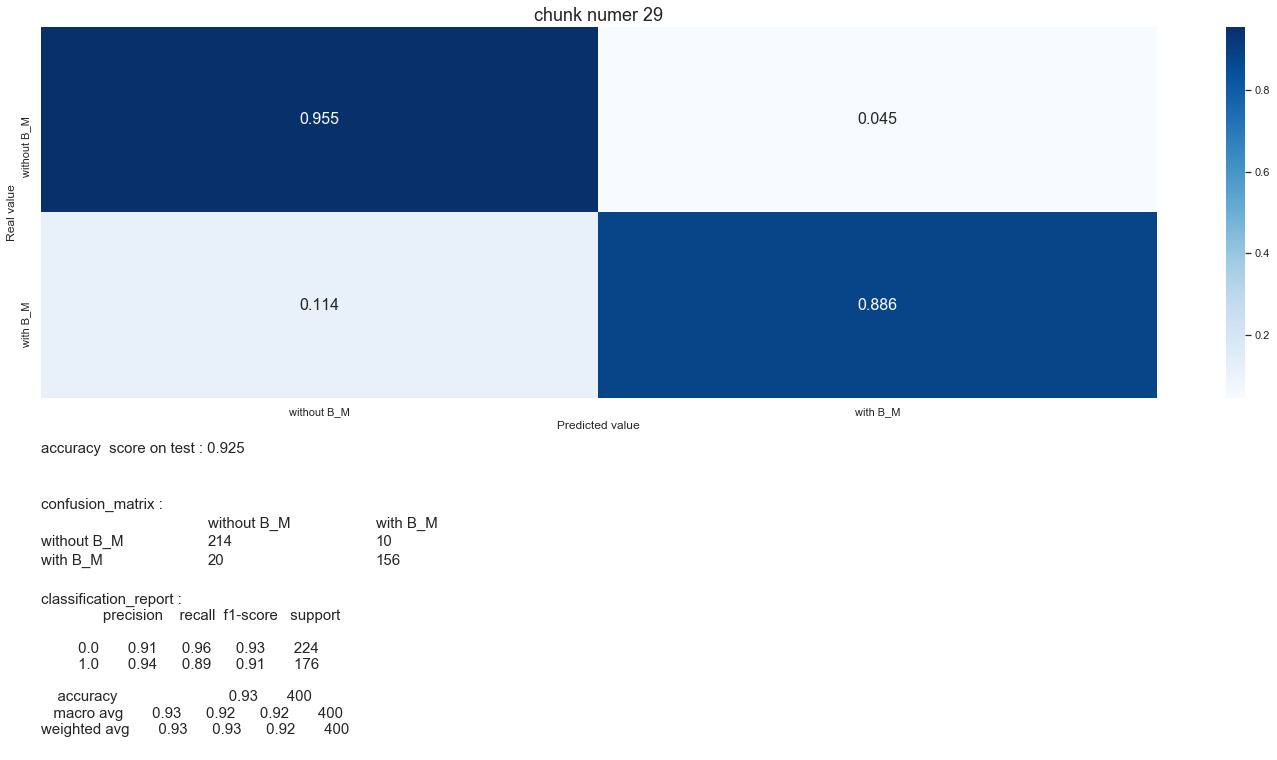

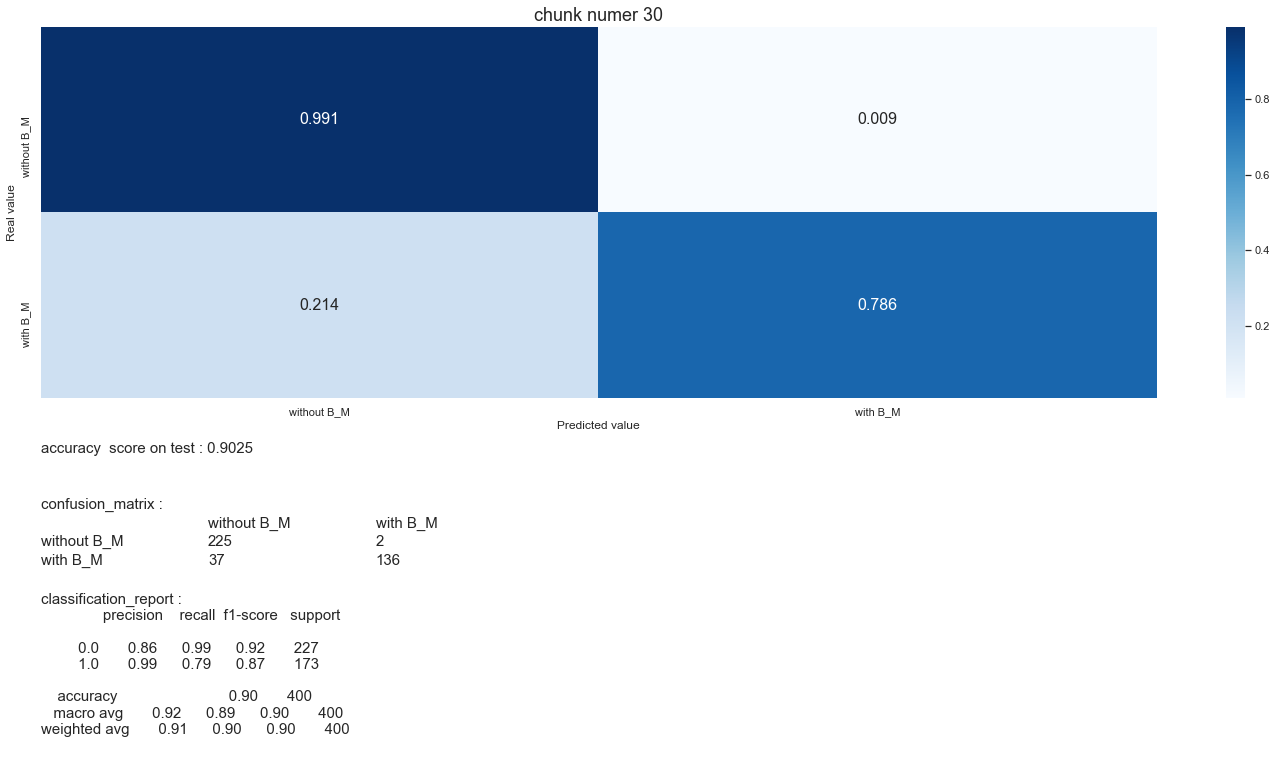

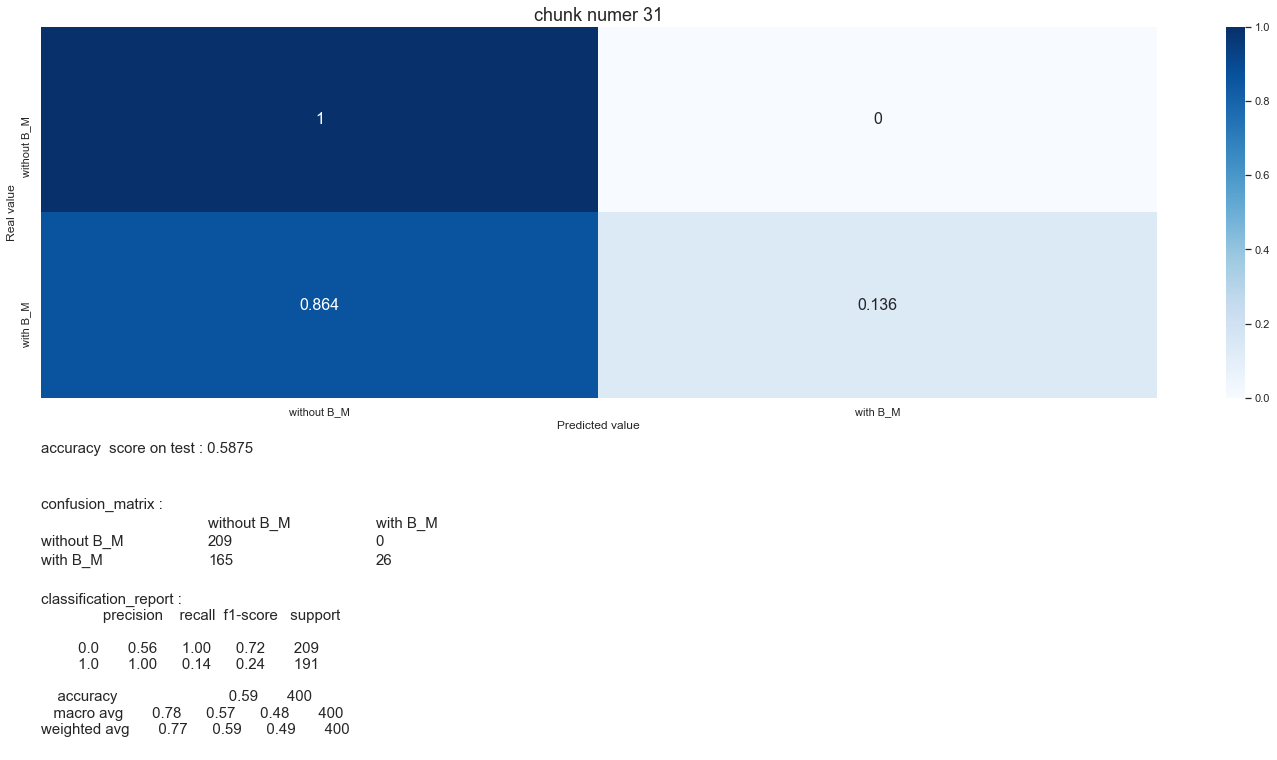

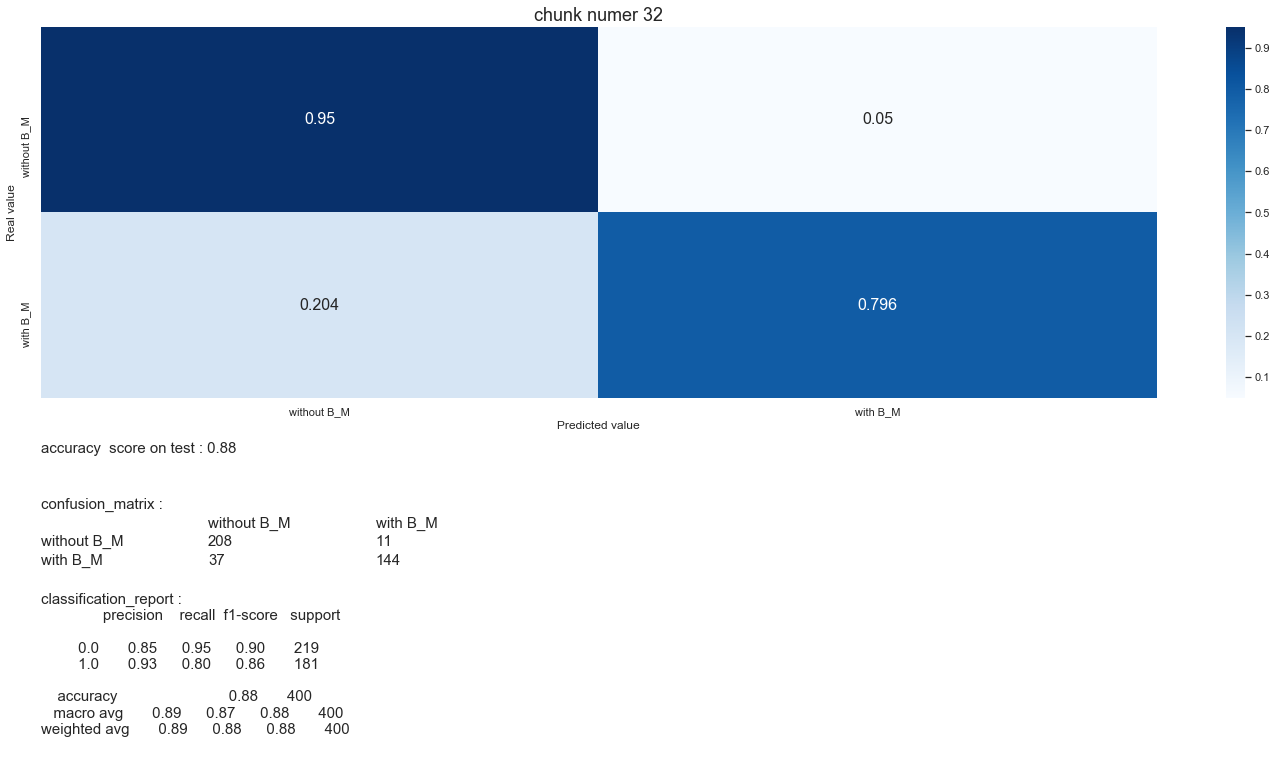

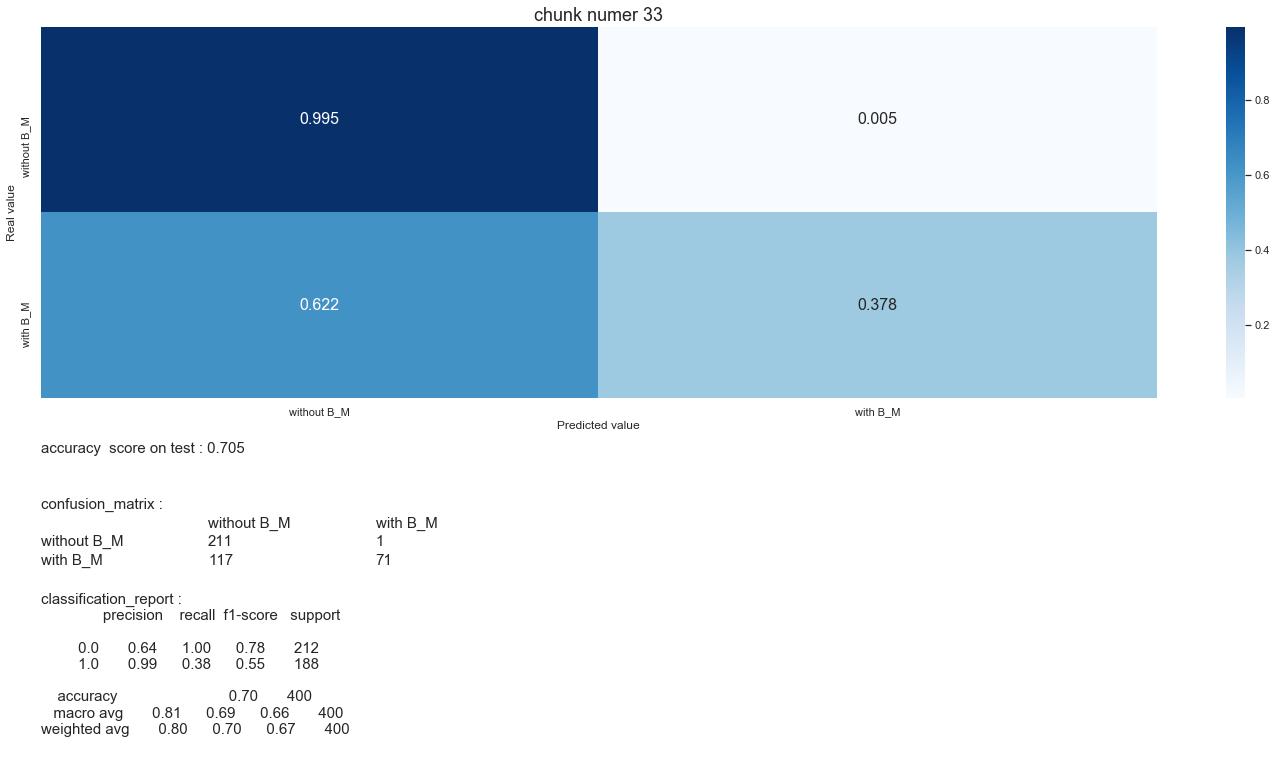

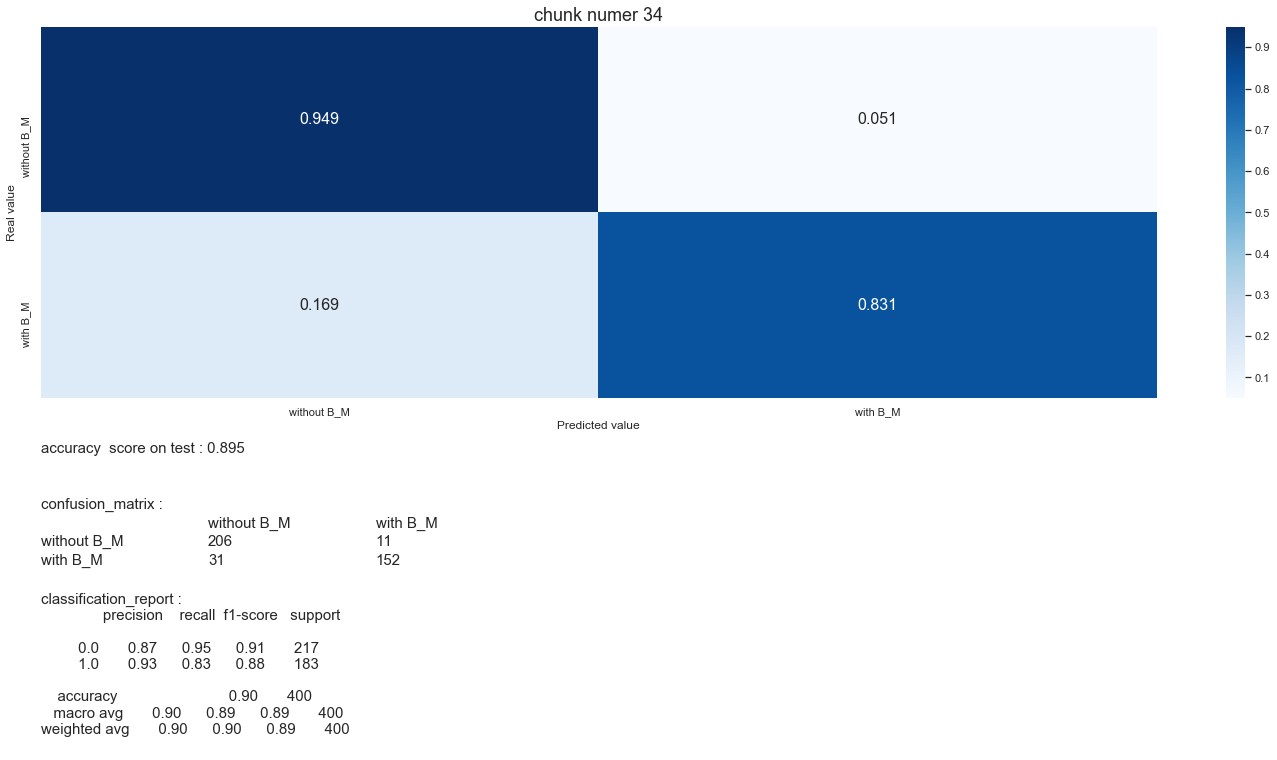

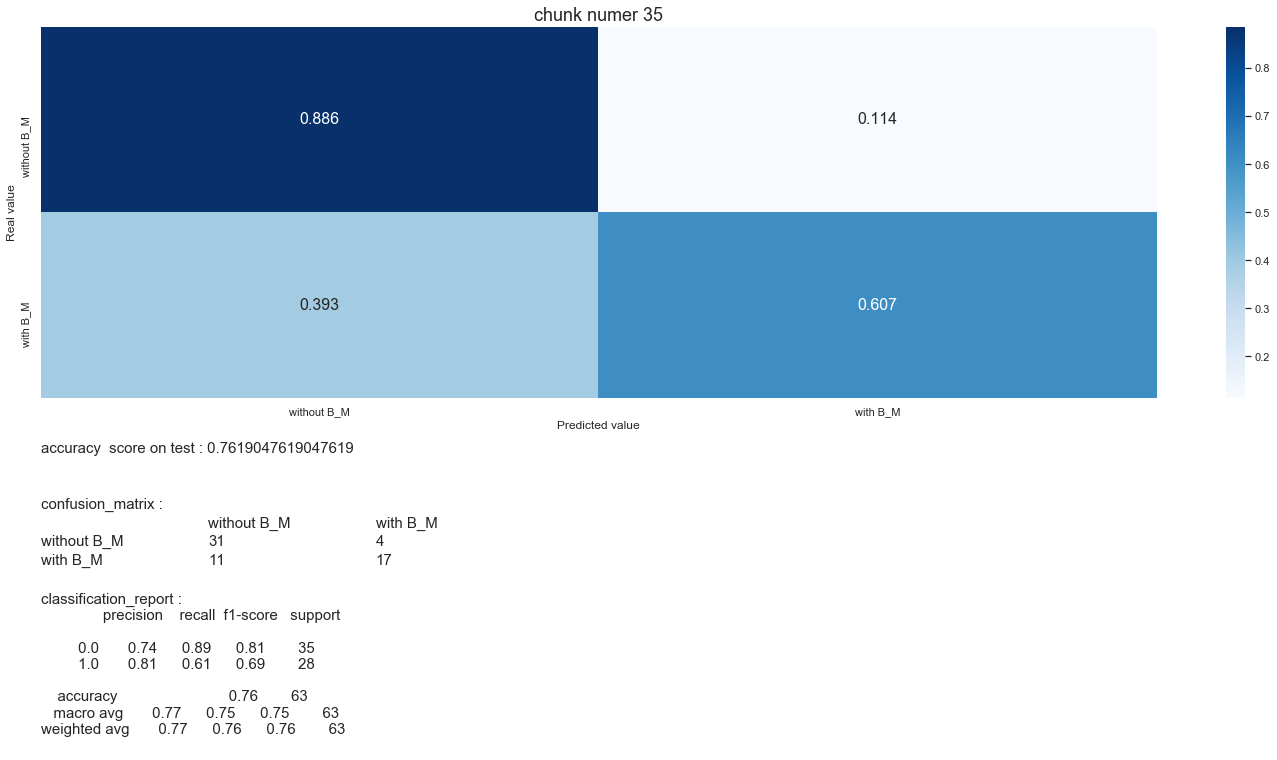

In [96]:
# prints(df_)
for i,y_test in enumerate(df_['y_test'].tolist()):
    y_test = list(map(_replaceitem, y_test))
    y_predict = list(map(_replaceitem, df_['y_predict'][i].tolist()))
    print_result(y_predict, y_test , "_chunk numer "+str(i) ,'Blues')

In [2]:
from keras.layers import Input
from keras.models import Model
def get_bottom_top_model(model, layer_name):
    
    layer = model.get_layer(layer_name)
    
    bottom_input = Input(model.input_shape[1:])
    
    bottom_output = bottom_input
    
    top_input = Input(layer.output_shape[1:])
    top_output = top_input

    bottom = True
    
    for layer in model.layers:
        if bottom:
            bottom_output = layer(bottom_output)
        else:
            top_output = layer(top_output)
        if layer.name == layer_name:
            bottom = False

    bottom_model = Model(bottom_input, bottom_output)
    top_model = Model(top_input, top_output)

    return bottom_model, top_model
model = load_model ('Model_for_all_data.h5')
bottom_model, top_model = get_bottom_top_model(model, model.layers[1].name)

In [3]:
bottom_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 50)           125800    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 100, 100)          40400     
Total params: 166,200
Trainable params: 166,200
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.input_shape

(None, 100)

In [6]:
bottom_model.input_shape

(None, 100)

In [8]:
top_model.input_shape

(None, 100, 100)

In [4]:
top_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100)]        0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 100, 100)          60400     
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 94, 128)           89728     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 80, 128)           245888    
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 56, 128)           409728    
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 22, 128)           573568    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)              

In [5]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 50)           125800    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 100, 100)          40400     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 100, 100)          60400     
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 94, 128)           89728     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 80, 128)           245888    
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 56, 128)           409728    
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 22, 128)          